In [18]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!ls gdrive/MyDrive/amin_lab
%cd /content/gdrive/MyDrive/amin_lab
!pwd

autoencoder_nol1
autoencoder_nol1.pkl
autoencoder_state_dict
CCLE_expression.csv
dl_encl.pth
dl_encmclr_l1_drpout.pth
dl_encmclr_l1e4_drpout_.pth
dl_encmclr_l1e4_drpout.pth
dl_encmclr_l1e4_drpout_sgd.pth
dl_encmclr_norm_drpout_.pth
dl_encmclr.pth
loss_dl_encl.pkl
loss_dl_encmclr_l1_drpout.pkl
loss_dl_encmclr_l1e4_drpout_.pkl
loss_dl_encmclr_l1e4_drpout.pkl
loss_dl_encmclr.pkl
loss.pkl
sample_info.csv
test_embeddings.pkl
testing_L1regularization_dropout_batchnormalization
train_embeddings.pkl
val_embeddings.pkl
x_test.pkl
x_train.pkl
x_val.pkl
y_test.pkl
y_train.pkl
y_val.pkl
/content/gdrive/MyDrive/amin_lab
/content/gdrive/MyDrive/amin_lab


In [9]:
import torch
from torch import optim
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torchvision
import pandas as pd
import copy
import random
import pickle
import torch.nn.functional as F
from torch.nn import Linear
from torch.utils.data import DataLoader,TensorDataset
from torch import Tensor

In [4]:
#load the processed split data
def load_df(name):
    return pd.read_pickle('data/'name+'.pkl')

[x_train, y_train, x_test, y_test, x_val, y_val] = map(load_df, ['x_train','y_train','x_test','y_test', 'x_val','y_val']) 

In [5]:
x_train.head()

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,AC055839.2 (728392),NOTCH2NLC (100996717),AP001453.3 (114841035),H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),NPBWR1 (2831),CDR1 (1038)
1093,-2.036041,-0.202133,-0.959808,0.466730,1.813356,0.134221,-0.935848,-2.685061,0.231533,1.996951,...,0.333343,0.935817,-0.890431,0.842414,0.284438,0.603281,0.901959,1.266103,-0.427278,-0.342603
948,-0.083300,-0.202133,-1.280208,-1.041742,-0.675873,-0.345250,0.632367,0.290115,0.653451,0.446523,...,-1.055308,-0.175773,0.483681,1.409030,1.604255,-0.638377,-0.390603,-1.094110,-0.334834,-0.342603
49,0.399981,-0.202133,-1.236744,1.570846,1.253890,-0.257248,1.492883,0.368481,1.264399,-0.239113,...,-0.781297,0.231142,0.375957,0.018621,2.414723,-1.299784,-1.533869,-1.094110,3.222304,3.378367
1258,-2.018844,-0.202133,-0.499971,1.189786,0.183886,-0.257248,-0.275239,0.083516,-0.743537,-0.129418,...,-0.191197,1.632046,-0.436586,0.027966,-0.388369,-0.160189,1.050580,-0.211982,-0.450962,-0.342603
706,0.602574,-0.202133,1.059945,-0.360794,0.833561,-0.236257,-0.119837,0.422134,0.330678,-0.285620,...,-0.844762,-0.232473,-1.485432,-1.178771,0.827626,1.607551,-0.979515,-0.968154,4.388809,-0.342603


In [8]:
#removing the string label column leaving the one hot encodings
y_train_ohe = y_train.drop('sample_collection_site', axis=1)
#create a tensor dataset while turning the datfrmaes to numpy and setting their type to float32
dataset = TensorDataset(Tensor(x_train.astype(np.float32).to_numpy()), Tensor(y_train_ohe.astype(np.float32).to_numpy()))
#batch size can be treated as a hyperparameter but 16 was the maximum number I could fit on my local GPU
train_loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

y_val_ohe = y_val.drop('sample_collection_site', axis=1)
dataset_val = TensorDataset(Tensor(x_val.astype(np.float32).to_numpy()), Tensor(y_val_ohe.astype(np.float32).to_numpy()))
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size=18252, drop_rate=0.2):
        super(Encoder, self).__init__()
        self.drop_rate = drop_rate
        self.enc1 = nn.Linear(input_size, input_size//2)
        #self.enc2 = nn.Linear(input_size//2, input_size//2//4)
        self.enc3 = nn.Linear(input_size//2, input_size//2//4)#//4//8)
        #self.enc4 = nn.Linear(input_size//2//4//4, input_size//2//4//4//8)
        self.enc5 = nn.Linear(input_size//2//4, 512)
    def forward(self, features):
        x = torch.relu(torch.dropout(self.enc1(features), p=self.drop_rate, train=True))
        #x = torch.dropout(torch.relu(self.enc2(x)), p=self.drop_rate, train=True)
        x = torch.relu(torch.dropout(self.enc3(x), p=self.drop_rate, train=True))
        #x = torch.dropout(torch.relu(self.enc4(x)), p=self.drop_rate, train=True)
        #x = torch.dropout(torch.relu(self.enc5(x)), p=drop_rate)
        code = self.enc5(x)
        return code

class Decoder(nn.Module):
    def __init__(self, input_size=18252, drop_rate=0.2):
        super(Decoder, self).__init__()
        self.drop_rate= drop_rate
        self.dec1 = nn.Linear(512, input_size//2//4)
        #self.dec2 = nn.Linear(input_size//2//4//4//8, input_size//2//4//4)
        self.dec3 = nn.Linear(input_size//2//4, input_size//2)
        #.dec4 = nn.Linear(input_size//2//4, input_size//2)
        self.dec5 = nn.Linear(input_size//2, input_size)
    def forward(self, code):
        x = torch.relu(torch.dropout(self.dec1(code), p=self.drop_rate, train=True))
        #x = torch.dropout(torch.relu(self.dec2(x)), p=self.drop_rate, train=True)
        x = torch.relu(torch.dropout(self.dec3(x), p=self.drop_rate, train=True))
        #x = torch.dropout(torch.relu(self.dec4(x)), p=self.drop_rate, train=True)
        reconstructed = self.dec5(x)
        return reconstructed

class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, features):
        latent = self.encoder(features)
        return self.decoder(latent)
            

In [8]:
#takes GPU space so restart runtime after this step and don't run this cell
# from torchsummary import summary
# print(summary(EncDec().to('cuda'),x_train.shape))

In [9]:
def train_valid(name, model, device, train_loader, valid_loader, l1_lambda=0.001, input_len=19221, n_epochs=100):
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.05)
    #set the optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    #set the loss function
    criterion = nn.MSELoss()
    losses = []
    min_val_loss = np.inf
    for epoch in tqdm(range(n_epochs)):
        model.train()
        loss = 0
        for batched, label in train_loader:
            #put the tensors on the GPU
            batched_features = batched.to(device)
            #reset the gradients back to zero
            optimizer.zero_grad()
            #compute reconstructions
            outputs = model(batched_features)
            #compute training reconstruction loss
            train_loss = criterion(outputs, batched_features)
            #compute accumulated gradients
            train_loss.backward()
            #perform parameter update based on current gradients
            optimizer.step()
            #add the batch training loss to epoch loss + l1-regularization
            loss += train_loss.item()
                #+ l1_lambda*sum(p.abs().sum() for p in model.parameters()))
            
            #validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for feats, lv in valid_loader:
                feat = feats.to(device)
                target = model(feat)
                l = criterion(target, feat)
                val_loss+= l.item()
                                #+ l1_lambda*sum(p.abs().sum() for p in model.parameters()))

        # compute the epoch training loss
        loss = loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        losses.append((loss, val_loss))
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}, val_loss = {:.6f}".format(epoch + 1, n_epochs, loss, val_loss))
        
        if min_val_loss > val_loss:
            print('val loss decreased, saved model')
            min_val_loss = val_loss
            torch.save(model.state_dict(), 'results/'name )

    with open('results/loss_'+name+'.pkl','wb') as f:
      pickle.dump(losses,f)

    return model, model.eval()

In [10]:
#put the model on the GPU
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = EncDec().to(device) #double?


cuda


In [11]:
trained,ev = train_valid('autoencoder_nol1',model, device, train_loader, val_loader, input_len=18252, n_epochs=1400)

  0%|          | 0/1400 [00:00<?, ?it/s]

epoch : 1/1400, loss = 0.982081, val_loss = 0.976867
val loss decreased, saved model


  0%|          | 1/1400 [00:13<5:07:33, 13.19s/it]

epoch : 2/1400, loss = 0.980418, val_loss = 0.974575
val loss decreased, saved model


  0%|          | 2/1400 [00:23<4:27:54, 11.50s/it]

epoch : 3/1400, loss = 0.976392, val_loss = 0.969015
val loss decreased, saved model


  0%|          | 3/1400 [00:33<4:13:59, 10.91s/it]

epoch : 4/1400, loss = 0.966845, val_loss = 0.956352
val loss decreased, saved model


  0%|          | 4/1400 [00:44<4:10:50, 10.78s/it]

epoch : 5/1400, loss = 0.947524, val_loss = 0.934090
val loss decreased, saved model


  0%|          | 5/1400 [00:54<4:09:34, 10.73s/it]

epoch : 6/1400, loss = 0.917168, val_loss = 0.905789
val loss decreased, saved model


  0%|          | 6/1400 [01:06<4:13:13, 10.90s/it]

epoch : 7/1400, loss = 0.886770, val_loss = 0.884301
val loss decreased, saved model


  0%|          | 7/1400 [01:17<4:13:17, 10.91s/it]

epoch : 8/1400, loss = 0.863208, val_loss = 0.862004
val loss decreased, saved model


  1%|          | 8/1400 [01:26<4:05:12, 10.57s/it]

epoch : 9/1400, loss = 0.840039, val_loss = 0.844839
val loss decreased, saved model


  1%|          | 9/1400 [01:38<4:11:56, 10.87s/it]

epoch : 10/1400, loss = 0.823856, val_loss = 0.831045
val loss decreased, saved model


  1%|          | 10/1400 [01:49<4:11:48, 10.87s/it]

epoch : 11/1400, loss = 0.809048, val_loss = 0.819777
val loss decreased, saved model


  1%|          | 11/1400 [01:59<4:07:49, 10.71s/it]

epoch : 12/1400, loss = 0.796363, val_loss = 0.810377
val loss decreased, saved model


  1%|          | 12/1400 [02:10<4:11:35, 10.88s/it]

epoch : 13/1400, loss = 0.784522, val_loss = 0.801098
val loss decreased, saved model


  1%|          | 13/1400 [02:21<4:07:36, 10.71s/it]

epoch : 14/1400, loss = 0.773995, val_loss = 0.794151
val loss decreased, saved model


  1%|          | 14/1400 [02:31<4:05:17, 10.62s/it]

epoch : 15/1400, loss = 0.765057, val_loss = 0.786800
val loss decreased, saved model


  1%|          | 15/1400 [02:41<4:01:36, 10.47s/it]

epoch : 16/1400, loss = 0.757143, val_loss = 0.780933
val loss decreased, saved model


  1%|          | 16/1400 [02:52<4:01:05, 10.45s/it]

epoch : 17/1400, loss = 0.749770, val_loss = 0.775587
val loss decreased, saved model


  1%|          | 17/1400 [03:02<4:00:42, 10.44s/it]

epoch : 18/1400, loss = 0.743638, val_loss = 0.771093
val loss decreased, saved model


  1%|▏         | 18/1400 [03:13<4:02:49, 10.54s/it]

epoch : 19/1400, loss = 0.738164, val_loss = 0.767295
val loss decreased, saved model


  1%|▏         | 19/1400 [03:23<4:00:46, 10.46s/it]

epoch : 20/1400, loss = 0.732868, val_loss = 0.763021
val loss decreased, saved model


  1%|▏         | 20/1400 [03:34<3:59:43, 10.42s/it]

epoch : 21/1400, loss = 0.727625, val_loss = 0.759506
val loss decreased, saved model


  2%|▏         | 21/1400 [03:45<4:06:04, 10.71s/it]

epoch : 22/1400, loss = 0.722765, val_loss = 0.755870
val loss decreased, saved model


  2%|▏         | 22/1400 [03:55<4:03:27, 10.60s/it]

epoch : 23/1400, loss = 0.717916, val_loss = 0.752507
val loss decreased, saved model


  2%|▏         | 23/1400 [04:06<4:07:50, 10.80s/it]

epoch : 24/1400, loss = 0.712984, val_loss = 0.749487
val loss decreased, saved model


  2%|▏         | 24/1400 [04:17<4:04:12, 10.65s/it]

epoch : 25/1400, loss = 0.708161, val_loss = 0.745562
val loss decreased, saved model


  2%|▏         | 25/1400 [04:28<4:04:47, 10.68s/it]

epoch : 26/1400, loss = 0.703607, val_loss = 0.741808
val loss decreased, saved model


  2%|▏         | 26/1400 [04:38<4:04:46, 10.69s/it]

epoch : 27/1400, loss = 0.698491, val_loss = 0.737821
val loss decreased, saved model


  2%|▏         | 27/1400 [04:49<4:02:46, 10.61s/it]

epoch : 28/1400, loss = 0.693726, val_loss = 0.734146
val loss decreased, saved model


  2%|▏         | 28/1400 [04:59<4:00:39, 10.52s/it]

epoch : 29/1400, loss = 0.689046, val_loss = 0.730024
val loss decreased, saved model


  2%|▏         | 29/1400 [05:10<4:07:06, 10.81s/it]

epoch : 30/1400, loss = 0.683748, val_loss = 0.726234
val loss decreased, saved model


  2%|▏         | 30/1400 [05:21<4:03:31, 10.67s/it]

epoch : 31/1400, loss = 0.679326, val_loss = 0.721983
val loss decreased, saved model


  2%|▏         | 31/1400 [05:31<4:01:23, 10.58s/it]

epoch : 32/1400, loss = 0.673957, val_loss = 0.717915
val loss decreased, saved model


  2%|▏         | 32/1400 [05:42<4:00:06, 10.53s/it]

epoch : 33/1400, loss = 0.669367, val_loss = 0.714163
val loss decreased, saved model


  2%|▏         | 33/1400 [05:52<3:59:08, 10.50s/it]

epoch : 34/1400, loss = 0.664976, val_loss = 0.710472
val loss decreased, saved model


  2%|▏         | 34/1400 [06:03<4:00:01, 10.54s/it]

epoch : 35/1400, loss = 0.661099, val_loss = 0.707137
val loss decreased, saved model


  2%|▎         | 35/1400 [06:13<4:01:38, 10.62s/it]

epoch : 36/1400, loss = 0.656644, val_loss = 0.703872
val loss decreased, saved model


  3%|▎         | 36/1400 [06:24<3:58:48, 10.51s/it]

epoch : 37/1400, loss = 0.653339, val_loss = 0.700460
val loss decreased, saved model


  3%|▎         | 37/1400 [06:34<3:57:33, 10.46s/it]

epoch : 38/1400, loss = 0.649185, val_loss = 0.698451
val loss decreased, saved model


  3%|▎         | 38/1400 [06:45<3:58:16, 10.50s/it]

epoch : 39/1400, loss = 0.645857, val_loss = 0.695473
val loss decreased, saved model


  3%|▎         | 39/1400 [06:55<3:58:26, 10.51s/it]

epoch : 40/1400, loss = 0.642323, val_loss = 0.692686
val loss decreased, saved model


  3%|▎         | 40/1400 [07:07<4:04:10, 10.77s/it]

epoch : 41/1400, loss = 0.639357, val_loss = 0.690200
val loss decreased, saved model


  3%|▎         | 41/1400 [07:17<4:03:08, 10.73s/it]

epoch : 42/1400, loss = 0.636278, val_loss = 0.687796
val loss decreased, saved model


  3%|▎         | 42/1400 [07:28<4:01:39, 10.68s/it]

epoch : 43/1400, loss = 0.632971, val_loss = 0.686077
val loss decreased, saved model


  3%|▎         | 43/1400 [07:38<4:01:16, 10.67s/it]

epoch : 44/1400, loss = 0.630132, val_loss = 0.683602
val loss decreased, saved model


  3%|▎         | 44/1400 [07:49<4:02:33, 10.73s/it]

epoch : 45/1400, loss = 0.626826, val_loss = 0.681893
val loss decreased, saved model


  3%|▎         | 45/1400 [08:00<3:59:48, 10.62s/it]

epoch : 46/1400, loss = 0.623998, val_loss = 0.680137
val loss decreased, saved model


  3%|▎         | 46/1400 [08:12<4:08:14, 11.00s/it]

epoch : 47/1400, loss = 0.621307, val_loss = 0.677829
val loss decreased, saved model


  3%|▎         | 47/1400 [08:22<4:06:42, 10.94s/it]

epoch : 48/1400, loss = 0.618156, val_loss = 0.676397
val loss decreased, saved model


  3%|▎         | 48/1400 [08:33<4:06:22, 10.93s/it]

epoch : 49/1400, loss = 0.615585, val_loss = 0.674153
val loss decreased, saved model


  4%|▎         | 49/1400 [08:44<4:04:42, 10.87s/it]

epoch : 50/1400, loss = 0.612482, val_loss = 0.672126
val loss decreased, saved model


  4%|▎         | 50/1400 [08:55<4:02:31, 10.78s/it]

epoch : 51/1400, loss = 0.609336, val_loss = 0.670603
val loss decreased, saved model


  4%|▎         | 51/1400 [09:05<4:03:15, 10.82s/it]

epoch : 52/1400, loss = 0.606835, val_loss = 0.668447
val loss decreased, saved model


  4%|▎         | 52/1400 [09:16<4:00:39, 10.71s/it]

epoch : 53/1400, loss = 0.603645, val_loss = 0.666753
val loss decreased, saved model


  4%|▍         | 53/1400 [09:26<3:57:14, 10.57s/it]

epoch : 54/1400, loss = 0.601148, val_loss = 0.664709
val loss decreased, saved model


  4%|▍         | 54/1400 [09:36<3:54:54, 10.47s/it]

epoch : 55/1400, loss = 0.598010, val_loss = 0.662895
val loss decreased, saved model


  4%|▍         | 55/1400 [09:47<3:53:22, 10.41s/it]

epoch : 56/1400, loss = 0.595493, val_loss = 0.660797
val loss decreased, saved model


  4%|▍         | 56/1400 [09:57<3:51:52, 10.35s/it]

epoch : 57/1400, loss = 0.592696, val_loss = 0.659274
val loss decreased, saved model


  4%|▍         | 57/1400 [10:08<3:53:48, 10.45s/it]

epoch : 58/1400, loss = 0.589370, val_loss = 0.657611
val loss decreased, saved model


  4%|▍         | 58/1400 [10:19<3:57:38, 10.63s/it]

epoch : 59/1400, loss = 0.586654, val_loss = 0.655669
val loss decreased, saved model


  4%|▍         | 59/1400 [10:29<3:56:07, 10.56s/it]

epoch : 60/1400, loss = 0.584407, val_loss = 0.654406
val loss decreased, saved model


  4%|▍         | 60/1400 [10:40<3:55:36, 10.55s/it]

epoch : 61/1400, loss = 0.582221, val_loss = 0.653093
val loss decreased, saved model


  4%|▍         | 61/1400 [10:50<3:54:51, 10.52s/it]

epoch : 62/1400, loss = 0.579403, val_loss = 0.650577
val loss decreased, saved model


  4%|▍         | 62/1400 [11:00<3:53:37, 10.48s/it]

epoch : 63/1400, loss = 0.577334, val_loss = 0.649114
val loss decreased, saved model


  4%|▍         | 63/1400 [11:12<4:01:26, 10.83s/it]

epoch : 64/1400, loss = 0.574378, val_loss = 0.647954
val loss decreased, saved model


  5%|▍         | 64/1400 [11:22<3:58:47, 10.72s/it]

epoch : 65/1400, loss = 0.572283, val_loss = 0.646498
val loss decreased, saved model


  5%|▍         | 65/1400 [11:33<4:00:26, 10.81s/it]

epoch : 66/1400, loss = 0.569283, val_loss = 0.645162
val loss decreased, saved model


  5%|▍         | 66/1400 [11:45<4:06:48, 11.10s/it]

epoch : 67/1400, loss = 0.567712, val_loss = 0.643052
val loss decreased, saved model


  5%|▍         | 67/1400 [11:56<4:01:58, 10.89s/it]

epoch : 68/1400, loss = 0.565182, val_loss = 0.642469
val loss decreased, saved model


  5%|▍         | 68/1400 [12:06<3:59:36, 10.79s/it]

epoch : 69/1400, loss = 0.563120, val_loss = 0.640543
val loss decreased, saved model


  5%|▍         | 69/1400 [12:18<4:05:36, 11.07s/it]

epoch : 70/1400, loss = 0.561054, val_loss = 0.639185
val loss decreased, saved model


  5%|▌         | 70/1400 [12:28<4:00:50, 10.87s/it]

epoch : 71/1400, loss = 0.558083, val_loss = 0.637927
val loss decreased, saved model


  5%|▌         | 71/1400 [12:39<4:00:58, 10.88s/it]

epoch : 72/1400, loss = 0.556052, val_loss = 0.636684
val loss decreased, saved model


  5%|▌         | 72/1400 [12:50<4:02:12, 10.94s/it]

epoch : 73/1400, loss = 0.554112, val_loss = 0.635113
val loss decreased, saved model


  5%|▌         | 73/1400 [13:01<3:59:48, 10.84s/it]

epoch : 74/1400, loss = 0.551316, val_loss = 0.634735
val loss decreased, saved model


  5%|▌         | 74/1400 [13:12<3:59:53, 10.85s/it]

epoch : 75/1400, loss = 0.549969, val_loss = 0.633030
val loss decreased, saved model


  5%|▌         | 75/1400 [13:22<3:57:54, 10.77s/it]

epoch : 76/1400, loss = 0.547818, val_loss = 0.631414
val loss decreased, saved model


  5%|▌         | 76/1400 [13:33<3:55:08, 10.66s/it]

epoch : 77/1400, loss = 0.545762, val_loss = 0.630173
val loss decreased, saved model


  6%|▌         | 77/1400 [13:43<3:54:52, 10.65s/it]

epoch : 78/1400, loss = 0.543898, val_loss = 0.628935
val loss decreased, saved model


  6%|▌         | 78/1400 [13:54<3:52:43, 10.56s/it]

epoch : 79/1400, loss = 0.542327, val_loss = 0.628045
val loss decreased, saved model


  6%|▌         | 79/1400 [14:05<3:55:54, 10.72s/it]

epoch : 80/1400, loss = 0.540135, val_loss = 0.627198
val loss decreased, saved model


  6%|▌         | 80/1400 [14:16<4:00:28, 10.93s/it]

epoch : 81/1400, loss = 0.537731, val_loss = 0.625486
val loss decreased, saved model


  6%|▌         | 81/1400 [14:27<4:00:13, 10.93s/it]

epoch : 82/1400, loss = 0.536472, val_loss = 0.624090
val loss decreased, saved model


  6%|▌         | 82/1400 [14:38<3:57:17, 10.80s/it]

epoch : 83/1400, loss = 0.534483, val_loss = 0.623247
val loss decreased, saved model


  6%|▌         | 83/1400 [14:49<3:57:55, 10.84s/it]

epoch : 84/1400, loss = 0.532462, val_loss = 0.622419
val loss decreased, saved model


  6%|▌         | 84/1400 [14:59<3:55:36, 10.74s/it]

epoch : 85/1400, loss = 0.530800, val_loss = 0.621003
val loss decreased, saved model


  6%|▌         | 85/1400 [15:10<3:56:39, 10.80s/it]

epoch : 86/1400, loss = 0.528297, val_loss = 0.619916
val loss decreased, saved model


  6%|▌         | 86/1400 [15:21<3:53:52, 10.68s/it]

epoch : 87/1400, loss = 0.526186, val_loss = 0.619678
val loss decreased, saved model


  6%|▌         | 87/1400 [15:31<3:54:10, 10.70s/it]

epoch : 88/1400, loss = 0.525208, val_loss = 0.617789
val loss decreased, saved model


  6%|▋         | 88/1400 [15:43<3:58:11, 10.89s/it]

epoch : 89/1400, loss = 0.523021, val_loss = 0.616870
val loss decreased, saved model


  6%|▋         | 89/1400 [15:53<3:57:55, 10.89s/it]

epoch : 90/1400, loss = 0.521812, val_loss = 0.615402
val loss decreased, saved model


  6%|▋         | 90/1400 [16:05<4:00:49, 11.03s/it]

epoch : 91/1400, loss = 0.519742, val_loss = 0.614588
val loss decreased, saved model


  6%|▋         | 91/1400 [16:17<4:05:41, 11.26s/it]

epoch : 92/1400, loss = 0.518063, val_loss = 0.613891
val loss decreased, saved model


  7%|▋         | 92/1400 [16:27<4:01:30, 11.08s/it]

epoch : 93/1400, loss = 0.516979, val_loss = 0.612778
val loss decreased, saved model


  7%|▋         | 93/1400 [16:38<3:56:46, 10.87s/it]

epoch : 94/1400, loss = 0.515126, val_loss = 0.612096
val loss decreased, saved model


  7%|▋         | 94/1400 [16:49<3:56:38, 10.87s/it]

epoch : 95/1400, loss = 0.513615, val_loss = 0.610751
val loss decreased, saved model


  7%|▋         | 95/1400 [16:59<3:54:01, 10.76s/it]

epoch : 96/1400, loss = 0.511831, val_loss = 0.609593
val loss decreased, saved model


  7%|▋         | 96/1400 [17:11<3:58:52, 10.99s/it]

epoch : 97/1400, loss = 0.510314, val_loss = 0.608992
val loss decreased, saved model


  7%|▋         | 97/1400 [17:22<3:59:33, 11.03s/it]

epoch : 98/1400, loss = 0.508451, val_loss = 0.607917
val loss decreased, saved model


  7%|▋         | 98/1400 [17:33<3:59:11, 11.02s/it]

epoch : 99/1400, loss = 0.506802, val_loss = 0.607482
val loss decreased, saved model


  7%|▋         | 99/1400 [17:43<3:56:54, 10.93s/it]

epoch : 100/1400, loss = 0.505054, val_loss = 0.606406
val loss decreased, saved model


  7%|▋         | 100/1400 [17:54<3:53:45, 10.79s/it]

epoch : 101/1400, loss = 0.503407, val_loss = 0.605511
val loss decreased, saved model


  7%|▋         | 101/1400 [18:04<3:52:17, 10.73s/it]

epoch : 102/1400, loss = 0.502473, val_loss = 0.603933
val loss decreased, saved model


  7%|▋         | 103/1400 [18:19<3:09:03,  8.75s/it]

epoch : 103/1400, loss = 0.500403, val_loss = 0.604078
epoch : 104/1400, loss = 0.499438, val_loss = 0.602690
val loss decreased, saved model


  7%|▋         | 104/1400 [18:30<3:21:59,  9.35s/it]

epoch : 105/1400, loss = 0.497413, val_loss = 0.602085
val loss decreased, saved model


  8%|▊         | 105/1400 [18:41<3:29:29,  9.71s/it]

epoch : 106/1400, loss = 0.495975, val_loss = 0.601272
val loss decreased, saved model


  8%|▊         | 106/1400 [18:51<3:34:03,  9.93s/it]

epoch : 107/1400, loss = 0.495134, val_loss = 0.600815
val loss decreased, saved model


  8%|▊         | 107/1400 [19:02<3:37:56, 10.11s/it]

epoch : 108/1400, loss = 0.494072, val_loss = 0.599444
val loss decreased, saved model


  8%|▊         | 108/1400 [19:13<3:45:38, 10.48s/it]

epoch : 109/1400, loss = 0.492291, val_loss = 0.598214
val loss decreased, saved model


  8%|▊         | 110/1400 [19:28<3:03:49,  8.55s/it]

epoch : 110/1400, loss = 0.490946, val_loss = 0.598426
epoch : 111/1400, loss = 0.489864, val_loss = 0.596696
val loss decreased, saved model


  8%|▊         | 111/1400 [19:39<3:24:34,  9.52s/it]

epoch : 112/1400, loss = 0.488531, val_loss = 0.596377
val loss decreased, saved model


  8%|▊         | 112/1400 [19:50<3:33:30,  9.95s/it]

epoch : 113/1400, loss = 0.486847, val_loss = 0.595286
val loss decreased, saved model


  8%|▊         | 113/1400 [20:01<3:40:13, 10.27s/it]

epoch : 114/1400, loss = 0.485754, val_loss = 0.595087
val loss decreased, saved model


  8%|▊         | 114/1400 [20:12<3:44:27, 10.47s/it]

epoch : 115/1400, loss = 0.484677, val_loss = 0.594163
val loss decreased, saved model


  8%|▊         | 115/1400 [20:23<3:46:34, 10.58s/it]

epoch : 116/1400, loss = 0.483658, val_loss = 0.593889
val loss decreased, saved model


  8%|▊         | 116/1400 [20:34<3:47:21, 10.62s/it]

epoch : 117/1400, loss = 0.481720, val_loss = 0.592957
val loss decreased, saved model


  8%|▊         | 117/1400 [20:45<3:48:44, 10.70s/it]

epoch : 118/1400, loss = 0.481340, val_loss = 0.592604
val loss decreased, saved model


  8%|▊         | 118/1400 [20:55<3:48:13, 10.68s/it]

epoch : 119/1400, loss = 0.479269, val_loss = 0.591688
val loss decreased, saved model


  8%|▊         | 119/1400 [21:07<3:50:40, 10.80s/it]

epoch : 120/1400, loss = 0.478217, val_loss = 0.591445
val loss decreased, saved model


  9%|▊         | 120/1400 [21:19<4:01:22, 11.31s/it]

epoch : 121/1400, loss = 0.476687, val_loss = 0.590951
val loss decreased, saved model


  9%|▊         | 121/1400 [21:30<3:57:33, 11.14s/it]

epoch : 122/1400, loss = 0.476127, val_loss = 0.590029
val loss decreased, saved model


  9%|▉         | 123/1400 [21:44<3:09:09,  8.89s/it]

epoch : 123/1400, loss = 0.474719, val_loss = 0.590243
epoch : 124/1400, loss = 0.473237, val_loss = 0.589207
val loss decreased, saved model


  9%|▉         | 124/1400 [21:55<3:21:15,  9.46s/it]

epoch : 125/1400, loss = 0.472214, val_loss = 0.588521
val loss decreased, saved model


  9%|▉         | 125/1400 [22:06<3:28:31,  9.81s/it]

epoch : 126/1400, loss = 0.471630, val_loss = 0.587937
val loss decreased, saved model


  9%|▉         | 126/1400 [22:17<3:36:28, 10.20s/it]

epoch : 127/1400, loss = 0.470197, val_loss = 0.586781
val loss decreased, saved model


  9%|▉         | 128/1400 [22:32<2:58:47,  8.43s/it]

epoch : 128/1400, loss = 0.469061, val_loss = 0.587069
epoch : 129/1400, loss = 0.467474, val_loss = 0.586134
val loss decreased, saved model


  9%|▉         | 129/1400 [22:42<3:13:12,  9.12s/it]

epoch : 130/1400, loss = 0.466508, val_loss = 0.584834
val loss decreased, saved model


  9%|▉         | 130/1400 [22:53<3:22:47,  9.58s/it]

epoch : 131/1400, loss = 0.465409, val_loss = 0.584247
val loss decreased, saved model


  9%|▉         | 131/1400 [23:04<3:29:58,  9.93s/it]

epoch : 132/1400, loss = 0.463957, val_loss = 0.583537
val loss decreased, saved model


  9%|▉         | 132/1400 [23:15<3:36:47, 10.26s/it]

epoch : 133/1400, loss = 0.463072, val_loss = 0.583389
val loss decreased, saved model


 10%|▉         | 133/1400 [23:25<3:39:30, 10.39s/it]

epoch : 134/1400, loss = 0.461941, val_loss = 0.583034
val loss decreased, saved model


 10%|▉         | 134/1400 [23:37<3:43:56, 10.61s/it]

epoch : 135/1400, loss = 0.461313, val_loss = 0.582387
val loss decreased, saved model


 10%|▉         | 135/1400 [23:47<3:43:52, 10.62s/it]

epoch : 136/1400, loss = 0.459777, val_loss = 0.581545
val loss decreased, saved model


 10%|▉         | 137/1400 [24:02<3:00:43,  8.59s/it]

epoch : 137/1400, loss = 0.459246, val_loss = 0.581605
epoch : 138/1400, loss = 0.458280, val_loss = 0.580151
val loss decreased, saved model


 10%|▉         | 138/1400 [24:13<3:18:13,  9.42s/it]

epoch : 139/1400, loss = 0.457020, val_loss = 0.579743
val loss decreased, saved model


 10%|▉         | 139/1400 [24:25<3:31:06, 10.04s/it]

epoch : 140/1400, loss = 0.455610, val_loss = 0.579739
val loss decreased, saved model


 10%|█         | 140/1400 [24:36<3:37:08, 10.34s/it]

epoch : 141/1400, loss = 0.454893, val_loss = 0.578200
val loss decreased, saved model


 10%|█         | 141/1400 [24:46<3:40:13, 10.49s/it]

epoch : 142/1400, loss = 0.453716, val_loss = 0.577826
val loss decreased, saved model


 10%|█         | 143/1400 [25:01<3:00:49,  8.63s/it]

epoch : 143/1400, loss = 0.453042, val_loss = 0.578011
epoch : 144/1400, loss = 0.452128, val_loss = 0.576778
val loss decreased, saved model


 10%|█         | 145/1400 [25:17<2:45:51,  7.93s/it]

epoch : 145/1400, loss = 0.450986, val_loss = 0.577009
epoch : 146/1400, loss = 0.450906, val_loss = 0.575966
val loss decreased, saved model


 10%|█         | 146/1400 [25:28<3:04:30,  8.83s/it]

epoch : 147/1400, loss = 0.449518, val_loss = 0.575916
val loss decreased, saved model


 10%|█         | 147/1400 [25:39<3:19:13,  9.54s/it]

epoch : 148/1400, loss = 0.448204, val_loss = 0.575118
val loss decreased, saved model


 11%|█         | 148/1400 [25:50<3:25:50,  9.86s/it]

epoch : 149/1400, loss = 0.447502, val_loss = 0.574608
val loss decreased, saved model


 11%|█         | 149/1400 [26:01<3:30:52, 10.11s/it]

epoch : 150/1400, loss = 0.446575, val_loss = 0.574333
val loss decreased, saved model


 11%|█         | 151/1400 [26:17<3:02:18,  8.76s/it]

epoch : 151/1400, loss = 0.445706, val_loss = 0.574435
epoch : 152/1400, loss = 0.445099, val_loss = 0.573440
val loss decreased, saved model


 11%|█         | 153/1400 [26:31<2:40:15,  7.71s/it]

epoch : 153/1400, loss = 0.443596, val_loss = 0.573572
epoch : 154/1400, loss = 0.442863, val_loss = 0.572722
val loss decreased, saved model


 11%|█         | 154/1400 [26:42<2:57:17,  8.54s/it]

epoch : 155/1400, loss = 0.441763, val_loss = 0.571893
val loss decreased, saved model


 11%|█         | 155/1400 [26:52<3:09:49,  9.15s/it]

epoch : 156/1400, loss = 0.440635, val_loss = 0.571348
val loss decreased, saved model


 11%|█         | 156/1400 [27:03<3:18:14,  9.56s/it]

epoch : 157/1400, loss = 0.439807, val_loss = 0.570989
val loss decreased, saved model


 11%|█         | 157/1400 [27:14<3:27:49, 10.03s/it]

epoch : 158/1400, loss = 0.438910, val_loss = 0.570277
val loss decreased, saved model


 11%|█▏        | 158/1400 [27:25<3:36:40, 10.47s/it]

epoch : 159/1400, loss = 0.438517, val_loss = 0.570203
val loss decreased, saved model


 11%|█▏        | 159/1400 [27:37<3:45:14, 10.89s/it]

epoch : 160/1400, loss = 0.437221, val_loss = 0.569575
val loss decreased, saved model


 11%|█▏        | 160/1400 [27:48<3:47:01, 10.98s/it]

epoch : 161/1400, loss = 0.436600, val_loss = 0.568878
val loss decreased, saved model


 12%|█▏        | 161/1400 [27:59<3:46:33, 10.97s/it]

epoch : 162/1400, loss = 0.435792, val_loss = 0.568816
val loss decreased, saved model


 12%|█▏        | 162/1400 [28:10<3:45:14, 10.92s/it]

epoch : 163/1400, loss = 0.435398, val_loss = 0.567879
val loss decreased, saved model


 12%|█▏        | 163/1400 [28:22<3:50:55, 11.20s/it]

epoch : 164/1400, loss = 0.434442, val_loss = 0.567592
val loss decreased, saved model


 12%|█▏        | 164/1400 [28:33<3:47:14, 11.03s/it]

epoch : 165/1400, loss = 0.433267, val_loss = 0.567065
val loss decreased, saved model


 12%|█▏        | 165/1400 [28:44<3:46:19, 11.00s/it]

epoch : 166/1400, loss = 0.432636, val_loss = 0.566450
val loss decreased, saved model


 12%|█▏        | 167/1400 [28:58<3:00:46,  8.80s/it]

epoch : 167/1400, loss = 0.432283, val_loss = 0.566556
epoch : 168/1400, loss = 0.430568, val_loss = 0.566163
val loss decreased, saved model


 12%|█▏        | 168/1400 [29:09<3:14:21,  9.47s/it]

epoch : 169/1400, loss = 0.430190, val_loss = 0.565345
val loss decreased, saved model


 12%|█▏        | 169/1400 [29:20<3:22:18,  9.86s/it]

epoch : 170/1400, loss = 0.429185, val_loss = 0.565292
val loss decreased, saved model


 12%|█▏        | 170/1400 [29:31<3:27:19, 10.11s/it]

epoch : 171/1400, loss = 0.428125, val_loss = 0.564418
val loss decreased, saved model


 12%|█▏        | 171/1400 [29:42<3:33:03, 10.40s/it]

epoch : 172/1400, loss = 0.427835, val_loss = 0.564032
val loss decreased, saved model


 12%|█▏        | 172/1400 [29:52<3:34:38, 10.49s/it]

epoch : 173/1400, loss = 0.427255, val_loss = 0.563893
val loss decreased, saved model


 12%|█▏        | 173/1400 [30:03<3:34:55, 10.51s/it]

epoch : 174/1400, loss = 0.426227, val_loss = 0.563659
val loss decreased, saved model


 12%|█▏        | 174/1400 [30:14<3:39:26, 10.74s/it]

epoch : 175/1400, loss = 0.425229, val_loss = 0.562981
val loss decreased, saved model


 13%|█▎        | 176/1400 [30:30<3:02:41,  8.96s/it]

epoch : 176/1400, loss = 0.423769, val_loss = 0.563577
epoch : 177/1400, loss = 0.423615, val_loss = 0.562461
val loss decreased, saved model


 13%|█▎        | 177/1400 [30:41<3:15:13,  9.58s/it]

epoch : 178/1400, loss = 0.423234, val_loss = 0.561477
val loss decreased, saved model


 13%|█▎        | 179/1400 [30:56<2:43:45,  8.05s/it]

epoch : 179/1400, loss = 0.421997, val_loss = 0.561934
epoch : 180/1400, loss = 0.421257, val_loss = 0.560682
val loss decreased, saved model


 13%|█▎        | 180/1400 [31:06<2:59:04,  8.81s/it]

epoch : 181/1400, loss = 0.420690, val_loss = 0.560001
val loss decreased, saved model


 13%|█▎        | 182/1400 [31:21<2:38:52,  7.83s/it]

epoch : 182/1400, loss = 0.420456, val_loss = 0.560154
epoch : 183/1400, loss = 0.419035, val_loss = 0.559769
val loss decreased, saved model


 13%|█▎        | 183/1400 [31:33<3:01:09,  8.93s/it]

epoch : 184/1400, loss = 0.418348, val_loss = 0.559750
val loss decreased, saved model


 13%|█▎        | 184/1400 [31:44<3:14:50,  9.61s/it]

epoch : 185/1400, loss = 0.417539, val_loss = 0.558739
val loss decreased, saved model


 13%|█▎        | 185/1400 [31:55<3:22:05,  9.98s/it]

epoch : 186/1400, loss = 0.416749, val_loss = 0.558713
val loss decreased, saved model


 13%|█▎        | 187/1400 [32:09<2:48:07,  8.32s/it]

epoch : 187/1400, loss = 0.416221, val_loss = 0.558759
epoch : 188/1400, loss = 0.415230, val_loss = 0.558135
val loss decreased, saved model


 13%|█▎        | 188/1400 [32:21<3:08:22,  9.33s/it]

epoch : 189/1400, loss = 0.414974, val_loss = 0.557613
val loss decreased, saved model


 14%|█▎        | 189/1400 [32:32<3:18:11,  9.82s/it]

epoch : 190/1400, loss = 0.414527, val_loss = 0.557088
val loss decreased, saved model


 14%|█▎        | 191/1400 [32:47<2:47:19,  8.30s/it]

epoch : 191/1400, loss = 0.413061, val_loss = 0.557220
epoch : 192/1400, loss = 0.412714, val_loss = 0.556942
val loss decreased, saved model


 14%|█▎        | 192/1400 [32:58<3:05:06,  9.19s/it]

epoch : 193/1400, loss = 0.412160, val_loss = 0.556617
val loss decreased, saved model


 14%|█▍        | 193/1400 [33:09<3:15:24,  9.71s/it]

epoch : 194/1400, loss = 0.410980, val_loss = 0.556576
val loss decreased, saved model


 14%|█▍        | 194/1400 [33:20<3:22:29, 10.07s/it]

epoch : 195/1400, loss = 0.410433, val_loss = 0.556315
val loss decreased, saved model


 14%|█▍        | 195/1400 [33:31<3:26:17, 10.27s/it]

epoch : 196/1400, loss = 0.409691, val_loss = 0.555252
val loss decreased, saved model


 14%|█▍        | 197/1400 [33:46<2:50:38,  8.51s/it]

epoch : 197/1400, loss = 0.409189, val_loss = 0.556108
epoch : 198/1400, loss = 0.408189, val_loss = 0.554981
val loss decreased, saved model


 14%|█▍        | 198/1400 [33:57<3:03:14,  9.15s/it]

epoch : 199/1400, loss = 0.407860, val_loss = 0.554120
val loss decreased, saved model


 14%|█▍        | 200/1400 [34:11<2:38:15,  7.91s/it]

epoch : 200/1400, loss = 0.406899, val_loss = 0.554785
epoch : 201/1400, loss = 0.406241, val_loss = 0.553947
val loss decreased, saved model


 14%|█▍        | 201/1400 [34:23<3:03:37,  9.19s/it]

epoch : 202/1400, loss = 0.405717, val_loss = 0.553495
val loss decreased, saved model


 14%|█▍        | 202/1400 [34:34<3:12:31,  9.64s/it]

epoch : 203/1400, loss = 0.404553, val_loss = 0.553161
val loss decreased, saved model


 14%|█▍        | 203/1400 [34:45<3:20:21, 10.04s/it]

epoch : 204/1400, loss = 0.404359, val_loss = 0.552326
val loss decreased, saved model


 15%|█▍        | 205/1400 [35:00<2:45:54,  8.33s/it]

epoch : 205/1400, loss = 0.403280, val_loss = 0.552661
epoch : 206/1400, loss = 0.402879, val_loss = 0.551644
val loss decreased, saved model


 15%|█▍        | 207/1400 [35:14<2:29:49,  7.53s/it]

epoch : 207/1400, loss = 0.402436, val_loss = 0.552121


 15%|█▍        | 208/1400 [35:19<2:12:27,  6.67s/it]

epoch : 208/1400, loss = 0.401474, val_loss = 0.551864
epoch : 209/1400, loss = 0.400658, val_loss = 0.551099
val loss decreased, saved model


 15%|█▍        | 209/1400 [35:32<2:47:20,  8.43s/it]

epoch : 210/1400, loss = 0.400594, val_loss = 0.550920
val loss decreased, saved model


 15%|█▌        | 211/1400 [35:46<2:30:20,  7.59s/it]

epoch : 211/1400, loss = 0.399510, val_loss = 0.551031
epoch : 212/1400, loss = 0.398708, val_loss = 0.550123
val loss decreased, saved model


 15%|█▌        | 213/1400 [36:01<2:21:01,  7.13s/it]

epoch : 213/1400, loss = 0.398380, val_loss = 0.550751
epoch : 214/1400, loss = 0.397255, val_loss = 0.549970
val loss decreased, saved model


 15%|█▌        | 214/1400 [36:11<2:41:32,  8.17s/it]

epoch : 215/1400, loss = 0.396958, val_loss = 0.549289
val loss decreased, saved model


 15%|█▌        | 215/1400 [36:23<3:03:58,  9.32s/it]

epoch : 216/1400, loss = 0.396367, val_loss = 0.548528
val loss decreased, saved model


 16%|█▌        | 217/1400 [36:38<2:37:48,  8.00s/it]

epoch : 217/1400, loss = 0.395632, val_loss = 0.549007


 16%|█▌        | 218/1400 [36:42<2:14:28,  6.83s/it]

epoch : 218/1400, loss = 0.394896, val_loss = 0.548676
epoch : 219/1400, loss = 0.393917, val_loss = 0.548091
val loss decreased, saved model


 16%|█▌        | 220/1400 [36:57<2:14:56,  6.86s/it]

epoch : 220/1400, loss = 0.393638, val_loss = 0.548390


 16%|█▌        | 221/1400 [37:01<1:58:44,  6.04s/it]

epoch : 221/1400, loss = 0.393288, val_loss = 0.548246
epoch : 222/1400, loss = 0.392772, val_loss = 0.547390
val loss decreased, saved model


 16%|█▌        | 222/1400 [37:13<2:29:46,  7.63s/it]

epoch : 223/1400, loss = 0.391498, val_loss = 0.547107
val loss decreased, saved model


 16%|█▌        | 224/1400 [37:28<2:25:19,  7.41s/it]

epoch : 224/1400, loss = 0.391494, val_loss = 0.547132
epoch : 225/1400, loss = 0.390673, val_loss = 0.546153
val loss decreased, saved model


 16%|█▌        | 225/1400 [37:40<2:48:14,  8.59s/it]

epoch : 226/1400, loss = 0.389711, val_loss = 0.545917
val loss decreased, saved model


 16%|█▌        | 227/1400 [37:55<2:30:48,  7.71s/it]

epoch : 227/1400, loss = 0.389290, val_loss = 0.546386


 16%|█▋        | 228/1400 [37:59<2:09:01,  6.61s/it]

epoch : 228/1400, loss = 0.388689, val_loss = 0.545981
epoch : 229/1400, loss = 0.388556, val_loss = 0.545582
val loss decreased, saved model


 16%|█▋        | 229/1400 [38:10<2:38:12,  8.11s/it]

epoch : 230/1400, loss = 0.387774, val_loss = 0.545179
val loss decreased, saved model


 16%|█▋        | 231/1400 [38:26<2:28:22,  7.62s/it]

epoch : 231/1400, loss = 0.386885, val_loss = 0.545329


 17%|█▋        | 232/1400 [38:30<2:07:25,  6.55s/it]

epoch : 232/1400, loss = 0.386349, val_loss = 0.545219


 17%|█▋        | 233/1400 [38:34<1:54:13,  5.87s/it]

epoch : 233/1400, loss = 0.385984, val_loss = 0.545284
epoch : 234/1400, loss = 0.384985, val_loss = 0.544080
val loss decreased, saved model


 17%|█▋        | 235/1400 [38:49<2:04:07,  6.39s/it]

epoch : 235/1400, loss = 0.384797, val_loss = 0.544442
epoch : 236/1400, loss = 0.383978, val_loss = 0.544030
val loss decreased, saved model


 17%|█▋        | 237/1400 [39:04<2:06:41,  6.54s/it]

epoch : 237/1400, loss = 0.383204, val_loss = 0.544097
epoch : 238/1400, loss = 0.383123, val_loss = 0.543595
val loss decreased, saved model


 17%|█▋        | 238/1400 [39:15<2:31:02,  7.80s/it]

epoch : 239/1400, loss = 0.381707, val_loss = 0.542740
val loss decreased, saved model


 17%|█▋        | 240/1400 [39:32<2:32:07,  7.87s/it]

epoch : 240/1400, loss = 0.381870, val_loss = 0.543077


 17%|█▋        | 241/1400 [39:37<2:10:33,  6.76s/it]

epoch : 241/1400, loss = 0.381120, val_loss = 0.543915
epoch : 242/1400, loss = 0.379962, val_loss = 0.541989
val loss decreased, saved model


 17%|█▋        | 243/1400 [39:52<2:13:41,  6.93s/it]

epoch : 243/1400, loss = 0.379936, val_loss = 0.542370


 17%|█▋        | 244/1400 [39:56<1:56:07,  6.03s/it]

epoch : 244/1400, loss = 0.379341, val_loss = 0.542159


 18%|█▊        | 245/1400 [40:00<1:46:19,  5.52s/it]

epoch : 245/1400, loss = 0.377896, val_loss = 0.542268
epoch : 246/1400, loss = 0.377875, val_loss = 0.541898
val loss decreased, saved model


 18%|█▊        | 246/1400 [40:12<2:18:52,  7.22s/it]

epoch : 247/1400, loss = 0.377149, val_loss = 0.541490
val loss decreased, saved model


 18%|█▊        | 247/1400 [40:23<2:42:16,  8.44s/it]

epoch : 248/1400, loss = 0.376451, val_loss = 0.541445
val loss decreased, saved model


 18%|█▊        | 248/1400 [40:34<2:55:46,  9.16s/it]

epoch : 249/1400, loss = 0.375658, val_loss = 0.541054
val loss decreased, saved model


 18%|█▊        | 249/1400 [40:45<3:07:52,  9.79s/it]

epoch : 250/1400, loss = 0.375195, val_loss = 0.539703
val loss decreased, saved model


 18%|█▊        | 251/1400 [41:00<2:39:10,  8.31s/it]

epoch : 251/1400, loss = 0.374660, val_loss = 0.541078
epoch : 252/1400, loss = 0.373730, val_loss = 0.539689
val loss decreased, saved model


 18%|█▊        | 253/1400 [41:17<2:32:56,  8.00s/it]

epoch : 253/1400, loss = 0.373278, val_loss = 0.540171
epoch : 254/1400, loss = 0.372906, val_loss = 0.539102
val loss decreased, saved model


 18%|█▊        | 255/1400 [41:32<2:23:59,  7.55s/it]

epoch : 255/1400, loss = 0.372062, val_loss = 0.539702


 18%|█▊        | 256/1400 [41:36<2:02:58,  6.45s/it]

epoch : 256/1400, loss = 0.371997, val_loss = 0.539621
epoch : 257/1400, loss = 0.371639, val_loss = 0.538290
val loss decreased, saved model


 18%|█▊        | 258/1400 [41:51<2:08:36,  6.76s/it]

epoch : 258/1400, loss = 0.370905, val_loss = 0.539335


 18%|█▊        | 259/1400 [41:55<1:52:01,  5.89s/it]

epoch : 259/1400, loss = 0.370666, val_loss = 0.538410


 19%|█▊        | 260/1400 [41:59<1:41:39,  5.35s/it]

epoch : 260/1400, loss = 0.369790, val_loss = 0.538691
epoch : 261/1400, loss = 0.368797, val_loss = 0.538216
val loss decreased, saved model


 19%|█▊        | 261/1400 [42:11<2:15:23,  7.13s/it]

epoch : 262/1400, loss = 0.368333, val_loss = 0.538101
val loss decreased, saved model


 19%|█▉        | 263/1400 [42:26<2:14:12,  7.08s/it]

epoch : 263/1400, loss = 0.368369, val_loss = 0.538160
epoch : 264/1400, loss = 0.367333, val_loss = 0.536976
val loss decreased, saved model


 19%|█▉        | 265/1400 [42:41<2:13:14,  7.04s/it]

epoch : 265/1400, loss = 0.366552, val_loss = 0.537140


 19%|█▉        | 266/1400 [42:45<1:56:37,  6.17s/it]

epoch : 266/1400, loss = 0.365851, val_loss = 0.537053


 19%|█▉        | 267/1400 [42:50<1:46:24,  5.64s/it]

epoch : 267/1400, loss = 0.365556, val_loss = 0.537707
epoch : 268/1400, loss = 0.365080, val_loss = 0.536349
val loss decreased, saved model


 19%|█▉        | 269/1400 [43:05<2:00:54,  6.41s/it]

epoch : 269/1400, loss = 0.364769, val_loss = 0.536590
epoch : 270/1400, loss = 0.363974, val_loss = 0.535823
val loss decreased, saved model


 19%|█▉        | 271/1400 [43:21<2:09:27,  6.88s/it]

epoch : 271/1400, loss = 0.363333, val_loss = 0.536467


 19%|█▉        | 272/1400 [43:26<1:53:33,  6.04s/it]

epoch : 272/1400, loss = 0.362948, val_loss = 0.535974
epoch : 273/1400, loss = 0.361880, val_loss = 0.535695
val loss decreased, saved model


 20%|█▉        | 274/1400 [43:42<2:05:34,  6.69s/it]

epoch : 274/1400, loss = 0.361421, val_loss = 0.536344
epoch : 275/1400, loss = 0.360819, val_loss = 0.535505
val loss decreased, saved model


 20%|█▉        | 275/1400 [43:53<2:31:29,  8.08s/it]

epoch : 276/1400, loss = 0.360192, val_loss = 0.534602
val loss decreased, saved model


 20%|█▉        | 277/1400 [44:08<2:21:35,  7.57s/it]

epoch : 277/1400, loss = 0.360335, val_loss = 0.534957


 20%|█▉        | 278/1400 [44:12<2:02:21,  6.54s/it]

epoch : 278/1400, loss = 0.359361, val_loss = 0.535208


 20%|█▉        | 279/1400 [44:18<1:56:03,  6.21s/it]

epoch : 279/1400, loss = 0.358869, val_loss = 0.534966


 20%|██        | 280/1400 [44:22<1:44:40,  5.61s/it]

epoch : 280/1400, loss = 0.358304, val_loss = 0.535835
epoch : 281/1400, loss = 0.357323, val_loss = 0.534352
val loss decreased, saved model


 20%|██        | 282/1400 [44:38<1:59:53,  6.43s/it]

epoch : 282/1400, loss = 0.357329, val_loss = 0.534508


 20%|██        | 283/1400 [44:42<1:45:41,  5.68s/it]

epoch : 283/1400, loss = 0.356655, val_loss = 0.534392
epoch : 284/1400, loss = 0.356242, val_loss = 0.534344
val loss decreased, saved model


 20%|██        | 284/1400 [44:53<2:15:09,  7.27s/it]

epoch : 285/1400, loss = 0.355230, val_loss = 0.533417
val loss decreased, saved model


 20%|██        | 286/1400 [45:08<2:12:33,  7.14s/it]

epoch : 286/1400, loss = 0.355140, val_loss = 0.533794


 20%|██        | 287/1400 [45:12<1:57:18,  6.32s/it]

epoch : 287/1400, loss = 0.354387, val_loss = 0.533607
epoch : 288/1400, loss = 0.353811, val_loss = 0.533416
val loss decreased, saved model


 21%|██        | 288/1400 [45:25<2:29:13,  8.05s/it]

epoch : 289/1400, loss = 0.353832, val_loss = 0.532655
val loss decreased, saved model


 21%|██        | 290/1400 [45:40<2:18:16,  7.47s/it]

epoch : 290/1400, loss = 0.353008, val_loss = 0.533403


 21%|██        | 291/1400 [45:44<1:59:56,  6.49s/it]

epoch : 291/1400, loss = 0.351875, val_loss = 0.532879
epoch : 292/1400, loss = 0.351686, val_loss = 0.532379
val loss decreased, saved model


 21%|██        | 293/1400 [45:59<2:04:57,  6.77s/it]

epoch : 293/1400, loss = 0.351190, val_loss = 0.533170


 21%|██        | 294/1400 [46:03<1:49:44,  5.95s/it]

epoch : 294/1400, loss = 0.350825, val_loss = 0.533284


 21%|██        | 295/1400 [46:07<1:39:17,  5.39s/it]

epoch : 295/1400, loss = 0.349596, val_loss = 0.533042
epoch : 296/1400, loss = 0.349341, val_loss = 0.532124
val loss decreased, saved model


 21%|██        | 297/1400 [46:23<1:58:17,  6.43s/it]

epoch : 297/1400, loss = 0.349355, val_loss = 0.533131


 21%|██▏       | 298/1400 [46:27<1:44:50,  5.71s/it]

epoch : 298/1400, loss = 0.348318, val_loss = 0.532179
epoch : 299/1400, loss = 0.347716, val_loss = 0.531865
val loss decreased, saved model


 21%|██▏       | 299/1400 [46:38<2:13:26,  7.27s/it]

epoch : 300/1400, loss = 0.347162, val_loss = 0.531248
val loss decreased, saved model


 21%|██▏       | 300/1400 [46:50<2:35:17,  8.47s/it]

epoch : 301/1400, loss = 0.346719, val_loss = 0.531015
val loss decreased, saved model


 22%|██▏       | 302/1400 [47:05<2:21:23,  7.73s/it]

epoch : 302/1400, loss = 0.346320, val_loss = 0.531417


 22%|██▏       | 303/1400 [47:10<2:07:00,  6.95s/it]

epoch : 303/1400, loss = 0.345270, val_loss = 0.531234


 22%|██▏       | 304/1400 [47:16<1:59:49,  6.56s/it]

epoch : 304/1400, loss = 0.344668, val_loss = 0.531782


 22%|██▏       | 305/1400 [47:20<1:49:34,  6.00s/it]

epoch : 305/1400, loss = 0.344666, val_loss = 0.531138


 22%|██▏       | 306/1400 [47:25<1:40:01,  5.49s/it]

epoch : 306/1400, loss = 0.344905, val_loss = 0.531194
epoch : 307/1400, loss = 0.343142, val_loss = 0.530841
val loss decreased, saved model


 22%|██▏       | 307/1400 [47:36<2:13:07,  7.31s/it]

epoch : 308/1400, loss = 0.342880, val_loss = 0.530452
val loss decreased, saved model


 22%|██▏       | 308/1400 [47:47<2:33:35,  8.44s/it]

epoch : 309/1400, loss = 0.342654, val_loss = 0.530337
val loss decreased, saved model


 22%|██▏       | 310/1400 [48:03<2:19:51,  7.70s/it]

epoch : 310/1400, loss = 0.341713, val_loss = 0.530374
epoch : 311/1400, loss = 0.341516, val_loss = 0.529842
val loss decreased, saved model


 22%|██▏       | 311/1400 [48:14<2:38:05,  8.71s/it]

epoch : 312/1400, loss = 0.341304, val_loss = 0.529617
val loss decreased, saved model


 22%|██▏       | 313/1400 [48:31<2:28:36,  8.20s/it]

epoch : 313/1400, loss = 0.340223, val_loss = 0.530053


 22%|██▏       | 314/1400 [48:35<2:06:25,  6.98s/it]

epoch : 314/1400, loss = 0.339896, val_loss = 0.529793


 22%|██▎       | 315/1400 [48:39<1:50:52,  6.13s/it]

epoch : 315/1400, loss = 0.339445, val_loss = 0.529951
epoch : 316/1400, loss = 0.339038, val_loss = 0.529574
val loss decreased, saved model


 23%|██▎       | 317/1400 [48:54<2:00:01,  6.65s/it]

epoch : 317/1400, loss = 0.338546, val_loss = 0.530585
epoch : 318/1400, loss = 0.337713, val_loss = 0.528816
val loss decreased, saved model


 23%|██▎       | 319/1400 [49:09<2:02:39,  6.81s/it]

epoch : 319/1400, loss = 0.337629, val_loss = 0.529044


 23%|██▎       | 320/1400 [49:14<1:48:20,  6.02s/it]

epoch : 320/1400, loss = 0.336885, val_loss = 0.529045
epoch : 321/1400, loss = 0.335965, val_loss = 0.528690
val loss decreased, saved model


 23%|██▎       | 322/1400 [49:30<2:01:50,  6.78s/it]

epoch : 322/1400, loss = 0.335610, val_loss = 0.528709
epoch : 323/1400, loss = 0.334929, val_loss = 0.528322
val loss decreased, saved model


 23%|██▎       | 323/1400 [49:41<2:24:11,  8.03s/it]

epoch : 324/1400, loss = 0.334600, val_loss = 0.527523
val loss decreased, saved model


 23%|██▎       | 325/1400 [49:57<2:17:24,  7.67s/it]

epoch : 325/1400, loss = 0.334307, val_loss = 0.528430


 23%|██▎       | 326/1400 [50:01<1:58:07,  6.60s/it]

epoch : 326/1400, loss = 0.333571, val_loss = 0.527975


 23%|██▎       | 327/1400 [50:05<1:44:26,  5.84s/it]

epoch : 327/1400, loss = 0.333482, val_loss = 0.528871


 23%|██▎       | 328/1400 [50:09<1:34:54,  5.31s/it]

epoch : 328/1400, loss = 0.332507, val_loss = 0.528286


 24%|██▎       | 329/1400 [50:13<1:28:34,  4.96s/it]

epoch : 329/1400, loss = 0.332215, val_loss = 0.527811


 24%|██▎       | 330/1400 [50:19<1:30:19,  5.06s/it]

epoch : 330/1400, loss = 0.331722, val_loss = 0.527902


 24%|██▎       | 331/1400 [50:23<1:27:27,  4.91s/it]

epoch : 331/1400, loss = 0.331355, val_loss = 0.528099
epoch : 332/1400, loss = 0.330321, val_loss = 0.527424
val loss decreased, saved model


 24%|██▎       | 332/1400 [50:35<2:02:08,  6.86s/it]

epoch : 333/1400, loss = 0.329925, val_loss = 0.526757
val loss decreased, saved model


 24%|██▍       | 334/1400 [50:50<2:03:26,  6.95s/it]

epoch : 334/1400, loss = 0.329278, val_loss = 0.527551


 24%|██▍       | 335/1400 [50:54<1:48:01,  6.09s/it]

epoch : 335/1400, loss = 0.328991, val_loss = 0.528068


 24%|██▍       | 336/1400 [50:58<1:37:26,  5.50s/it]

epoch : 336/1400, loss = 0.329033, val_loss = 0.527676


 24%|██▍       | 337/1400 [51:02<1:29:55,  5.08s/it]

epoch : 337/1400, loss = 0.328231, val_loss = 0.527813


 24%|██▍       | 338/1400 [51:07<1:30:10,  5.09s/it]

epoch : 338/1400, loss = 0.327044, val_loss = 0.527198


 24%|██▍       | 339/1400 [51:11<1:24:42,  4.79s/it]

epoch : 339/1400, loss = 0.326807, val_loss = 0.527481


 24%|██▍       | 340/1400 [51:16<1:22:47,  4.69s/it]

epoch : 340/1400, loss = 0.325998, val_loss = 0.527023
epoch : 341/1400, loss = 0.325874, val_loss = 0.525944
val loss decreased, saved model


 24%|██▍       | 342/1400 [51:32<1:47:37,  6.10s/it]

epoch : 342/1400, loss = 0.324816, val_loss = 0.526398


 24%|██▍       | 343/1400 [51:36<1:36:52,  5.50s/it]

epoch : 343/1400, loss = 0.325014, val_loss = 0.526798


 25%|██▍       | 344/1400 [51:40<1:29:20,  5.08s/it]

epoch : 344/1400, loss = 0.323843, val_loss = 0.526824


 25%|██▍       | 345/1400 [51:45<1:24:15,  4.79s/it]

epoch : 345/1400, loss = 0.324100, val_loss = 0.526769


 25%|██▍       | 346/1400 [51:49<1:20:37,  4.59s/it]

epoch : 346/1400, loss = 0.323103, val_loss = 0.526128


 25%|██▍       | 347/1400 [51:53<1:18:17,  4.46s/it]

epoch : 347/1400, loss = 0.322580, val_loss = 0.526235
epoch : 348/1400, loss = 0.321829, val_loss = 0.525874
val loss decreased, saved model


 25%|██▍       | 349/1400 [52:08<1:42:01,  5.82s/it]

epoch : 349/1400, loss = 0.321518, val_loss = 0.526056


 25%|██▌       | 350/1400 [52:12<1:32:43,  5.30s/it]

epoch : 350/1400, loss = 0.320995, val_loss = 0.526208


 25%|██▌       | 351/1400 [52:17<1:26:56,  4.97s/it]

epoch : 351/1400, loss = 0.321038, val_loss = 0.526499


 25%|██▌       | 352/1400 [52:22<1:28:02,  5.04s/it]

epoch : 352/1400, loss = 0.320579, val_loss = 0.527066
epoch : 353/1400, loss = 0.320367, val_loss = 0.525504
val loss decreased, saved model


 25%|██▌       | 353/1400 [52:33<2:02:05,  7.00s/it]

epoch : 354/1400, loss = 0.319453, val_loss = 0.525122
val loss decreased, saved model


 25%|██▌       | 354/1400 [52:45<2:24:52,  8.31s/it]

epoch : 355/1400, loss = 0.318684, val_loss = 0.525043
val loss decreased, saved model


 25%|██▌       | 356/1400 [53:00<2:13:13,  7.66s/it]

epoch : 356/1400, loss = 0.317443, val_loss = 0.525241
epoch : 357/1400, loss = 0.317964, val_loss = 0.524527
val loss decreased, saved model


 26%|██▌       | 358/1400 [53:16<2:08:09,  7.38s/it]

epoch : 358/1400, loss = 0.316715, val_loss = 0.525044


 26%|██▌       | 359/1400 [53:21<1:58:56,  6.86s/it]

epoch : 359/1400, loss = 0.316331, val_loss = 0.525597


 26%|██▌       | 360/1400 [53:26<1:46:05,  6.12s/it]

epoch : 360/1400, loss = 0.315934, val_loss = 0.525113


 26%|██▌       | 361/1400 [53:30<1:36:28,  5.57s/it]

epoch : 361/1400, loss = 0.315282, val_loss = 0.525176


 26%|██▌       | 362/1400 [53:34<1:29:27,  5.17s/it]

epoch : 362/1400, loss = 0.314806, val_loss = 0.525003


 26%|██▌       | 363/1400 [53:38<1:24:46,  4.90s/it]

epoch : 363/1400, loss = 0.314537, val_loss = 0.524729


 26%|██▌       | 364/1400 [53:43<1:22:26,  4.77s/it]

epoch : 364/1400, loss = 0.314411, val_loss = 0.525609
epoch : 365/1400, loss = 0.313577, val_loss = 0.524227
val loss decreased, saved model


 26%|██▌       | 366/1400 [53:58<1:43:18,  5.99s/it]

epoch : 366/1400, loss = 0.312773, val_loss = 0.524355


 26%|██▌       | 367/1400 [54:03<1:33:23,  5.42s/it]

epoch : 367/1400, loss = 0.312138, val_loss = 0.524466
epoch : 368/1400, loss = 0.312053, val_loss = 0.524197
val loss decreased, saved model


 26%|██▋       | 369/1400 [54:18<1:50:06,  6.41s/it]

epoch : 369/1400, loss = 0.311227, val_loss = 0.524810
epoch : 370/1400, loss = 0.311402, val_loss = 0.524046
val loss decreased, saved model


 26%|██▋       | 370/1400 [54:30<2:18:48,  8.09s/it]

epoch : 371/1400, loss = 0.310113, val_loss = 0.523655
val loss decreased, saved model


 27%|██▋       | 372/1400 [54:46<2:10:57,  7.64s/it]

epoch : 372/1400, loss = 0.309932, val_loss = 0.523820
epoch : 373/1400, loss = 0.309491, val_loss = 0.523189
val loss decreased, saved model


 27%|██▋       | 374/1400 [55:01<2:05:00,  7.31s/it]

epoch : 374/1400, loss = 0.308849, val_loss = 0.524791


 27%|██▋       | 375/1400 [55:07<1:54:36,  6.71s/it]

epoch : 375/1400, loss = 0.307808, val_loss = 0.523528


 27%|██▋       | 376/1400 [55:11<1:41:33,  5.95s/it]

epoch : 376/1400, loss = 0.307784, val_loss = 0.523897


 27%|██▋       | 377/1400 [55:15<1:32:52,  5.45s/it]

epoch : 377/1400, loss = 0.307203, val_loss = 0.523388


 27%|██▋       | 378/1400 [55:20<1:31:05,  5.35s/it]

epoch : 378/1400, loss = 0.307225, val_loss = 0.523472


 27%|██▋       | 379/1400 [55:26<1:31:42,  5.39s/it]

epoch : 379/1400, loss = 0.306451, val_loss = 0.524924


 27%|██▋       | 380/1400 [55:30<1:27:14,  5.13s/it]

epoch : 380/1400, loss = 0.305650, val_loss = 0.523361


 27%|██▋       | 381/1400 [55:34<1:22:50,  4.88s/it]

epoch : 381/1400, loss = 0.305541, val_loss = 0.523376


 27%|██▋       | 382/1400 [55:39<1:20:00,  4.72s/it]

epoch : 382/1400, loss = 0.305316, val_loss = 0.523739
epoch : 383/1400, loss = 0.304536, val_loss = 0.522571
val loss decreased, saved model


 27%|██▋       | 384/1400 [55:55<1:42:30,  6.05s/it]

epoch : 384/1400, loss = 0.303723, val_loss = 0.523389


 28%|██▊       | 385/1400 [55:59<1:33:14,  5.51s/it]

epoch : 385/1400, loss = 0.302962, val_loss = 0.522950


 28%|██▊       | 386/1400 [56:03<1:26:19,  5.11s/it]

epoch : 386/1400, loss = 0.303319, val_loss = 0.523237


 28%|██▊       | 387/1400 [56:07<1:21:57,  4.85s/it]

epoch : 387/1400, loss = 0.302786, val_loss = 0.523268


 28%|██▊       | 388/1400 [56:11<1:17:51,  4.62s/it]

epoch : 388/1400, loss = 0.301910, val_loss = 0.523462


 28%|██▊       | 389/1400 [56:16<1:15:49,  4.50s/it]

epoch : 389/1400, loss = 0.301370, val_loss = 0.523078


 28%|██▊       | 390/1400 [56:20<1:16:33,  4.55s/it]

epoch : 390/1400, loss = 0.300946, val_loss = 0.522799
epoch : 391/1400, loss = 0.300358, val_loss = 0.522487
val loss decreased, saved model


 28%|██▊       | 391/1400 [56:33<1:58:16,  7.03s/it]

epoch : 392/1400, loss = 0.300083, val_loss = 0.521938
val loss decreased, saved model


 28%|██▊       | 393/1400 [56:49<2:01:01,  7.21s/it]

epoch : 393/1400, loss = 0.299277, val_loss = 0.522305


 28%|██▊       | 394/1400 [56:53<1:45:51,  6.31s/it]

epoch : 394/1400, loss = 0.298910, val_loss = 0.522468


 28%|██▊       | 395/1400 [56:58<1:35:31,  5.70s/it]

epoch : 395/1400, loss = 0.298533, val_loss = 0.522363


 28%|██▊       | 396/1400 [57:02<1:28:05,  5.26s/it]

epoch : 396/1400, loss = 0.297738, val_loss = 0.522740


 28%|██▊       | 397/1400 [57:06<1:22:55,  4.96s/it]

epoch : 397/1400, loss = 0.297421, val_loss = 0.522077


 28%|██▊       | 398/1400 [57:11<1:19:47,  4.78s/it]

epoch : 398/1400, loss = 0.297263, val_loss = 0.522486


 28%|██▊       | 399/1400 [57:15<1:19:23,  4.76s/it]

epoch : 399/1400, loss = 0.296786, val_loss = 0.522136


 29%|██▊       | 400/1400 [57:20<1:18:32,  4.71s/it]

epoch : 400/1400, loss = 0.296172, val_loss = 0.522194


 29%|██▊       | 401/1400 [57:24<1:17:30,  4.66s/it]

epoch : 401/1400, loss = 0.295688, val_loss = 0.522660


 29%|██▊       | 402/1400 [57:29<1:17:00,  4.63s/it]

epoch : 402/1400, loss = 0.295511, val_loss = 0.522999


 29%|██▉       | 403/1400 [57:35<1:22:27,  4.96s/it]

epoch : 403/1400, loss = 0.294335, val_loss = 0.522080


 29%|██▉       | 404/1400 [57:39<1:20:03,  4.82s/it]

epoch : 404/1400, loss = 0.294229, val_loss = 0.522456


 29%|██▉       | 405/1400 [57:44<1:19:02,  4.77s/it]

epoch : 405/1400, loss = 0.293931, val_loss = 0.522027
epoch : 406/1400, loss = 0.293280, val_loss = 0.521657
val loss decreased, saved model


 29%|██▉       | 407/1400 [58:00<1:40:03,  6.05s/it]

epoch : 407/1400, loss = 0.292938, val_loss = 0.521962
epoch : 408/1400, loss = 0.291996, val_loss = 0.521613
val loss decreased, saved model


 29%|██▉       | 409/1400 [58:15<1:49:59,  6.66s/it]

epoch : 409/1400, loss = 0.291927, val_loss = 0.522097


 29%|██▉       | 410/1400 [58:20<1:37:57,  5.94s/it]

epoch : 410/1400, loss = 0.291011, val_loss = 0.521985


 29%|██▉       | 411/1400 [58:24<1:29:37,  5.44s/it]

epoch : 411/1400, loss = 0.290755, val_loss = 0.522366
epoch : 412/1400, loss = 0.290373, val_loss = 0.521307
val loss decreased, saved model


 30%|██▉       | 413/1400 [58:41<1:48:06,  6.57s/it]

epoch : 413/1400, loss = 0.289611, val_loss = 0.521627


 30%|██▉       | 414/1400 [58:45<1:36:43,  5.89s/it]

epoch : 414/1400, loss = 0.289209, val_loss = 0.522463


 30%|██▉       | 415/1400 [58:49<1:29:01,  5.42s/it]

epoch : 415/1400, loss = 0.288250, val_loss = 0.522290


 30%|██▉       | 416/1400 [58:54<1:23:42,  5.10s/it]

epoch : 416/1400, loss = 0.288634, val_loss = 0.521518


 30%|██▉       | 417/1400 [58:58<1:19:46,  4.87s/it]

epoch : 417/1400, loss = 0.287185, val_loss = 0.521399


 30%|██▉       | 418/1400 [59:04<1:24:20,  5.15s/it]

epoch : 418/1400, loss = 0.287403, val_loss = 0.521904


 30%|██▉       | 419/1400 [59:09<1:21:59,  5.01s/it]

epoch : 419/1400, loss = 0.286648, val_loss = 0.522135


 30%|███       | 420/1400 [59:13<1:19:33,  4.87s/it]

epoch : 420/1400, loss = 0.285999, val_loss = 0.521666


 30%|███       | 421/1400 [59:18<1:17:57,  4.78s/it]

epoch : 421/1400, loss = 0.285593, val_loss = 0.521401


 30%|███       | 422/1400 [59:22<1:17:31,  4.76s/it]

epoch : 422/1400, loss = 0.284982, val_loss = 0.521677


 30%|███       | 423/1400 [59:27<1:16:56,  4.73s/it]

epoch : 423/1400, loss = 0.285022, val_loss = 0.523481


 30%|███       | 424/1400 [59:33<1:23:30,  5.13s/it]

epoch : 424/1400, loss = 0.284531, val_loss = 0.521378
epoch : 425/1400, loss = 0.283680, val_loss = 0.521246
val loss decreased, saved model


 30%|███       | 425/1400 [59:45<1:54:13,  7.03s/it]

epoch : 426/1400, loss = 0.283066, val_loss = 0.520517
val loss decreased, saved model


 30%|███       | 427/1400 [1:00:01<1:57:13,  7.23s/it]

epoch : 427/1400, loss = 0.282743, val_loss = 0.521108


 31%|███       | 428/1400 [1:00:05<1:43:15,  6.37s/it]

epoch : 428/1400, loss = 0.282601, val_loss = 0.521740


 31%|███       | 429/1400 [1:00:09<1:33:06,  5.75s/it]

epoch : 429/1400, loss = 0.282443, val_loss = 0.520896


 31%|███       | 430/1400 [1:00:14<1:26:36,  5.36s/it]

epoch : 430/1400, loss = 0.281254, val_loss = 0.521728


 31%|███       | 431/1400 [1:00:19<1:23:19,  5.16s/it]

epoch : 431/1400, loss = 0.281470, val_loss = 0.521567


 31%|███       | 432/1400 [1:00:23<1:20:43,  5.00s/it]

epoch : 432/1400, loss = 0.280086, val_loss = 0.520922


 31%|███       | 433/1400 [1:00:28<1:19:44,  4.95s/it]

epoch : 433/1400, loss = 0.280264, val_loss = 0.521625


 31%|███       | 434/1400 [1:00:33<1:22:13,  5.11s/it]

epoch : 434/1400, loss = 0.279826, val_loss = 0.522278


 31%|███       | 435/1400 [1:00:39<1:25:17,  5.30s/it]

epoch : 435/1400, loss = 0.279134, val_loss = 0.522302


 31%|███       | 436/1400 [1:00:44<1:22:17,  5.12s/it]

epoch : 436/1400, loss = 0.278763, val_loss = 0.521406
epoch : 437/1400, loss = 0.278254, val_loss = 0.520257
val loss decreased, saved model


 31%|███▏      | 438/1400 [1:01:01<1:43:10,  6.43s/it]

epoch : 438/1400, loss = 0.277369, val_loss = 0.520671


 31%|███▏      | 439/1400 [1:01:05<1:33:11,  5.82s/it]

epoch : 439/1400, loss = 0.276738, val_loss = 0.520927


 31%|███▏      | 440/1400 [1:01:10<1:27:27,  5.47s/it]

epoch : 440/1400, loss = 0.276419, val_loss = 0.521058


 32%|███▏      | 441/1400 [1:01:14<1:23:54,  5.25s/it]

epoch : 441/1400, loss = 0.276278, val_loss = 0.521564


 32%|███▏      | 442/1400 [1:01:19<1:22:11,  5.15s/it]

epoch : 442/1400, loss = 0.275654, val_loss = 0.520814


 32%|███▏      | 443/1400 [1:01:24<1:20:43,  5.06s/it]

epoch : 443/1400, loss = 0.275196, val_loss = 0.520828


 32%|███▏      | 444/1400 [1:01:29<1:19:44,  5.01s/it]

epoch : 444/1400, loss = 0.274785, val_loss = 0.520901


 32%|███▏      | 445/1400 [1:01:36<1:26:47,  5.45s/it]

epoch : 445/1400, loss = 0.274143, val_loss = 0.520642


 32%|███▏      | 446/1400 [1:01:40<1:23:25,  5.25s/it]

epoch : 446/1400, loss = 0.273802, val_loss = 0.520675


 32%|███▏      | 447/1400 [1:01:45<1:19:40,  5.02s/it]

epoch : 447/1400, loss = 0.273346, val_loss = 0.521773


 32%|███▏      | 448/1400 [1:01:49<1:17:04,  4.86s/it]

epoch : 448/1400, loss = 0.272695, val_loss = 0.522608


 32%|███▏      | 449/1400 [1:01:54<1:14:10,  4.68s/it]

epoch : 449/1400, loss = 0.272302, val_loss = 0.522537
epoch : 450/1400, loss = 0.271788, val_loss = 0.520185
val loss decreased, saved model


 32%|███▏      | 451/1400 [1:02:09<1:34:53,  6.00s/it]

epoch : 451/1400, loss = 0.271895, val_loss = 0.520223


 32%|███▏      | 452/1400 [1:02:14<1:27:24,  5.53s/it]

epoch : 452/1400, loss = 0.271061, val_loss = 0.520850


 32%|███▏      | 453/1400 [1:02:18<1:23:38,  5.30s/it]

epoch : 453/1400, loss = 0.270656, val_loss = 0.520804


 32%|███▏      | 454/1400 [1:02:23<1:20:24,  5.10s/it]

epoch : 454/1400, loss = 0.270115, val_loss = 0.522151


 32%|███▎      | 455/1400 [1:02:28<1:18:12,  4.97s/it]

epoch : 455/1400, loss = 0.269662, val_loss = 0.521135


 33%|███▎      | 456/1400 [1:02:34<1:24:03,  5.34s/it]

epoch : 456/1400, loss = 0.269222, val_loss = 0.521282


 33%|███▎      | 457/1400 [1:02:39<1:23:07,  5.29s/it]

epoch : 457/1400, loss = 0.268350, val_loss = 0.520482


 33%|███▎      | 458/1400 [1:02:44<1:20:50,  5.15s/it]

epoch : 458/1400, loss = 0.268439, val_loss = 0.520720


 33%|███▎      | 459/1400 [1:02:49<1:19:11,  5.05s/it]

epoch : 459/1400, loss = 0.267536, val_loss = 0.520870


 33%|███▎      | 460/1400 [1:02:54<1:17:42,  4.96s/it]

epoch : 460/1400, loss = 0.267505, val_loss = 0.520777


 33%|███▎      | 461/1400 [1:02:58<1:15:34,  4.83s/it]

epoch : 461/1400, loss = 0.267083, val_loss = 0.520566


 33%|███▎      | 462/1400 [1:03:03<1:17:52,  4.98s/it]

epoch : 462/1400, loss = 0.265897, val_loss = 0.521691


 33%|███▎      | 463/1400 [1:03:08<1:15:10,  4.81s/it]

epoch : 463/1400, loss = 0.266065, val_loss = 0.520906


 33%|███▎      | 464/1400 [1:03:12<1:13:01,  4.68s/it]

epoch : 464/1400, loss = 0.265890, val_loss = 0.520478


 33%|███▎      | 465/1400 [1:03:17<1:11:49,  4.61s/it]

epoch : 465/1400, loss = 0.265349, val_loss = 0.521240


 33%|███▎      | 466/1400 [1:03:21<1:10:31,  4.53s/it]

epoch : 466/1400, loss = 0.265027, val_loss = 0.521878


 33%|███▎      | 467/1400 [1:03:25<1:10:03,  4.51s/it]

epoch : 467/1400, loss = 0.264431, val_loss = 0.520236


 33%|███▎      | 468/1400 [1:03:30<1:09:14,  4.46s/it]

epoch : 468/1400, loss = 0.263597, val_loss = 0.521474


 34%|███▎      | 469/1400 [1:03:35<1:13:43,  4.75s/it]

epoch : 469/1400, loss = 0.263219, val_loss = 0.520202


 34%|███▎      | 470/1400 [1:03:40<1:12:05,  4.65s/it]

epoch : 470/1400, loss = 0.263112, val_loss = 0.520966


 34%|███▎      | 471/1400 [1:03:44<1:11:24,  4.61s/it]

epoch : 471/1400, loss = 0.262743, val_loss = 0.521315


 34%|███▎      | 472/1400 [1:03:48<1:09:49,  4.51s/it]

epoch : 472/1400, loss = 0.261561, val_loss = 0.520932


 34%|███▍      | 473/1400 [1:03:53<1:09:29,  4.50s/it]

epoch : 473/1400, loss = 0.261156, val_loss = 0.521245


 34%|███▍      | 474/1400 [1:03:57<1:09:20,  4.49s/it]

epoch : 474/1400, loss = 0.261133, val_loss = 0.521289


 34%|███▍      | 475/1400 [1:04:02<1:08:51,  4.47s/it]

epoch : 475/1400, loss = 0.260340, val_loss = 0.520773


 34%|███▍      | 476/1400 [1:04:06<1:08:53,  4.47s/it]

epoch : 476/1400, loss = 0.259977, val_loss = 0.521665


 34%|███▍      | 477/1400 [1:04:11<1:08:40,  4.46s/it]

epoch : 477/1400, loss = 0.259276, val_loss = 0.521388


 34%|███▍      | 478/1400 [1:04:15<1:08:37,  4.47s/it]

epoch : 478/1400, loss = 0.258997, val_loss = 0.521314


 34%|███▍      | 479/1400 [1:04:20<1:08:34,  4.47s/it]

epoch : 479/1400, loss = 0.258343, val_loss = 0.522218


 34%|███▍      | 480/1400 [1:04:24<1:08:02,  4.44s/it]

epoch : 480/1400, loss = 0.258045, val_loss = 0.520837


 34%|███▍      | 481/1400 [1:04:29<1:08:26,  4.47s/it]

epoch : 481/1400, loss = 0.257707, val_loss = 0.521608


 34%|███▍      | 482/1400 [1:04:34<1:11:19,  4.66s/it]

epoch : 482/1400, loss = 0.257129, val_loss = 0.520813


 34%|███▍      | 483/1400 [1:04:39<1:14:32,  4.88s/it]

epoch : 483/1400, loss = 0.256260, val_loss = 0.520205


 35%|███▍      | 484/1400 [1:04:43<1:12:27,  4.75s/it]

epoch : 484/1400, loss = 0.256510, val_loss = 0.521813


 35%|███▍      | 485/1400 [1:04:48<1:10:37,  4.63s/it]

epoch : 485/1400, loss = 0.255929, val_loss = 0.520649


 35%|███▍      | 486/1400 [1:04:52<1:09:31,  4.56s/it]

epoch : 486/1400, loss = 0.254965, val_loss = 0.521595


 35%|███▍      | 487/1400 [1:04:57<1:08:24,  4.50s/it]

epoch : 487/1400, loss = 0.254667, val_loss = 0.520864


 35%|███▍      | 488/1400 [1:05:01<1:08:16,  4.49s/it]

epoch : 488/1400, loss = 0.254357, val_loss = 0.521323


 35%|███▍      | 489/1400 [1:05:05<1:07:49,  4.47s/it]

epoch : 489/1400, loss = 0.254125, val_loss = 0.520507


 35%|███▌      | 490/1400 [1:05:10<1:08:10,  4.49s/it]

epoch : 490/1400, loss = 0.254063, val_loss = 0.521453


 35%|███▌      | 491/1400 [1:05:14<1:07:44,  4.47s/it]

epoch : 491/1400, loss = 0.253360, val_loss = 0.522018


 35%|███▌      | 492/1400 [1:05:19<1:07:33,  4.46s/it]

epoch : 492/1400, loss = 0.252735, val_loss = 0.521927


 35%|███▌      | 493/1400 [1:05:23<1:07:25,  4.46s/it]

epoch : 493/1400, loss = 0.252495, val_loss = 0.521407
epoch : 494/1400, loss = 0.251639, val_loss = 0.519849
val loss decreased, saved model


 35%|███▌      | 495/1400 [1:05:40<1:33:32,  6.20s/it]

epoch : 495/1400, loss = 0.251337, val_loss = 0.521301


 35%|███▌      | 496/1400 [1:05:45<1:26:30,  5.74s/it]

epoch : 496/1400, loss = 0.250569, val_loss = 0.521443


 36%|███▌      | 497/1400 [1:05:50<1:22:29,  5.48s/it]

epoch : 497/1400, loss = 0.251129, val_loss = 0.520050


 36%|███▌      | 498/1400 [1:05:55<1:19:37,  5.30s/it]

epoch : 498/1400, loss = 0.249658, val_loss = 0.521914


 36%|███▌      | 499/1400 [1:05:59<1:17:43,  5.18s/it]

epoch : 499/1400, loss = 0.249492, val_loss = 0.521844


 36%|███▌      | 500/1400 [1:06:04<1:16:43,  5.12s/it]

epoch : 500/1400, loss = 0.249276, val_loss = 0.521430


 36%|███▌      | 501/1400 [1:06:09<1:15:49,  5.06s/it]

epoch : 501/1400, loss = 0.248789, val_loss = 0.522048


 36%|███▌      | 502/1400 [1:06:14<1:15:03,  5.01s/it]

epoch : 502/1400, loss = 0.248031, val_loss = 0.520684


 36%|███▌      | 503/1400 [1:06:19<1:14:35,  4.99s/it]

epoch : 503/1400, loss = 0.247357, val_loss = 0.521720


 36%|███▌      | 504/1400 [1:06:24<1:13:01,  4.89s/it]

epoch : 504/1400, loss = 0.247095, val_loss = 0.521404


 36%|███▌      | 505/1400 [1:06:28<1:10:52,  4.75s/it]

epoch : 505/1400, loss = 0.247056, val_loss = 0.521228


 36%|███▌      | 506/1400 [1:06:33<1:12:11,  4.84s/it]

epoch : 506/1400, loss = 0.246247, val_loss = 0.521884


 36%|███▌      | 507/1400 [1:06:39<1:13:47,  4.96s/it]

epoch : 507/1400, loss = 0.245440, val_loss = 0.520499


 36%|███▋      | 508/1400 [1:06:43<1:12:07,  4.85s/it]

epoch : 508/1400, loss = 0.245885, val_loss = 0.521881


 36%|███▋      | 509/1400 [1:06:48<1:11:00,  4.78s/it]

epoch : 509/1400, loss = 0.245757, val_loss = 0.521307


 36%|███▋      | 510/1400 [1:06:52<1:10:21,  4.74s/it]

epoch : 510/1400, loss = 0.244501, val_loss = 0.522293


 36%|███▋      | 511/1400 [1:06:57<1:09:29,  4.69s/it]

epoch : 511/1400, loss = 0.244373, val_loss = 0.521824


 37%|███▋      | 512/1400 [1:07:02<1:08:28,  4.63s/it]

epoch : 512/1400, loss = 0.243840, val_loss = 0.521067


 37%|███▋      | 513/1400 [1:07:06<1:08:01,  4.60s/it]

epoch : 513/1400, loss = 0.243133, val_loss = 0.521788


 37%|███▋      | 514/1400 [1:07:12<1:14:11,  5.02s/it]

epoch : 514/1400, loss = 0.243118, val_loss = 0.522262


 37%|███▋      | 515/1400 [1:07:17<1:12:18,  4.90s/it]

epoch : 515/1400, loss = 0.242415, val_loss = 0.522417


 37%|███▋      | 516/1400 [1:07:21<1:10:36,  4.79s/it]

epoch : 516/1400, loss = 0.241705, val_loss = 0.520963


 37%|███▋      | 517/1400 [1:07:26<1:09:46,  4.74s/it]

epoch : 517/1400, loss = 0.241877, val_loss = 0.522193


 37%|███▋      | 518/1400 [1:07:30<1:08:54,  4.69s/it]

epoch : 518/1400, loss = 0.240790, val_loss = 0.521825


 37%|███▋      | 519/1400 [1:07:36<1:12:59,  4.97s/it]

epoch : 519/1400, loss = 0.240255, val_loss = 0.523112


 37%|███▋      | 520/1400 [1:07:41<1:13:16,  5.00s/it]

epoch : 520/1400, loss = 0.239580, val_loss = 0.521032


 37%|███▋      | 521/1400 [1:07:46<1:11:12,  4.86s/it]

epoch : 521/1400, loss = 0.239970, val_loss = 0.521793


 37%|███▋      | 522/1400 [1:07:50<1:09:33,  4.75s/it]

epoch : 522/1400, loss = 0.238660, val_loss = 0.521410


 37%|███▋      | 523/1400 [1:07:55<1:08:38,  4.70s/it]

epoch : 523/1400, loss = 0.238929, val_loss = 0.521715


 37%|███▋      | 524/1400 [1:07:59<1:07:43,  4.64s/it]

epoch : 524/1400, loss = 0.238804, val_loss = 0.521072


 38%|███▊      | 525/1400 [1:08:04<1:07:16,  4.61s/it]

epoch : 525/1400, loss = 0.237491, val_loss = 0.522258


 38%|███▊      | 526/1400 [1:08:08<1:07:25,  4.63s/it]

epoch : 526/1400, loss = 0.237423, val_loss = 0.522754


 38%|███▊      | 527/1400 [1:08:13<1:07:19,  4.63s/it]

epoch : 527/1400, loss = 0.236968, val_loss = 0.521751


 38%|███▊      | 528/1400 [1:08:18<1:07:11,  4.62s/it]

epoch : 528/1400, loss = 0.236589, val_loss = 0.522460


 38%|███▊      | 529/1400 [1:08:22<1:07:15,  4.63s/it]

epoch : 529/1400, loss = 0.236328, val_loss = 0.522662


 38%|███▊      | 530/1400 [1:08:27<1:07:00,  4.62s/it]

epoch : 530/1400, loss = 0.235896, val_loss = 0.522608


 38%|███▊      | 531/1400 [1:08:31<1:06:35,  4.60s/it]

epoch : 531/1400, loss = 0.235509, val_loss = 0.522462


 38%|███▊      | 532/1400 [1:08:37<1:08:41,  4.75s/it]

epoch : 532/1400, loss = 0.235122, val_loss = 0.522142


 38%|███▊      | 533/1400 [1:08:42<1:11:46,  4.97s/it]

epoch : 533/1400, loss = 0.234779, val_loss = 0.522490


 38%|███▊      | 534/1400 [1:08:47<1:10:30,  4.89s/it]

epoch : 534/1400, loss = 0.233983, val_loss = 0.521606


 38%|███▊      | 535/1400 [1:08:51<1:09:15,  4.80s/it]

epoch : 535/1400, loss = 0.233587, val_loss = 0.522332


 38%|███▊      | 536/1400 [1:08:56<1:08:53,  4.78s/it]

epoch : 536/1400, loss = 0.233002, val_loss = 0.521683


 38%|███▊      | 537/1400 [1:09:01<1:07:52,  4.72s/it]

epoch : 537/1400, loss = 0.233131, val_loss = 0.522900


 38%|███▊      | 538/1400 [1:09:05<1:07:08,  4.67s/it]

epoch : 538/1400, loss = 0.231992, val_loss = 0.522863


 38%|███▊      | 539/1400 [1:09:10<1:07:02,  4.67s/it]

epoch : 539/1400, loss = 0.231869, val_loss = 0.522325


 39%|███▊      | 540/1400 [1:09:15<1:06:45,  4.66s/it]

epoch : 540/1400, loss = 0.231296, val_loss = 0.521464


 39%|███▊      | 541/1400 [1:09:19<1:06:34,  4.65s/it]

epoch : 541/1400, loss = 0.231323, val_loss = 0.521828


 39%|███▊      | 542/1400 [1:09:24<1:06:53,  4.68s/it]

epoch : 542/1400, loss = 0.230974, val_loss = 0.522567


 39%|███▉      | 543/1400 [1:09:29<1:06:55,  4.69s/it]

epoch : 543/1400, loss = 0.229894, val_loss = 0.521751


 39%|███▉      | 544/1400 [1:09:33<1:06:34,  4.67s/it]

epoch : 544/1400, loss = 0.230103, val_loss = 0.522568


 39%|███▉      | 545/1400 [1:09:39<1:09:20,  4.87s/it]

epoch : 545/1400, loss = 0.229613, val_loss = 0.522564


 39%|███▉      | 546/1400 [1:09:44<1:12:09,  5.07s/it]

epoch : 546/1400, loss = 0.228571, val_loss = 0.522422


 39%|███▉      | 547/1400 [1:09:49<1:10:17,  4.94s/it]

epoch : 547/1400, loss = 0.228567, val_loss = 0.521987


 39%|███▉      | 548/1400 [1:09:53<1:09:24,  4.89s/it]

epoch : 548/1400, loss = 0.227842, val_loss = 0.522330


 39%|███▉      | 549/1400 [1:09:58<1:07:49,  4.78s/it]

epoch : 549/1400, loss = 0.227012, val_loss = 0.524000


 39%|███▉      | 550/1400 [1:10:02<1:06:23,  4.69s/it]

epoch : 550/1400, loss = 0.227443, val_loss = 0.521922


 39%|███▉      | 551/1400 [1:10:07<1:05:59,  4.66s/it]

epoch : 551/1400, loss = 0.226653, val_loss = 0.522356


 39%|███▉      | 552/1400 [1:10:12<1:06:02,  4.67s/it]

epoch : 552/1400, loss = 0.226743, val_loss = 0.523076


 40%|███▉      | 553/1400 [1:10:16<1:05:57,  4.67s/it]

epoch : 553/1400, loss = 0.226167, val_loss = 0.522596


 40%|███▉      | 554/1400 [1:10:21<1:05:59,  4.68s/it]

epoch : 554/1400, loss = 0.225331, val_loss = 0.522803


 40%|███▉      | 555/1400 [1:10:26<1:06:24,  4.72s/it]

epoch : 555/1400, loss = 0.225088, val_loss = 0.523678


 40%|███▉      | 556/1400 [1:10:31<1:05:41,  4.67s/it]

epoch : 556/1400, loss = 0.224975, val_loss = 0.522510


 40%|███▉      | 557/1400 [1:10:35<1:05:41,  4.68s/it]

epoch : 557/1400, loss = 0.224174, val_loss = 0.523557


 40%|███▉      | 558/1400 [1:10:41<1:11:26,  5.09s/it]

epoch : 558/1400, loss = 0.223550, val_loss = 0.522695


 40%|███▉      | 559/1400 [1:10:46<1:09:29,  4.96s/it]

epoch : 559/1400, loss = 0.223695, val_loss = 0.522237


 40%|████      | 560/1400 [1:10:51<1:08:35,  4.90s/it]

epoch : 560/1400, loss = 0.222821, val_loss = 0.523805


 40%|████      | 561/1400 [1:10:55<1:07:59,  4.86s/it]

epoch : 561/1400, loss = 0.222661, val_loss = 0.522971


 40%|████      | 562/1400 [1:11:00<1:07:06,  4.81s/it]

epoch : 562/1400, loss = 0.221677, val_loss = 0.523237


 40%|████      | 563/1400 [1:11:05<1:06:47,  4.79s/it]

epoch : 563/1400, loss = 0.221549, val_loss = 0.522019


 40%|████      | 564/1400 [1:11:11<1:11:52,  5.16s/it]

epoch : 564/1400, loss = 0.221411, val_loss = 0.522619


 40%|████      | 565/1400 [1:11:16<1:09:51,  5.02s/it]

epoch : 565/1400, loss = 0.221005, val_loss = 0.523245


 40%|████      | 566/1400 [1:11:20<1:08:24,  4.92s/it]

epoch : 566/1400, loss = 0.220295, val_loss = 0.523923


 40%|████      | 567/1400 [1:11:25<1:07:30,  4.86s/it]

epoch : 567/1400, loss = 0.220522, val_loss = 0.523997


 41%|████      | 568/1400 [1:11:30<1:06:29,  4.80s/it]

epoch : 568/1400, loss = 0.219784, val_loss = 0.525580


 41%|████      | 569/1400 [1:11:34<1:06:03,  4.77s/it]

epoch : 569/1400, loss = 0.219771, val_loss = 0.522134


 41%|████      | 570/1400 [1:11:40<1:07:39,  4.89s/it]

epoch : 570/1400, loss = 0.219217, val_loss = 0.523855


 41%|████      | 571/1400 [1:11:45<1:10:43,  5.12s/it]

epoch : 571/1400, loss = 0.218884, val_loss = 0.523416


 41%|████      | 572/1400 [1:11:50<1:09:06,  5.01s/it]

epoch : 572/1400, loss = 0.217491, val_loss = 0.522189


 41%|████      | 573/1400 [1:11:55<1:08:20,  4.96s/it]

epoch : 573/1400, loss = 0.217744, val_loss = 0.524312


 41%|████      | 574/1400 [1:12:00<1:07:29,  4.90s/it]

epoch : 574/1400, loss = 0.216988, val_loss = 0.523273


 41%|████      | 575/1400 [1:12:04<1:06:12,  4.82s/it]

epoch : 575/1400, loss = 0.217154, val_loss = 0.522850


 41%|████      | 576/1400 [1:12:09<1:05:45,  4.79s/it]

epoch : 576/1400, loss = 0.216470, val_loss = 0.522816


 41%|████      | 577/1400 [1:12:14<1:05:21,  4.77s/it]

epoch : 577/1400, loss = 0.216067, val_loss = 0.523116


 41%|████▏     | 578/1400 [1:12:18<1:05:02,  4.75s/it]

epoch : 578/1400, loss = 0.215465, val_loss = 0.523400


 41%|████▏     | 579/1400 [1:12:23<1:04:52,  4.74s/it]

epoch : 579/1400, loss = 0.215559, val_loss = 0.522851


 41%|████▏     | 580/1400 [1:12:28<1:04:43,  4.74s/it]

epoch : 580/1400, loss = 0.214790, val_loss = 0.524656


 42%|████▏     | 581/1400 [1:12:32<1:04:22,  4.72s/it]

epoch : 581/1400, loss = 0.215203, val_loss = 0.526071


 42%|████▏     | 582/1400 [1:12:37<1:04:19,  4.72s/it]

epoch : 582/1400, loss = 0.213693, val_loss = 0.524579


 42%|████▏     | 583/1400 [1:12:43<1:10:11,  5.16s/it]

epoch : 583/1400, loss = 0.213794, val_loss = 0.523255


 42%|████▏     | 584/1400 [1:12:48<1:08:53,  5.07s/it]

epoch : 584/1400, loss = 0.213337, val_loss = 0.523296


 42%|████▏     | 585/1400 [1:12:53<1:07:27,  4.97s/it]

epoch : 585/1400, loss = 0.212695, val_loss = 0.524362


 42%|████▏     | 586/1400 [1:12:58<1:06:53,  4.93s/it]

epoch : 586/1400, loss = 0.212130, val_loss = 0.524067


 42%|████▏     | 587/1400 [1:13:02<1:06:01,  4.87s/it]

epoch : 587/1400, loss = 0.212210, val_loss = 0.523694


 42%|████▏     | 588/1400 [1:13:07<1:05:13,  4.82s/it]

epoch : 588/1400, loss = 0.211183, val_loss = 0.524179


 42%|████▏     | 589/1400 [1:13:12<1:05:16,  4.83s/it]

epoch : 589/1400, loss = 0.211214, val_loss = 0.525140


 42%|████▏     | 590/1400 [1:13:17<1:04:54,  4.81s/it]

epoch : 590/1400, loss = 0.210472, val_loss = 0.524568


 42%|████▏     | 591/1400 [1:13:21<1:04:10,  4.76s/it]

epoch : 591/1400, loss = 0.211040, val_loss = 0.524591


 42%|████▏     | 592/1400 [1:13:26<1:04:19,  4.78s/it]

epoch : 592/1400, loss = 0.209975, val_loss = 0.523750


 42%|████▏     | 593/1400 [1:13:31<1:04:12,  4.77s/it]

epoch : 593/1400, loss = 0.209339, val_loss = 0.525196


 42%|████▏     | 594/1400 [1:13:36<1:04:07,  4.77s/it]

epoch : 594/1400, loss = 0.209185, val_loss = 0.524778


 42%|████▎     | 595/1400 [1:13:41<1:03:57,  4.77s/it]

epoch : 595/1400, loss = 0.208739, val_loss = 0.524816


 43%|████▎     | 596/1400 [1:13:46<1:07:46,  5.06s/it]

epoch : 596/1400, loss = 0.208106, val_loss = 0.524208


 43%|████▎     | 597/1400 [1:13:51<1:07:30,  5.04s/it]

epoch : 597/1400, loss = 0.208796, val_loss = 0.524716


 43%|████▎     | 598/1400 [1:13:56<1:06:39,  4.99s/it]

epoch : 598/1400, loss = 0.207556, val_loss = 0.526152


 43%|████▎     | 599/1400 [1:14:01<1:06:00,  4.94s/it]

epoch : 599/1400, loss = 0.207570, val_loss = 0.523619


 43%|████▎     | 600/1400 [1:14:06<1:04:40,  4.85s/it]

epoch : 600/1400, loss = 0.206355, val_loss = 0.524066


 43%|████▎     | 601/1400 [1:14:10<1:03:56,  4.80s/it]

epoch : 601/1400, loss = 0.206115, val_loss = 0.524133


 43%|████▎     | 602/1400 [1:14:15<1:03:40,  4.79s/it]

epoch : 602/1400, loss = 0.205752, val_loss = 0.524732


 43%|████▎     | 603/1400 [1:14:20<1:03:46,  4.80s/it]

epoch : 603/1400, loss = 0.205564, val_loss = 0.524752


 43%|████▎     | 604/1400 [1:14:25<1:03:50,  4.81s/it]

epoch : 604/1400, loss = 0.205353, val_loss = 0.523742


 43%|████▎     | 605/1400 [1:14:30<1:04:04,  4.84s/it]

epoch : 605/1400, loss = 0.205622, val_loss = 0.525289


 43%|████▎     | 606/1400 [1:14:34<1:03:32,  4.80s/it]

epoch : 606/1400, loss = 0.204178, val_loss = 0.526141


 43%|████▎     | 607/1400 [1:14:39<1:03:30,  4.81s/it]

epoch : 607/1400, loss = 0.203642, val_loss = 0.525109


 43%|████▎     | 608/1400 [1:14:45<1:09:04,  5.23s/it]

epoch : 608/1400, loss = 0.203818, val_loss = 0.523081


 44%|████▎     | 609/1400 [1:14:50<1:07:10,  5.10s/it]

epoch : 609/1400, loss = 0.202871, val_loss = 0.525041


 44%|████▎     | 610/1400 [1:14:55<1:06:36,  5.06s/it]

epoch : 610/1400, loss = 0.202948, val_loss = 0.524326


 44%|████▎     | 611/1400 [1:15:00<1:05:41,  5.00s/it]

epoch : 611/1400, loss = 0.202425, val_loss = 0.525943


 44%|████▎     | 612/1400 [1:15:05<1:04:56,  4.94s/it]

epoch : 612/1400, loss = 0.202208, val_loss = 0.525539


 44%|████▍     | 613/1400 [1:15:10<1:04:29,  4.92s/it]

epoch : 613/1400, loss = 0.201555, val_loss = 0.526127


 44%|████▍     | 614/1400 [1:15:14<1:03:59,  4.88s/it]

epoch : 614/1400, loss = 0.201383, val_loss = 0.524240


 44%|████▍     | 615/1400 [1:15:19<1:03:50,  4.88s/it]

epoch : 615/1400, loss = 0.200869, val_loss = 0.524973


 44%|████▍     | 616/1400 [1:15:25<1:08:34,  5.25s/it]

epoch : 616/1400, loss = 0.201123, val_loss = 0.525665


 44%|████▍     | 617/1400 [1:15:30<1:06:50,  5.12s/it]

epoch : 617/1400, loss = 0.199745, val_loss = 0.526292


 44%|████▍     | 618/1400 [1:15:35<1:05:43,  5.04s/it]

epoch : 618/1400, loss = 0.200163, val_loss = 0.525560


 44%|████▍     | 619/1400 [1:15:40<1:04:48,  4.98s/it]

epoch : 619/1400, loss = 0.199561, val_loss = 0.526120


 44%|████▍     | 620/1400 [1:15:45<1:04:03,  4.93s/it]

epoch : 620/1400, loss = 0.198429, val_loss = 0.525165


 44%|████▍     | 621/1400 [1:15:50<1:03:35,  4.90s/it]

epoch : 621/1400, loss = 0.198774, val_loss = 0.524731


 44%|████▍     | 622/1400 [1:15:54<1:03:08,  4.87s/it]

epoch : 622/1400, loss = 0.198294, val_loss = 0.525261


 44%|████▍     | 623/1400 [1:15:59<1:03:07,  4.88s/it]

epoch : 623/1400, loss = 0.198118, val_loss = 0.525875


 45%|████▍     | 624/1400 [1:16:05<1:06:44,  5.16s/it]

epoch : 624/1400, loss = 0.197659, val_loss = 0.525654


 45%|████▍     | 625/1400 [1:16:10<1:05:07,  5.04s/it]

epoch : 625/1400, loss = 0.197280, val_loss = 0.526798


 45%|████▍     | 626/1400 [1:16:15<1:04:05,  4.97s/it]

epoch : 626/1400, loss = 0.196953, val_loss = 0.526383


 45%|████▍     | 627/1400 [1:16:20<1:05:26,  5.08s/it]

epoch : 627/1400, loss = 0.196840, val_loss = 0.524580


 45%|████▍     | 628/1400 [1:16:25<1:04:19,  5.00s/it]

epoch : 628/1400, loss = 0.196428, val_loss = 0.524884


 45%|████▍     | 629/1400 [1:16:30<1:03:48,  4.97s/it]

epoch : 629/1400, loss = 0.195705, val_loss = 0.527821


 45%|████▌     | 630/1400 [1:16:35<1:03:15,  4.93s/it]

epoch : 630/1400, loss = 0.195409, val_loss = 0.527272


 45%|████▌     | 631/1400 [1:16:39<1:02:37,  4.89s/it]

epoch : 631/1400, loss = 0.195197, val_loss = 0.526195


 45%|████▌     | 632/1400 [1:16:44<1:02:37,  4.89s/it]

epoch : 632/1400, loss = 0.194986, val_loss = 0.526630


 45%|████▌     | 633/1400 [1:16:49<1:02:32,  4.89s/it]

epoch : 633/1400, loss = 0.194281, val_loss = 0.525894


 45%|████▌     | 634/1400 [1:16:54<1:02:17,  4.88s/it]

epoch : 634/1400, loss = 0.194013, val_loss = 0.526533


 45%|████▌     | 635/1400 [1:16:59<1:02:29,  4.90s/it]

epoch : 635/1400, loss = 0.193988, val_loss = 0.525497


 45%|████▌     | 636/1400 [1:17:05<1:06:16,  5.20s/it]

epoch : 636/1400, loss = 0.193883, val_loss = 0.526134


 46%|████▌     | 637/1400 [1:17:10<1:04:59,  5.11s/it]

epoch : 637/1400, loss = 0.193105, val_loss = 0.527201


 46%|████▌     | 638/1400 [1:17:15<1:04:07,  5.05s/it]

epoch : 638/1400, loss = 0.192091, val_loss = 0.527290


 46%|████▌     | 639/1400 [1:17:19<1:03:08,  4.98s/it]

epoch : 639/1400, loss = 0.192103, val_loss = 0.527162


 46%|████▌     | 640/1400 [1:17:24<1:03:04,  4.98s/it]

epoch : 640/1400, loss = 0.191861, val_loss = 0.527748


 46%|████▌     | 641/1400 [1:17:29<1:03:00,  4.98s/it]

epoch : 641/1400, loss = 0.191592, val_loss = 0.525358


 46%|████▌     | 642/1400 [1:17:34<1:02:28,  4.95s/it]

epoch : 642/1400, loss = 0.190890, val_loss = 0.527777


 46%|████▌     | 643/1400 [1:17:39<1:02:29,  4.95s/it]

epoch : 643/1400, loss = 0.191095, val_loss = 0.526316


 46%|████▌     | 644/1400 [1:17:44<1:02:08,  4.93s/it]

epoch : 644/1400, loss = 0.190220, val_loss = 0.525945


 46%|████▌     | 645/1400 [1:17:49<1:01:49,  4.91s/it]

epoch : 645/1400, loss = 0.190273, val_loss = 0.526516


 46%|████▌     | 646/1400 [1:17:54<1:01:41,  4.91s/it]

epoch : 646/1400, loss = 0.189418, val_loss = 0.526721


 46%|████▌     | 647/1400 [1:17:59<1:01:23,  4.89s/it]

epoch : 647/1400, loss = 0.189718, val_loss = 0.528623


 46%|████▋     | 648/1400 [1:18:05<1:04:54,  5.18s/it]

epoch : 648/1400, loss = 0.189457, val_loss = 0.526418


 46%|████▋     | 649/1400 [1:18:09<1:03:27,  5.07s/it]

epoch : 649/1400, loss = 0.188103, val_loss = 0.526826


 46%|████▋     | 650/1400 [1:18:14<1:02:15,  4.98s/it]

epoch : 650/1400, loss = 0.187990, val_loss = 0.526632


 46%|████▋     | 651/1400 [1:18:19<1:01:40,  4.94s/it]

epoch : 651/1400, loss = 0.188099, val_loss = 0.527561


 47%|████▋     | 652/1400 [1:18:24<1:01:24,  4.93s/it]

epoch : 652/1400, loss = 0.187302, val_loss = 0.526220


 47%|████▋     | 653/1400 [1:18:29<1:01:15,  4.92s/it]

epoch : 653/1400, loss = 0.186870, val_loss = 0.528221


 47%|████▋     | 654/1400 [1:18:34<1:01:15,  4.93s/it]

epoch : 654/1400, loss = 0.186526, val_loss = 0.527247


 47%|████▋     | 655/1400 [1:18:39<1:01:10,  4.93s/it]

epoch : 655/1400, loss = 0.186553, val_loss = 0.528118


 47%|████▋     | 656/1400 [1:18:44<1:01:04,  4.93s/it]

epoch : 656/1400, loss = 0.186085, val_loss = 0.526469


 47%|████▋     | 657/1400 [1:18:49<1:00:59,  4.92s/it]

epoch : 657/1400, loss = 0.186304, val_loss = 0.524857


 47%|████▋     | 658/1400 [1:18:54<1:00:52,  4.92s/it]

epoch : 658/1400, loss = 0.185459, val_loss = 0.526239


 47%|████▋     | 659/1400 [1:18:59<1:01:25,  4.97s/it]

epoch : 659/1400, loss = 0.184897, val_loss = 0.526439


 47%|████▋     | 660/1400 [1:19:04<1:04:43,  5.25s/it]

epoch : 660/1400, loss = 0.184994, val_loss = 0.526828


 47%|████▋     | 661/1400 [1:19:09<1:03:22,  5.15s/it]

epoch : 661/1400, loss = 0.183413, val_loss = 0.527569


 47%|████▋     | 662/1400 [1:19:14<1:02:10,  5.05s/it]

epoch : 662/1400, loss = 0.183678, val_loss = 0.527375


 47%|████▋     | 663/1400 [1:19:19<1:01:39,  5.02s/it]

epoch : 663/1400, loss = 0.183250, val_loss = 0.526757


 47%|████▋     | 664/1400 [1:19:25<1:04:44,  5.28s/it]

epoch : 664/1400, loss = 0.183348, val_loss = 0.528438


 48%|████▊     | 665/1400 [1:19:30<1:03:28,  5.18s/it]

epoch : 665/1400, loss = 0.183001, val_loss = 0.527197


 48%|████▊     | 666/1400 [1:19:35<1:02:35,  5.12s/it]

epoch : 666/1400, loss = 0.182075, val_loss = 0.527207


 48%|████▊     | 667/1400 [1:19:40<1:01:50,  5.06s/it]

epoch : 667/1400, loss = 0.182037, val_loss = 0.527477


 48%|████▊     | 668/1400 [1:19:45<1:01:14,  5.02s/it]

epoch : 668/1400, loss = 0.181719, val_loss = 0.528357


 48%|████▊     | 669/1400 [1:19:50<1:01:02,  5.01s/it]

epoch : 669/1400, loss = 0.180927, val_loss = 0.527796


 48%|████▊     | 670/1400 [1:19:55<1:00:57,  5.01s/it]

epoch : 670/1400, loss = 0.180233, val_loss = 0.526766


 48%|████▊     | 671/1400 [1:20:01<1:06:22,  5.46s/it]

epoch : 671/1400, loss = 0.180724, val_loss = 0.527285


 48%|████▊     | 672/1400 [1:20:06<1:04:52,  5.35s/it]

epoch : 672/1400, loss = 0.180827, val_loss = 0.528863


 48%|████▊     | 673/1400 [1:20:11<1:03:39,  5.25s/it]

epoch : 673/1400, loss = 0.180030, val_loss = 0.528299


 48%|████▊     | 674/1400 [1:20:16<1:02:05,  5.13s/it]

epoch : 674/1400, loss = 0.179921, val_loss = 0.527269


 48%|████▊     | 675/1400 [1:20:21<1:01:21,  5.08s/it]

epoch : 675/1400, loss = 0.179650, val_loss = 0.527373


 48%|████▊     | 676/1400 [1:20:26<1:01:02,  5.06s/it]

epoch : 676/1400, loss = 0.178739, val_loss = 0.528363


 48%|████▊     | 677/1400 [1:20:31<1:00:36,  5.03s/it]

epoch : 677/1400, loss = 0.178933, val_loss = 0.527381


 48%|████▊     | 678/1400 [1:20:36<1:00:07,  5.00s/it]

epoch : 678/1400, loss = 0.178493, val_loss = 0.528579


 48%|████▊     | 679/1400 [1:20:41<1:00:22,  5.02s/it]

epoch : 679/1400, loss = 0.178366, val_loss = 0.528083


 49%|████▊     | 680/1400 [1:20:46<1:00:14,  5.02s/it]

epoch : 680/1400, loss = 0.177046, val_loss = 0.529048


 49%|████▊     | 681/1400 [1:20:51<1:00:16,  5.03s/it]

epoch : 681/1400, loss = 0.176821, val_loss = 0.528356


 49%|████▊     | 682/1400 [1:20:56<59:54,  5.01s/it]  

epoch : 682/1400, loss = 0.176971, val_loss = 0.529383


 49%|████▉     | 683/1400 [1:21:02<1:03:37,  5.32s/it]

epoch : 683/1400, loss = 0.176694, val_loss = 0.529655


 49%|████▉     | 684/1400 [1:21:07<1:02:26,  5.23s/it]

epoch : 684/1400, loss = 0.176183, val_loss = 0.528086


 49%|████▉     | 685/1400 [1:21:12<1:01:26,  5.16s/it]

epoch : 685/1400, loss = 0.176122, val_loss = 0.528902


 49%|████▉     | 686/1400 [1:21:17<1:00:59,  5.13s/it]

epoch : 686/1400, loss = 0.175836, val_loss = 0.528814


 49%|████▉     | 687/1400 [1:21:22<1:00:36,  5.10s/it]

epoch : 687/1400, loss = 0.175966, val_loss = 0.529017


 49%|████▉     | 688/1400 [1:21:27<1:00:25,  5.09s/it]

epoch : 688/1400, loss = 0.174963, val_loss = 0.528649


 49%|████▉     | 689/1400 [1:21:33<1:00:07,  5.07s/it]

epoch : 689/1400, loss = 0.175872, val_loss = 0.529841


 49%|████▉     | 690/1400 [1:21:38<59:54,  5.06s/it]  

epoch : 690/1400, loss = 0.174109, val_loss = 0.528582


 49%|████▉     | 691/1400 [1:21:43<59:41,  5.05s/it]

epoch : 691/1400, loss = 0.174614, val_loss = 0.528087


 49%|████▉     | 692/1400 [1:21:48<59:35,  5.05s/it]

epoch : 692/1400, loss = 0.173598, val_loss = 0.529426


 50%|████▉     | 693/1400 [1:21:53<59:04,  5.01s/it]

epoch : 693/1400, loss = 0.173209, val_loss = 0.528233


 50%|████▉     | 694/1400 [1:21:58<59:16,  5.04s/it]

epoch : 694/1400, loss = 0.173106, val_loss = 0.529056


 50%|████▉     | 695/1400 [1:22:04<1:03:17,  5.39s/it]

epoch : 695/1400, loss = 0.172643, val_loss = 0.529114


 50%|████▉     | 696/1400 [1:22:09<1:02:11,  5.30s/it]

epoch : 696/1400, loss = 0.172626, val_loss = 0.527219


 50%|████▉     | 697/1400 [1:22:14<1:01:06,  5.22s/it]

epoch : 697/1400, loss = 0.171759, val_loss = 0.529011


 50%|████▉     | 698/1400 [1:22:19<1:00:03,  5.13s/it]

epoch : 698/1400, loss = 0.171367, val_loss = 0.528336


 50%|████▉     | 699/1400 [1:22:24<59:36,  5.10s/it]  

epoch : 699/1400, loss = 0.171055, val_loss = 0.529748


 50%|█████     | 700/1400 [1:22:29<59:25,  5.09s/it]

epoch : 700/1400, loss = 0.170632, val_loss = 0.529199


 50%|█████     | 701/1400 [1:22:34<59:02,  5.07s/it]

epoch : 701/1400, loss = 0.170116, val_loss = 0.530694


 50%|█████     | 702/1400 [1:22:39<58:30,  5.03s/it]

epoch : 702/1400, loss = 0.170119, val_loss = 0.529048


 50%|█████     | 703/1400 [1:22:44<58:33,  5.04s/it]

epoch : 703/1400, loss = 0.170396, val_loss = 0.529904


 50%|█████     | 704/1400 [1:22:49<58:38,  5.05s/it]

epoch : 704/1400, loss = 0.169929, val_loss = 0.530060


 50%|█████     | 705/1400 [1:22:54<58:58,  5.09s/it]

epoch : 705/1400, loss = 0.169685, val_loss = 0.530416


 50%|█████     | 706/1400 [1:23:00<59:45,  5.17s/it]

epoch : 706/1400, loss = 0.169242, val_loss = 0.529156


 50%|█████     | 707/1400 [1:23:06<1:03:23,  5.49s/it]

epoch : 707/1400, loss = 0.169507, val_loss = 0.529598


 51%|█████     | 708/1400 [1:23:11<1:01:34,  5.34s/it]

epoch : 708/1400, loss = 0.168528, val_loss = 0.528686


 51%|█████     | 709/1400 [1:23:16<1:00:31,  5.26s/it]

epoch : 709/1400, loss = 0.168281, val_loss = 0.528856


 51%|█████     | 710/1400 [1:23:22<1:03:23,  5.51s/it]

epoch : 710/1400, loss = 0.167797, val_loss = 0.529415


 51%|█████     | 711/1400 [1:23:27<1:01:47,  5.38s/it]

epoch : 711/1400, loss = 0.167748, val_loss = 0.529966


 51%|█████     | 712/1400 [1:23:32<1:00:40,  5.29s/it]

epoch : 712/1400, loss = 0.167160, val_loss = 0.529949


 51%|█████     | 713/1400 [1:23:37<1:00:02,  5.24s/it]

epoch : 713/1400, loss = 0.166782, val_loss = 0.529633


 51%|█████     | 714/1400 [1:23:42<59:32,  5.21s/it]  

epoch : 714/1400, loss = 0.166557, val_loss = 0.529417


 51%|█████     | 715/1400 [1:23:48<59:09,  5.18s/it]

epoch : 715/1400, loss = 0.165982, val_loss = 0.529285


 51%|█████     | 716/1400 [1:23:53<58:32,  5.14s/it]

epoch : 716/1400, loss = 0.166417, val_loss = 0.529287


 51%|█████     | 717/1400 [1:23:58<58:15,  5.12s/it]

epoch : 717/1400, loss = 0.165922, val_loss = 0.528154


 51%|█████▏    | 718/1400 [1:24:04<1:01:58,  5.45s/it]

epoch : 718/1400, loss = 0.164936, val_loss = 0.530284


 51%|█████▏    | 719/1400 [1:24:09<1:00:37,  5.34s/it]

epoch : 719/1400, loss = 0.164575, val_loss = 0.530479


 51%|█████▏    | 720/1400 [1:24:14<59:28,  5.25s/it]  

epoch : 720/1400, loss = 0.164833, val_loss = 0.531146


 52%|█████▏    | 721/1400 [1:24:19<58:20,  5.16s/it]

epoch : 721/1400, loss = 0.163895, val_loss = 0.529661


 52%|█████▏    | 722/1400 [1:24:24<57:26,  5.08s/it]

epoch : 722/1400, loss = 0.164755, val_loss = 0.529291


 52%|█████▏    | 723/1400 [1:24:29<57:17,  5.08s/it]

epoch : 723/1400, loss = 0.163782, val_loss = 0.528703


 52%|█████▏    | 724/1400 [1:24:34<57:22,  5.09s/it]

epoch : 724/1400, loss = 0.163783, val_loss = 0.531535


 52%|█████▏    | 725/1400 [1:24:39<57:03,  5.07s/it]

epoch : 725/1400, loss = 0.163002, val_loss = 0.530569


 52%|█████▏    | 726/1400 [1:24:44<57:09,  5.09s/it]

epoch : 726/1400, loss = 0.163159, val_loss = 0.530249


 52%|█████▏    | 727/1400 [1:24:49<57:07,  5.09s/it]

epoch : 727/1400, loss = 0.162458, val_loss = 0.529091


 52%|█████▏    | 728/1400 [1:24:54<57:03,  5.09s/it]

epoch : 728/1400, loss = 0.161984, val_loss = 0.529681


 52%|█████▏    | 729/1400 [1:25:01<1:00:45,  5.43s/it]

epoch : 729/1400, loss = 0.161780, val_loss = 0.531033


 52%|█████▏    | 730/1400 [1:25:06<1:01:25,  5.50s/it]

epoch : 730/1400, loss = 0.161358, val_loss = 0.530473


 52%|█████▏    | 731/1400 [1:25:11<59:55,  5.37s/it]  

epoch : 731/1400, loss = 0.160834, val_loss = 0.529271


 52%|█████▏    | 732/1400 [1:25:16<58:39,  5.27s/it]

epoch : 732/1400, loss = 0.160519, val_loss = 0.530879


 52%|█████▏    | 733/1400 [1:25:21<57:45,  5.19s/it]

epoch : 733/1400, loss = 0.160784, val_loss = 0.531258


 52%|█████▏    | 734/1400 [1:25:26<57:15,  5.16s/it]

epoch : 734/1400, loss = 0.160660, val_loss = 0.531156


 52%|█████▎    | 735/1400 [1:25:32<57:27,  5.18s/it]

epoch : 735/1400, loss = 0.160340, val_loss = 0.530901


 53%|█████▎    | 736/1400 [1:25:37<57:05,  5.16s/it]

epoch : 736/1400, loss = 0.159495, val_loss = 0.530556


 53%|█████▎    | 737/1400 [1:25:42<56:49,  5.14s/it]

epoch : 737/1400, loss = 0.159539, val_loss = 0.529393


 53%|█████▎    | 738/1400 [1:25:47<56:18,  5.10s/it]

epoch : 738/1400, loss = 0.159472, val_loss = 0.530083


 53%|█████▎    | 739/1400 [1:25:52<56:03,  5.09s/it]

epoch : 739/1400, loss = 0.158419, val_loss = 0.529891


 53%|█████▎    | 740/1400 [1:25:57<55:42,  5.06s/it]

epoch : 740/1400, loss = 0.158245, val_loss = 0.529950


 53%|█████▎    | 741/1400 [1:26:04<1:00:27,  5.50s/it]

epoch : 741/1400, loss = 0.157912, val_loss = 0.531114


 53%|█████▎    | 742/1400 [1:26:09<59:07,  5.39s/it]  

epoch : 742/1400, loss = 0.158164, val_loss = 0.529576


 53%|█████▎    | 743/1400 [1:26:14<58:03,  5.30s/it]

epoch : 743/1400, loss = 0.157866, val_loss = 0.530814


 53%|█████▎    | 744/1400 [1:26:19<57:20,  5.25s/it]

epoch : 744/1400, loss = 0.156977, val_loss = 0.531800


 53%|█████▎    | 745/1400 [1:26:24<56:22,  5.16s/it]

epoch : 745/1400, loss = 0.157104, val_loss = 0.531964


 53%|█████▎    | 746/1400 [1:26:29<56:05,  5.15s/it]

epoch : 746/1400, loss = 0.156919, val_loss = 0.531185


 53%|█████▎    | 747/1400 [1:26:34<55:45,  5.12s/it]

epoch : 747/1400, loss = 0.156270, val_loss = 0.531102


 53%|█████▎    | 748/1400 [1:26:39<55:23,  5.10s/it]

epoch : 748/1400, loss = 0.156110, val_loss = 0.532229


 54%|█████▎    | 749/1400 [1:26:44<55:23,  5.11s/it]

epoch : 749/1400, loss = 0.155921, val_loss = 0.530059


 54%|█████▎    | 750/1400 [1:26:49<55:30,  5.12s/it]

epoch : 750/1400, loss = 0.155800, val_loss = 0.529614


 54%|█████▎    | 751/1400 [1:26:54<55:24,  5.12s/it]

epoch : 751/1400, loss = 0.155686, val_loss = 0.531049


 54%|█████▎    | 752/1400 [1:27:00<56:23,  5.22s/it]

epoch : 752/1400, loss = 0.154671, val_loss = 0.531746


 54%|█████▍    | 753/1400 [1:27:06<59:44,  5.54s/it]

epoch : 753/1400, loss = 0.154556, val_loss = 0.529872


 54%|█████▍    | 754/1400 [1:27:11<58:12,  5.41s/it]

epoch : 754/1400, loss = 0.154509, val_loss = 0.531573


 54%|█████▍    | 755/1400 [1:27:18<1:02:07,  5.78s/it]

epoch : 755/1400, loss = 0.154221, val_loss = 0.531132


 54%|█████▍    | 756/1400 [1:27:23<1:00:18,  5.62s/it]

epoch : 756/1400, loss = 0.154164, val_loss = 0.529258


 54%|█████▍    | 757/1400 [1:27:28<58:34,  5.47s/it]  

epoch : 757/1400, loss = 0.153201, val_loss = 0.531362


 54%|█████▍    | 758/1400 [1:27:34<57:40,  5.39s/it]

epoch : 758/1400, loss = 0.153605, val_loss = 0.531717


 54%|█████▍    | 759/1400 [1:27:39<56:46,  5.31s/it]

epoch : 759/1400, loss = 0.152652, val_loss = 0.531911


 54%|█████▍    | 760/1400 [1:27:44<55:56,  5.24s/it]

epoch : 760/1400, loss = 0.153070, val_loss = 0.531651


 54%|█████▍    | 761/1400 [1:27:49<55:39,  5.23s/it]

epoch : 761/1400, loss = 0.152415, val_loss = 0.531484


 54%|█████▍    | 762/1400 [1:27:54<55:22,  5.21s/it]

epoch : 762/1400, loss = 0.152030, val_loss = 0.531289


 55%|█████▍    | 763/1400 [1:27:59<54:52,  5.17s/it]

epoch : 763/1400, loss = 0.151838, val_loss = 0.530591


 55%|█████▍    | 764/1400 [1:28:05<58:13,  5.49s/it]

epoch : 764/1400, loss = 0.151844, val_loss = 0.532789


 55%|█████▍    | 765/1400 [1:28:11<57:07,  5.40s/it]

epoch : 765/1400, loss = 0.150880, val_loss = 0.531578


 55%|█████▍    | 766/1400 [1:28:16<56:37,  5.36s/it]

epoch : 766/1400, loss = 0.151645, val_loss = 0.529819


 55%|█████▍    | 767/1400 [1:28:21<55:33,  5.27s/it]

epoch : 767/1400, loss = 0.151130, val_loss = 0.532183


 55%|█████▍    | 768/1400 [1:28:26<54:42,  5.19s/it]

epoch : 768/1400, loss = 0.149940, val_loss = 0.531170


 55%|█████▍    | 769/1400 [1:28:31<54:26,  5.18s/it]

epoch : 769/1400, loss = 0.150739, val_loss = 0.532541


 55%|█████▌    | 770/1400 [1:28:36<54:27,  5.19s/it]

epoch : 770/1400, loss = 0.150420, val_loss = 0.531769


 55%|█████▌    | 771/1400 [1:28:41<54:16,  5.18s/it]

epoch : 771/1400, loss = 0.150156, val_loss = 0.531659


 55%|█████▌    | 772/1400 [1:28:47<54:15,  5.18s/it]

epoch : 772/1400, loss = 0.149839, val_loss = 0.532374


 55%|█████▌    | 773/1400 [1:28:52<53:48,  5.15s/it]

epoch : 773/1400, loss = 0.149234, val_loss = 0.533389


 55%|█████▌    | 774/1400 [1:28:57<53:41,  5.15s/it]

epoch : 774/1400, loss = 0.149053, val_loss = 0.532100


 55%|█████▌    | 775/1400 [1:29:02<55:04,  5.29s/it]

epoch : 775/1400, loss = 0.148629, val_loss = 0.531893


 55%|█████▌    | 776/1400 [1:29:09<57:46,  5.56s/it]

epoch : 776/1400, loss = 0.149047, val_loss = 0.532875


 56%|█████▌    | 777/1400 [1:29:14<56:18,  5.42s/it]

epoch : 777/1400, loss = 0.148225, val_loss = 0.532194


 56%|█████▌    | 778/1400 [1:29:19<55:26,  5.35s/it]

epoch : 778/1400, loss = 0.148583, val_loss = 0.532412


 56%|█████▌    | 779/1400 [1:29:24<53:59,  5.22s/it]

epoch : 779/1400, loss = 0.147862, val_loss = 0.531233


 56%|█████▌    | 780/1400 [1:29:29<53:43,  5.20s/it]

epoch : 780/1400, loss = 0.147368, val_loss = 0.532584


 56%|█████▌    | 781/1400 [1:29:34<53:31,  5.19s/it]

epoch : 781/1400, loss = 0.146974, val_loss = 0.530757


 56%|█████▌    | 782/1400 [1:29:39<53:14,  5.17s/it]

epoch : 782/1400, loss = 0.147348, val_loss = 0.531450


 56%|█████▌    | 783/1400 [1:29:44<53:11,  5.17s/it]

epoch : 783/1400, loss = 0.146428, val_loss = 0.531820


 56%|█████▌    | 784/1400 [1:29:50<53:24,  5.20s/it]

epoch : 784/1400, loss = 0.146689, val_loss = 0.532275


 56%|█████▌    | 785/1400 [1:29:55<53:00,  5.17s/it]

epoch : 785/1400, loss = 0.146502, val_loss = 0.531289


 56%|█████▌    | 786/1400 [1:30:00<53:10,  5.20s/it]

epoch : 786/1400, loss = 0.145707, val_loss = 0.533439


 56%|█████▌    | 787/1400 [1:30:07<57:42,  5.65s/it]

epoch : 787/1400, loss = 0.145342, val_loss = 0.531532


 56%|█████▋    | 788/1400 [1:30:12<56:43,  5.56s/it]

epoch : 788/1400, loss = 0.145259, val_loss = 0.532424


 56%|█████▋    | 789/1400 [1:30:17<55:22,  5.44s/it]

epoch : 789/1400, loss = 0.144523, val_loss = 0.533658


 56%|█████▋    | 790/1400 [1:30:22<54:07,  5.32s/it]

epoch : 790/1400, loss = 0.144697, val_loss = 0.532043


 56%|█████▋    | 791/1400 [1:30:27<53:07,  5.23s/it]

epoch : 791/1400, loss = 0.143801, val_loss = 0.533718


 57%|█████▋    | 792/1400 [1:30:33<53:05,  5.24s/it]

epoch : 792/1400, loss = 0.144085, val_loss = 0.531905


 57%|█████▋    | 793/1400 [1:30:38<52:56,  5.23s/it]

epoch : 793/1400, loss = 0.144126, val_loss = 0.532059


 57%|█████▋    | 794/1400 [1:30:43<52:29,  5.20s/it]

epoch : 794/1400, loss = 0.143572, val_loss = 0.532400


 57%|█████▋    | 795/1400 [1:30:48<52:01,  5.16s/it]

epoch : 795/1400, loss = 0.143503, val_loss = 0.533250


 57%|█████▋    | 796/1400 [1:30:53<52:11,  5.18s/it]

epoch : 796/1400, loss = 0.142892, val_loss = 0.531488


 57%|█████▋    | 797/1400 [1:30:58<52:10,  5.19s/it]

epoch : 797/1400, loss = 0.142560, val_loss = 0.533212


 57%|█████▋    | 798/1400 [1:31:04<52:47,  5.26s/it]

epoch : 798/1400, loss = 0.142940, val_loss = 0.534400


 57%|█████▋    | 799/1400 [1:31:10<55:42,  5.56s/it]

epoch : 799/1400, loss = 0.142226, val_loss = 0.531432


 57%|█████▋    | 800/1400 [1:31:15<54:33,  5.46s/it]

epoch : 800/1400, loss = 0.141645, val_loss = 0.531217


 57%|█████▋    | 801/1400 [1:31:21<55:36,  5.57s/it]

epoch : 801/1400, loss = 0.141905, val_loss = 0.533734


 57%|█████▋    | 802/1400 [1:31:27<57:11,  5.74s/it]

epoch : 802/1400, loss = 0.141187, val_loss = 0.532665


 57%|█████▋    | 803/1400 [1:31:33<55:50,  5.61s/it]

epoch : 803/1400, loss = 0.141441, val_loss = 0.532970


 57%|█████▋    | 804/1400 [1:31:38<54:25,  5.48s/it]

epoch : 804/1400, loss = 0.141150, val_loss = 0.533242


 57%|█████▊    | 805/1400 [1:31:43<53:44,  5.42s/it]

epoch : 805/1400, loss = 0.140740, val_loss = 0.533115


 58%|█████▊    | 806/1400 [1:31:48<52:47,  5.33s/it]

epoch : 806/1400, loss = 0.140073, val_loss = 0.534289


 58%|█████▊    | 807/1400 [1:31:54<52:35,  5.32s/it]

epoch : 807/1400, loss = 0.139660, val_loss = 0.533534


 58%|█████▊    | 808/1400 [1:31:59<52:08,  5.28s/it]

epoch : 808/1400, loss = 0.140239, val_loss = 0.533061


 58%|█████▊    | 809/1400 [1:32:04<52:41,  5.35s/it]

epoch : 809/1400, loss = 0.139594, val_loss = 0.534376


 58%|█████▊    | 810/1400 [1:32:11<55:21,  5.63s/it]

epoch : 810/1400, loss = 0.139225, val_loss = 0.533843


 58%|█████▊    | 811/1400 [1:32:16<55:43,  5.68s/it]

epoch : 811/1400, loss = 0.139412, val_loss = 0.533261


 58%|█████▊    | 812/1400 [1:32:21<54:04,  5.52s/it]

epoch : 812/1400, loss = 0.138587, val_loss = 0.533485


 58%|█████▊    | 813/1400 [1:32:27<52:44,  5.39s/it]

epoch : 813/1400, loss = 0.138799, val_loss = 0.533796


 58%|█████▊    | 814/1400 [1:32:32<52:08,  5.34s/it]

epoch : 814/1400, loss = 0.138645, val_loss = 0.533406


 58%|█████▊    | 815/1400 [1:32:37<51:53,  5.32s/it]

epoch : 815/1400, loss = 0.137822, val_loss = 0.533434


 58%|█████▊    | 816/1400 [1:32:42<51:46,  5.32s/it]

epoch : 816/1400, loss = 0.138105, val_loss = 0.532523


 58%|█████▊    | 817/1400 [1:32:48<51:37,  5.31s/it]

epoch : 817/1400, loss = 0.137718, val_loss = 0.532748


 58%|█████▊    | 818/1400 [1:32:53<51:02,  5.26s/it]

epoch : 818/1400, loss = 0.137553, val_loss = 0.533495


 58%|█████▊    | 819/1400 [1:32:58<51:05,  5.28s/it]

epoch : 819/1400, loss = 0.137281, val_loss = 0.533771


 59%|█████▊    | 820/1400 [1:33:04<51:21,  5.31s/it]

epoch : 820/1400, loss = 0.136938, val_loss = 0.532720


 59%|█████▊    | 821/1400 [1:33:09<51:11,  5.30s/it]

epoch : 821/1400, loss = 0.136508, val_loss = 0.532030


 59%|█████▊    | 822/1400 [1:33:15<53:57,  5.60s/it]

epoch : 822/1400, loss = 0.136512, val_loss = 0.532841


 59%|█████▉    | 823/1400 [1:33:20<52:58,  5.51s/it]

epoch : 823/1400, loss = 0.136727, val_loss = 0.532727


 59%|█████▉    | 824/1400 [1:33:26<52:17,  5.45s/it]

epoch : 824/1400, loss = 0.136038, val_loss = 0.533941


 59%|█████▉    | 825/1400 [1:33:31<51:28,  5.37s/it]

epoch : 825/1400, loss = 0.135546, val_loss = 0.535434


 59%|█████▉    | 826/1400 [1:33:36<50:56,  5.33s/it]

epoch : 826/1400, loss = 0.135126, val_loss = 0.533772


 59%|█████▉    | 827/1400 [1:33:41<50:46,  5.32s/it]

epoch : 827/1400, loss = 0.135544, val_loss = 0.533543


 59%|█████▉    | 828/1400 [1:33:47<50:38,  5.31s/it]

epoch : 828/1400, loss = 0.134910, val_loss = 0.534683


 59%|█████▉    | 829/1400 [1:33:52<50:31,  5.31s/it]

epoch : 829/1400, loss = 0.135484, val_loss = 0.533230


 59%|█████▉    | 830/1400 [1:33:57<50:19,  5.30s/it]

epoch : 830/1400, loss = 0.134736, val_loss = 0.533512


 59%|█████▉    | 831/1400 [1:34:03<50:15,  5.30s/it]

epoch : 831/1400, loss = 0.134191, val_loss = 0.534089


 59%|█████▉    | 832/1400 [1:34:08<50:19,  5.32s/it]

epoch : 832/1400, loss = 0.133610, val_loss = 0.533611


 60%|█████▉    | 833/1400 [1:34:14<53:14,  5.63s/it]

epoch : 833/1400, loss = 0.133491, val_loss = 0.532923


 60%|█████▉    | 834/1400 [1:34:20<52:23,  5.55s/it]

epoch : 834/1400, loss = 0.133227, val_loss = 0.532214


 60%|█████▉    | 835/1400 [1:34:25<51:07,  5.43s/it]

epoch : 835/1400, loss = 0.133797, val_loss = 0.536645


 60%|█████▉    | 836/1400 [1:34:30<50:22,  5.36s/it]

epoch : 836/1400, loss = 0.132537, val_loss = 0.533532


 60%|█████▉    | 837/1400 [1:34:35<50:16,  5.36s/it]

epoch : 837/1400, loss = 0.133159, val_loss = 0.532744


 60%|█████▉    | 838/1400 [1:34:41<50:04,  5.35s/it]

epoch : 838/1400, loss = 0.132746, val_loss = 0.533781


 60%|█████▉    | 839/1400 [1:34:46<49:52,  5.34s/it]

epoch : 839/1400, loss = 0.132305, val_loss = 0.533820


 60%|██████    | 840/1400 [1:34:51<49:25,  5.30s/it]

epoch : 840/1400, loss = 0.132308, val_loss = 0.533472


 60%|██████    | 841/1400 [1:34:57<49:27,  5.31s/it]

epoch : 841/1400, loss = 0.132045, val_loss = 0.532797


 60%|██████    | 842/1400 [1:35:02<49:32,  5.33s/it]

epoch : 842/1400, loss = 0.131454, val_loss = 0.534150


 60%|██████    | 843/1400 [1:35:07<50:06,  5.40s/it]

epoch : 843/1400, loss = 0.131294, val_loss = 0.533458


 60%|██████    | 844/1400 [1:35:14<53:48,  5.81s/it]

epoch : 844/1400, loss = 0.131341, val_loss = 0.533757


 60%|██████    | 845/1400 [1:35:20<52:31,  5.68s/it]

epoch : 845/1400, loss = 0.130792, val_loss = 0.533170


 60%|██████    | 846/1400 [1:35:26<53:05,  5.75s/it]

epoch : 846/1400, loss = 0.131288, val_loss = 0.533640


 60%|██████    | 847/1400 [1:35:32<54:35,  5.92s/it]

epoch : 847/1400, loss = 0.130851, val_loss = 0.533528


 61%|██████    | 848/1400 [1:35:37<53:05,  5.77s/it]

epoch : 848/1400, loss = 0.130573, val_loss = 0.534734


 61%|██████    | 849/1400 [1:35:43<52:14,  5.69s/it]

epoch : 849/1400, loss = 0.129696, val_loss = 0.534364


 61%|██████    | 850/1400 [1:35:48<51:30,  5.62s/it]

epoch : 850/1400, loss = 0.129855, val_loss = 0.535672


 61%|██████    | 851/1400 [1:35:54<50:31,  5.52s/it]

epoch : 851/1400, loss = 0.129618, val_loss = 0.533643


 61%|██████    | 852/1400 [1:35:59<50:16,  5.50s/it]

epoch : 852/1400, loss = 0.129422, val_loss = 0.533727


 61%|██████    | 853/1400 [1:36:04<49:57,  5.48s/it]

epoch : 853/1400, loss = 0.129382, val_loss = 0.534257


 61%|██████    | 854/1400 [1:36:10<50:01,  5.50s/it]

epoch : 854/1400, loss = 0.128760, val_loss = 0.534849


 61%|██████    | 855/1400 [1:36:17<53:26,  5.88s/it]

epoch : 855/1400, loss = 0.128670, val_loss = 0.534229


 61%|██████    | 856/1400 [1:36:22<52:08,  5.75s/it]

epoch : 856/1400, loss = 0.128602, val_loss = 0.533611


 61%|██████    | 857/1400 [1:36:27<50:41,  5.60s/it]

epoch : 857/1400, loss = 0.128496, val_loss = 0.533909


 61%|██████▏   | 858/1400 [1:36:33<49:47,  5.51s/it]

epoch : 858/1400, loss = 0.128527, val_loss = 0.533468


 61%|██████▏   | 859/1400 [1:36:38<49:26,  5.48s/it]

epoch : 859/1400, loss = 0.128078, val_loss = 0.534274


 61%|██████▏   | 860/1400 [1:36:44<49:10,  5.46s/it]

epoch : 860/1400, loss = 0.127438, val_loss = 0.533454


 62%|██████▏   | 861/1400 [1:36:49<48:59,  5.45s/it]

epoch : 861/1400, loss = 0.127421, val_loss = 0.533766


 62%|██████▏   | 862/1400 [1:36:55<49:05,  5.47s/it]

epoch : 862/1400, loss = 0.127290, val_loss = 0.534024


 62%|██████▏   | 863/1400 [1:37:00<48:29,  5.42s/it]

epoch : 863/1400, loss = 0.126463, val_loss = 0.533615


 62%|██████▏   | 864/1400 [1:37:05<48:26,  5.42s/it]

epoch : 864/1400, loss = 0.126946, val_loss = 0.534417


 62%|██████▏   | 865/1400 [1:37:11<48:53,  5.48s/it]

epoch : 865/1400, loss = 0.126760, val_loss = 0.535418


 62%|██████▏   | 866/1400 [1:37:17<51:05,  5.74s/it]

epoch : 866/1400, loss = 0.126127, val_loss = 0.533721


 62%|██████▏   | 867/1400 [1:37:23<49:58,  5.63s/it]

epoch : 867/1400, loss = 0.125857, val_loss = 0.533433


 62%|██████▏   | 868/1400 [1:37:28<49:19,  5.56s/it]

epoch : 868/1400, loss = 0.125823, val_loss = 0.533818


 62%|██████▏   | 869/1400 [1:37:33<48:42,  5.50s/it]

epoch : 869/1400, loss = 0.125142, val_loss = 0.534279


 62%|██████▏   | 870/1400 [1:37:39<48:24,  5.48s/it]

epoch : 870/1400, loss = 0.125264, val_loss = 0.535829


 62%|██████▏   | 871/1400 [1:37:44<48:16,  5.47s/it]

epoch : 871/1400, loss = 0.125512, val_loss = 0.535427


 62%|██████▏   | 872/1400 [1:37:50<48:00,  5.45s/it]

epoch : 872/1400, loss = 0.125386, val_loss = 0.536140


 62%|██████▏   | 873/1400 [1:37:55<47:49,  5.44s/it]

epoch : 873/1400, loss = 0.124700, val_loss = 0.534239


 62%|██████▏   | 874/1400 [1:38:00<47:35,  5.43s/it]

epoch : 874/1400, loss = 0.124897, val_loss = 0.535359


 62%|██████▎   | 875/1400 [1:38:06<47:03,  5.38s/it]

epoch : 875/1400, loss = 0.124178, val_loss = 0.535102


 63%|██████▎   | 876/1400 [1:38:11<47:26,  5.43s/it]

epoch : 876/1400, loss = 0.124613, val_loss = 0.534990


 63%|██████▎   | 877/1400 [1:38:18<50:16,  5.77s/it]

epoch : 877/1400, loss = 0.123994, val_loss = 0.534582


 63%|██████▎   | 878/1400 [1:38:23<49:17,  5.67s/it]

epoch : 878/1400, loss = 0.123734, val_loss = 0.534906


 63%|██████▎   | 879/1400 [1:38:29<48:18,  5.56s/it]

epoch : 879/1400, loss = 0.123125, val_loss = 0.535290


 63%|██████▎   | 880/1400 [1:38:34<47:51,  5.52s/it]

epoch : 880/1400, loss = 0.123063, val_loss = 0.535218


 63%|██████▎   | 881/1400 [1:38:39<47:21,  5.48s/it]

epoch : 881/1400, loss = 0.123307, val_loss = 0.533798


 63%|██████▎   | 882/1400 [1:38:45<47:07,  5.46s/it]

epoch : 882/1400, loss = 0.122703, val_loss = 0.535879


 63%|██████▎   | 883/1400 [1:38:50<46:59,  5.45s/it]

epoch : 883/1400, loss = 0.123021, val_loss = 0.535131


 63%|██████▎   | 884/1400 [1:38:56<47:32,  5.53s/it]

epoch : 884/1400, loss = 0.122264, val_loss = 0.535244


 63%|██████▎   | 885/1400 [1:39:02<49:38,  5.78s/it]

epoch : 885/1400, loss = 0.122020, val_loss = 0.533757


 63%|██████▎   | 886/1400 [1:39:08<49:13,  5.75s/it]

epoch : 886/1400, loss = 0.121884, val_loss = 0.535046


 63%|██████▎   | 887/1400 [1:39:14<48:46,  5.70s/it]

epoch : 887/1400, loss = 0.121838, val_loss = 0.533778


 63%|██████▎   | 888/1400 [1:39:20<51:05,  5.99s/it]

epoch : 888/1400, loss = 0.121379, val_loss = 0.534363


 64%|██████▎   | 889/1400 [1:39:26<49:51,  5.85s/it]

epoch : 889/1400, loss = 0.121174, val_loss = 0.534500


 64%|██████▎   | 890/1400 [1:39:31<49:08,  5.78s/it]

epoch : 890/1400, loss = 0.121115, val_loss = 0.534238


 64%|██████▎   | 891/1400 [1:39:37<48:26,  5.71s/it]

epoch : 891/1400, loss = 0.120880, val_loss = 0.534308


 64%|██████▎   | 892/1400 [1:39:43<50:02,  5.91s/it]

epoch : 892/1400, loss = 0.120913, val_loss = 0.535325


 64%|██████▍   | 893/1400 [1:39:49<49:06,  5.81s/it]

epoch : 893/1400, loss = 0.120531, val_loss = 0.536089


 64%|██████▍   | 894/1400 [1:39:54<47:56,  5.68s/it]

epoch : 894/1400, loss = 0.119757, val_loss = 0.535550


 64%|██████▍   | 895/1400 [1:40:00<47:13,  5.61s/it]

epoch : 895/1400, loss = 0.120242, val_loss = 0.535262


 64%|██████▍   | 896/1400 [1:40:05<46:52,  5.58s/it]

epoch : 896/1400, loss = 0.120431, val_loss = 0.536692


 64%|██████▍   | 897/1400 [1:40:11<46:59,  5.60s/it]

epoch : 897/1400, loss = 0.119897, val_loss = 0.535802


 64%|██████▍   | 898/1400 [1:40:18<49:39,  5.94s/it]

epoch : 898/1400, loss = 0.119517, val_loss = 0.535937


 64%|██████▍   | 899/1400 [1:40:24<49:35,  5.94s/it]

epoch : 899/1400, loss = 0.119585, val_loss = 0.536044


 64%|██████▍   | 900/1400 [1:40:29<48:14,  5.79s/it]

epoch : 900/1400, loss = 0.119103, val_loss = 0.534135


 64%|██████▍   | 901/1400 [1:40:34<47:11,  5.68s/it]

epoch : 901/1400, loss = 0.118399, val_loss = 0.535528


 64%|██████▍   | 902/1400 [1:40:40<46:51,  5.64s/it]

epoch : 902/1400, loss = 0.118934, val_loss = 0.535289


 64%|██████▍   | 903/1400 [1:40:45<46:11,  5.58s/it]

epoch : 903/1400, loss = 0.119071, val_loss = 0.535515


 65%|██████▍   | 904/1400 [1:40:51<45:59,  5.56s/it]

epoch : 904/1400, loss = 0.118363, val_loss = 0.534138


 65%|██████▍   | 905/1400 [1:40:56<45:37,  5.53s/it]

epoch : 905/1400, loss = 0.117929, val_loss = 0.535467


 65%|██████▍   | 906/1400 [1:41:02<45:39,  5.55s/it]

epoch : 906/1400, loss = 0.118319, val_loss = 0.535507


 65%|██████▍   | 907/1400 [1:41:07<45:29,  5.54s/it]

epoch : 907/1400, loss = 0.116935, val_loss = 0.535521


 65%|██████▍   | 908/1400 [1:41:13<45:46,  5.58s/it]

epoch : 908/1400, loss = 0.117503, val_loss = 0.535172


 65%|██████▍   | 909/1400 [1:41:19<46:59,  5.74s/it]

epoch : 909/1400, loss = 0.117659, val_loss = 0.535373


 65%|██████▌   | 910/1400 [1:41:26<48:59,  6.00s/it]

epoch : 910/1400, loss = 0.116632, val_loss = 0.536180


 65%|██████▌   | 911/1400 [1:41:31<47:56,  5.88s/it]

epoch : 911/1400, loss = 0.116895, val_loss = 0.535821


 65%|██████▌   | 912/1400 [1:41:37<47:07,  5.79s/it]

epoch : 912/1400, loss = 0.116629, val_loss = 0.534871


 65%|██████▌   | 913/1400 [1:41:43<46:31,  5.73s/it]

epoch : 913/1400, loss = 0.116389, val_loss = 0.533236


 65%|██████▌   | 914/1400 [1:41:48<46:01,  5.68s/it]

epoch : 914/1400, loss = 0.116350, val_loss = 0.534629


 65%|██████▌   | 915/1400 [1:41:54<45:37,  5.64s/it]

epoch : 915/1400, loss = 0.115842, val_loss = 0.535583


 65%|██████▌   | 916/1400 [1:41:59<45:15,  5.61s/it]

epoch : 916/1400, loss = 0.116098, val_loss = 0.535466


 66%|██████▌   | 917/1400 [1:42:05<44:49,  5.57s/it]

epoch : 917/1400, loss = 0.115176, val_loss = 0.536504


 66%|██████▌   | 918/1400 [1:42:10<44:57,  5.60s/it]

epoch : 918/1400, loss = 0.115412, val_loss = 0.536770


 66%|██████▌   | 919/1400 [1:42:16<44:42,  5.58s/it]

epoch : 919/1400, loss = 0.115290, val_loss = 0.536391


 66%|██████▌   | 920/1400 [1:42:23<47:23,  5.92s/it]

epoch : 920/1400, loss = 0.115001, val_loss = 0.533574


 66%|██████▌   | 921/1400 [1:42:28<46:29,  5.82s/it]

epoch : 921/1400, loss = 0.115013, val_loss = 0.534886


 66%|██████▌   | 922/1400 [1:42:34<45:31,  5.71s/it]

epoch : 922/1400, loss = 0.114549, val_loss = 0.535522


 66%|██████▌   | 923/1400 [1:42:39<45:05,  5.67s/it]

epoch : 923/1400, loss = 0.114781, val_loss = 0.535006


 66%|██████▌   | 924/1400 [1:42:45<44:37,  5.62s/it]

epoch : 924/1400, loss = 0.114574, val_loss = 0.535656


 66%|██████▌   | 925/1400 [1:42:50<44:31,  5.62s/it]

epoch : 925/1400, loss = 0.114400, val_loss = 0.533491


 66%|██████▌   | 926/1400 [1:42:56<44:21,  5.61s/it]

epoch : 926/1400, loss = 0.113807, val_loss = 0.535448


 66%|██████▌   | 927/1400 [1:43:02<43:58,  5.58s/it]

epoch : 927/1400, loss = 0.114317, val_loss = 0.535917


 66%|██████▋   | 928/1400 [1:43:07<43:54,  5.58s/it]

epoch : 928/1400, loss = 0.113898, val_loss = 0.535143


 66%|██████▋   | 929/1400 [1:43:13<43:55,  5.59s/it]

epoch : 929/1400, loss = 0.114406, val_loss = 0.536224


 66%|██████▋   | 930/1400 [1:43:18<43:38,  5.57s/it]

epoch : 930/1400, loss = 0.113719, val_loss = 0.534911


 66%|██████▋   | 931/1400 [1:43:25<46:02,  5.89s/it]

epoch : 931/1400, loss = 0.113330, val_loss = 0.535668


 67%|██████▋   | 932/1400 [1:43:31<45:25,  5.82s/it]

epoch : 932/1400, loss = 0.113128, val_loss = 0.534681


 67%|██████▋   | 933/1400 [1:43:36<44:52,  5.77s/it]

epoch : 933/1400, loss = 0.112927, val_loss = 0.537650


 67%|██████▋   | 934/1400 [1:43:42<45:41,  5.88s/it]

epoch : 934/1400, loss = 0.112335, val_loss = 0.535863


 67%|██████▋   | 935/1400 [1:43:49<47:21,  6.11s/it]

epoch : 935/1400, loss = 0.112448, val_loss = 0.535641


 67%|██████▋   | 936/1400 [1:43:55<46:20,  5.99s/it]

epoch : 936/1400, loss = 0.112427, val_loss = 0.534957


 67%|██████▋   | 937/1400 [1:44:00<45:02,  5.84s/it]

epoch : 937/1400, loss = 0.111940, val_loss = 0.535094


 67%|██████▋   | 938/1400 [1:44:06<44:28,  5.78s/it]

epoch : 938/1400, loss = 0.111885, val_loss = 0.534693


 67%|██████▋   | 939/1400 [1:44:12<44:25,  5.78s/it]

epoch : 939/1400, loss = 0.111609, val_loss = 0.535815


 67%|██████▋   | 940/1400 [1:44:17<43:43,  5.70s/it]

epoch : 940/1400, loss = 0.111402, val_loss = 0.535826


 67%|██████▋   | 941/1400 [1:44:23<44:03,  5.76s/it]

epoch : 941/1400, loss = 0.111976, val_loss = 0.535915


 67%|██████▋   | 942/1400 [1:44:30<45:49,  6.00s/it]

epoch : 942/1400, loss = 0.110982, val_loss = 0.536648


 67%|██████▋   | 943/1400 [1:44:35<44:24,  5.83s/it]

epoch : 943/1400, loss = 0.110397, val_loss = 0.535678


 67%|██████▋   | 944/1400 [1:44:40<43:17,  5.70s/it]

epoch : 944/1400, loss = 0.110401, val_loss = 0.535291


 68%|██████▊   | 945/1400 [1:44:46<42:35,  5.62s/it]

epoch : 945/1400, loss = 0.110675, val_loss = 0.536904


 68%|██████▊   | 946/1400 [1:44:51<41:51,  5.53s/it]

epoch : 946/1400, loss = 0.110341, val_loss = 0.535598


 68%|██████▊   | 947/1400 [1:44:57<41:25,  5.49s/it]

epoch : 947/1400, loss = 0.110148, val_loss = 0.535124


 68%|██████▊   | 948/1400 [1:45:02<41:13,  5.47s/it]

epoch : 948/1400, loss = 0.109906, val_loss = 0.534920


 68%|██████▊   | 949/1400 [1:45:08<41:26,  5.51s/it]

epoch : 949/1400, loss = 0.110308, val_loss = 0.536988


 68%|██████▊   | 950/1400 [1:45:13<41:07,  5.48s/it]

epoch : 950/1400, loss = 0.109398, val_loss = 0.535924


 68%|██████▊   | 951/1400 [1:45:19<41:09,  5.50s/it]

epoch : 951/1400, loss = 0.109417, val_loss = 0.535348


 68%|██████▊   | 952/1400 [1:45:24<41:07,  5.51s/it]

epoch : 952/1400, loss = 0.109207, val_loss = 0.535412


 68%|██████▊   | 953/1400 [1:45:31<43:15,  5.81s/it]

epoch : 953/1400, loss = 0.108954, val_loss = 0.536886


 68%|██████▊   | 954/1400 [1:45:36<42:33,  5.73s/it]

epoch : 954/1400, loss = 0.109120, val_loss = 0.535971


 68%|██████▊   | 955/1400 [1:45:42<42:00,  5.66s/it]

epoch : 955/1400, loss = 0.108111, val_loss = 0.536250


 68%|██████▊   | 956/1400 [1:45:47<41:49,  5.65s/it]

epoch : 956/1400, loss = 0.108683, val_loss = 0.534607


 68%|██████▊   | 957/1400 [1:45:53<41:32,  5.63s/it]

epoch : 957/1400, loss = 0.108556, val_loss = 0.534859


 68%|██████▊   | 958/1400 [1:45:58<41:14,  5.60s/it]

epoch : 958/1400, loss = 0.108773, val_loss = 0.536753


 68%|██████▊   | 959/1400 [1:46:04<41:01,  5.58s/it]

epoch : 959/1400, loss = 0.107889, val_loss = 0.534980


 69%|██████▊   | 960/1400 [1:46:09<40:52,  5.57s/it]

epoch : 960/1400, loss = 0.107574, val_loss = 0.536791


 69%|██████▊   | 961/1400 [1:46:15<41:00,  5.61s/it]

epoch : 961/1400, loss = 0.107573, val_loss = 0.534902


 69%|██████▊   | 962/1400 [1:46:21<40:57,  5.61s/it]

epoch : 962/1400, loss = 0.107331, val_loss = 0.536685


 69%|██████▉   | 963/1400 [1:46:26<41:04,  5.64s/it]

epoch : 963/1400, loss = 0.107417, val_loss = 0.536556


 69%|██████▉   | 964/1400 [1:46:33<43:46,  6.02s/it]

epoch : 964/1400, loss = 0.107367, val_loss = 0.536330


 69%|██████▉   | 965/1400 [1:46:39<42:50,  5.91s/it]

epoch : 965/1400, loss = 0.106793, val_loss = 0.535838


 69%|██████▉   | 966/1400 [1:46:45<42:25,  5.87s/it]

epoch : 966/1400, loss = 0.107007, val_loss = 0.534680


 69%|██████▉   | 967/1400 [1:46:50<41:36,  5.77s/it]

epoch : 967/1400, loss = 0.106225, val_loss = 0.536377


 69%|██████▉   | 968/1400 [1:46:56<41:26,  5.76s/it]

epoch : 968/1400, loss = 0.106520, val_loss = 0.536741


 69%|██████▉   | 969/1400 [1:47:02<41:04,  5.72s/it]

epoch : 969/1400, loss = 0.106214, val_loss = 0.536339


 69%|██████▉   | 970/1400 [1:47:07<40:59,  5.72s/it]

epoch : 970/1400, loss = 0.106263, val_loss = 0.535684


 69%|██████▉   | 971/1400 [1:47:13<41:02,  5.74s/it]

epoch : 971/1400, loss = 0.105547, val_loss = 0.537075


 69%|██████▉   | 972/1400 [1:47:19<40:36,  5.69s/it]

epoch : 972/1400, loss = 0.106155, val_loss = 0.536673


 70%|██████▉   | 973/1400 [1:47:24<40:31,  5.69s/it]

epoch : 973/1400, loss = 0.105619, val_loss = 0.537514


 70%|██████▉   | 974/1400 [1:47:32<43:31,  6.13s/it]

epoch : 974/1400, loss = 0.105787, val_loss = 0.535172


 70%|██████▉   | 975/1400 [1:47:37<42:31,  6.00s/it]

epoch : 975/1400, loss = 0.105239, val_loss = 0.536307


 70%|██████▉   | 976/1400 [1:47:43<41:32,  5.88s/it]

epoch : 976/1400, loss = 0.105935, val_loss = 0.536591


 70%|██████▉   | 977/1400 [1:47:50<43:43,  6.20s/it]

epoch : 977/1400, loss = 0.104406, val_loss = 0.536702


 70%|██████▉   | 978/1400 [1:47:56<42:35,  6.06s/it]

epoch : 978/1400, loss = 0.104714, val_loss = 0.535690


 70%|██████▉   | 979/1400 [1:48:01<41:36,  5.93s/it]

epoch : 979/1400, loss = 0.104546, val_loss = 0.536172


 70%|███████   | 980/1400 [1:48:07<41:01,  5.86s/it]

epoch : 980/1400, loss = 0.104624, val_loss = 0.537160


 70%|███████   | 981/1400 [1:48:13<41:09,  5.89s/it]

epoch : 981/1400, loss = 0.103926, val_loss = 0.535557


 70%|███████   | 982/1400 [1:48:19<40:36,  5.83s/it]

epoch : 982/1400, loss = 0.104543, val_loss = 0.536364


 70%|███████   | 983/1400 [1:48:24<40:28,  5.82s/it]

epoch : 983/1400, loss = 0.104512, val_loss = 0.534617


 70%|███████   | 984/1400 [1:48:30<40:14,  5.80s/it]

epoch : 984/1400, loss = 0.103954, val_loss = 0.536861


 70%|███████   | 985/1400 [1:48:37<42:00,  6.07s/it]

epoch : 985/1400, loss = 0.103798, val_loss = 0.534737


 70%|███████   | 986/1400 [1:48:43<41:11,  5.97s/it]

epoch : 986/1400, loss = 0.103394, val_loss = 0.535953


 70%|███████   | 987/1400 [1:48:48<40:09,  5.83s/it]

epoch : 987/1400, loss = 0.103676, val_loss = 0.535389


 71%|███████   | 988/1400 [1:48:54<40:03,  5.83s/it]

epoch : 988/1400, loss = 0.103596, val_loss = 0.536799


 71%|███████   | 989/1400 [1:49:00<39:43,  5.80s/it]

epoch : 989/1400, loss = 0.103125, val_loss = 0.536235


 71%|███████   | 990/1400 [1:49:05<39:40,  5.81s/it]

epoch : 990/1400, loss = 0.102991, val_loss = 0.535556


 71%|███████   | 991/1400 [1:49:11<39:14,  5.76s/it]

epoch : 991/1400, loss = 0.102576, val_loss = 0.535672


 71%|███████   | 992/1400 [1:49:17<39:10,  5.76s/it]

epoch : 992/1400, loss = 0.102657, val_loss = 0.536972


 71%|███████   | 993/1400 [1:49:23<38:52,  5.73s/it]

epoch : 993/1400, loss = 0.102756, val_loss = 0.534964


 71%|███████   | 994/1400 [1:49:28<38:31,  5.69s/it]

epoch : 994/1400, loss = 0.102314, val_loss = 0.537647


 71%|███████   | 995/1400 [1:49:35<41:24,  6.13s/it]

epoch : 995/1400, loss = 0.102304, val_loss = 0.536128


 71%|███████   | 996/1400 [1:49:41<40:14,  5.98s/it]

epoch : 996/1400, loss = 0.102003, val_loss = 0.535694


 71%|███████   | 997/1400 [1:49:47<39:46,  5.92s/it]

epoch : 997/1400, loss = 0.102404, val_loss = 0.536114


 71%|███████▏  | 998/1400 [1:49:52<39:20,  5.87s/it]

epoch : 998/1400, loss = 0.102135, val_loss = 0.537031


 71%|███████▏  | 999/1400 [1:49:58<38:45,  5.80s/it]

epoch : 999/1400, loss = 0.101549, val_loss = 0.535713


 71%|███████▏  | 1000/1400 [1:50:04<38:36,  5.79s/it]

epoch : 1000/1400, loss = 0.101553, val_loss = 0.537782


 72%|███████▏  | 1001/1400 [1:50:10<38:25,  5.78s/it]

epoch : 1001/1400, loss = 0.101332, val_loss = 0.534650


 72%|███████▏  | 1002/1400 [1:50:15<38:23,  5.79s/it]

epoch : 1002/1400, loss = 0.101223, val_loss = 0.536993


 72%|███████▏  | 1003/1400 [1:50:21<38:17,  5.79s/it]

epoch : 1003/1400, loss = 0.101448, val_loss = 0.536121


 72%|███████▏  | 1004/1400 [1:50:27<38:06,  5.77s/it]

epoch : 1004/1400, loss = 0.100896, val_loss = 0.535751


 72%|███████▏  | 1005/1400 [1:50:34<40:30,  6.15s/it]

epoch : 1005/1400, loss = 0.100736, val_loss = 0.535836


 72%|███████▏  | 1006/1400 [1:50:40<40:59,  6.24s/it]

epoch : 1006/1400, loss = 0.101007, val_loss = 0.535981


 72%|███████▏  | 1007/1400 [1:50:46<40:15,  6.15s/it]

epoch : 1007/1400, loss = 0.100312, val_loss = 0.537614


 72%|███████▏  | 1008/1400 [1:50:52<39:25,  6.03s/it]

epoch : 1008/1400, loss = 0.100402, val_loss = 0.535390


 72%|███████▏  | 1009/1400 [1:50:58<38:39,  5.93s/it]

epoch : 1009/1400, loss = 0.099934, val_loss = 0.535908


 72%|███████▏  | 1010/1400 [1:51:04<38:21,  5.90s/it]

epoch : 1010/1400, loss = 0.100438, val_loss = 0.535153


 72%|███████▏  | 1011/1400 [1:51:09<38:07,  5.88s/it]

epoch : 1011/1400, loss = 0.099698, val_loss = 0.536891


 72%|███████▏  | 1012/1400 [1:51:15<38:07,  5.90s/it]

epoch : 1012/1400, loss = 0.099798, val_loss = 0.535964


 72%|███████▏  | 1013/1400 [1:51:21<38:02,  5.90s/it]

epoch : 1013/1400, loss = 0.099598, val_loss = 0.536446


 72%|███████▏  | 1014/1400 [1:51:27<37:25,  5.82s/it]

epoch : 1014/1400, loss = 0.098804, val_loss = 0.537884


 72%|███████▎  | 1015/1400 [1:51:33<38:10,  5.95s/it]

epoch : 1015/1400, loss = 0.098789, val_loss = 0.536993


 73%|███████▎  | 1016/1400 [1:51:40<39:39,  6.20s/it]

epoch : 1016/1400, loss = 0.099254, val_loss = 0.536936


 73%|███████▎  | 1017/1400 [1:51:46<38:49,  6.08s/it]

epoch : 1017/1400, loss = 0.098869, val_loss = 0.535379


 73%|███████▎  | 1018/1400 [1:51:53<41:14,  6.48s/it]

epoch : 1018/1400, loss = 0.098102, val_loss = 0.535844


 73%|███████▎  | 1019/1400 [1:51:59<39:58,  6.30s/it]

epoch : 1019/1400, loss = 0.098486, val_loss = 0.535143


 73%|███████▎  | 1020/1400 [1:52:05<38:43,  6.11s/it]

epoch : 1020/1400, loss = 0.098320, val_loss = 0.535377


 73%|███████▎  | 1021/1400 [1:52:11<37:58,  6.01s/it]

epoch : 1021/1400, loss = 0.098205, val_loss = 0.536114


 73%|███████▎  | 1022/1400 [1:52:16<37:42,  5.99s/it]

epoch : 1022/1400, loss = 0.097630, val_loss = 0.536286


 73%|███████▎  | 1023/1400 [1:52:22<37:10,  5.92s/it]

epoch : 1023/1400, loss = 0.098227, val_loss = 0.536969


 73%|███████▎  | 1024/1400 [1:52:28<37:12,  5.94s/it]

epoch : 1024/1400, loss = 0.097699, val_loss = 0.535478


 73%|███████▎  | 1025/1400 [1:52:36<39:54,  6.38s/it]

epoch : 1025/1400, loss = 0.097762, val_loss = 0.535090


 73%|███████▎  | 1026/1400 [1:52:41<38:45,  6.22s/it]

epoch : 1026/1400, loss = 0.097222, val_loss = 0.536904


 73%|███████▎  | 1027/1400 [1:52:47<37:37,  6.05s/it]

epoch : 1027/1400, loss = 0.097783, val_loss = 0.537467


 73%|███████▎  | 1028/1400 [1:52:53<37:00,  5.97s/it]

epoch : 1028/1400, loss = 0.097320, val_loss = 0.536011


 74%|███████▎  | 1029/1400 [1:52:59<36:32,  5.91s/it]

epoch : 1029/1400, loss = 0.096968, val_loss = 0.535885


 74%|███████▎  | 1030/1400 [1:53:05<36:23,  5.90s/it]

epoch : 1030/1400, loss = 0.096693, val_loss = 0.536861


 74%|███████▎  | 1031/1400 [1:53:10<36:04,  5.87s/it]

epoch : 1031/1400, loss = 0.096417, val_loss = 0.536722


 74%|███████▎  | 1032/1400 [1:53:16<35:55,  5.86s/it]

epoch : 1032/1400, loss = 0.097014, val_loss = 0.535657


 74%|███████▍  | 1033/1400 [1:53:22<35:37,  5.82s/it]

epoch : 1033/1400, loss = 0.096850, val_loss = 0.536628


 74%|███████▍  | 1034/1400 [1:53:28<35:24,  5.81s/it]

epoch : 1034/1400, loss = 0.095730, val_loss = 0.536854


 74%|███████▍  | 1035/1400 [1:53:33<35:05,  5.77s/it]

epoch : 1035/1400, loss = 0.096583, val_loss = 0.536639


 74%|███████▍  | 1036/1400 [1:53:40<36:48,  6.07s/it]

epoch : 1036/1400, loss = 0.095501, val_loss = 0.535877


 74%|███████▍  | 1037/1400 [1:53:46<36:25,  6.02s/it]

epoch : 1037/1400, loss = 0.095990, val_loss = 0.535353


 74%|███████▍  | 1038/1400 [1:53:52<35:57,  5.96s/it]

epoch : 1038/1400, loss = 0.096103, val_loss = 0.536034


 74%|███████▍  | 1039/1400 [1:53:58<35:34,  5.91s/it]

epoch : 1039/1400, loss = 0.095845, val_loss = 0.536003


 74%|███████▍  | 1040/1400 [1:54:04<35:23,  5.90s/it]

epoch : 1040/1400, loss = 0.095430, val_loss = 0.535827


 74%|███████▍  | 1041/1400 [1:54:09<35:07,  5.87s/it]

epoch : 1041/1400, loss = 0.095377, val_loss = 0.536580


 74%|███████▍  | 1042/1400 [1:54:15<34:51,  5.84s/it]

epoch : 1042/1400, loss = 0.095746, val_loss = 0.536547


 74%|███████▍  | 1043/1400 [1:54:21<34:42,  5.83s/it]

epoch : 1043/1400, loss = 0.095278, val_loss = 0.537008


 75%|███████▍  | 1044/1400 [1:54:27<34:24,  5.80s/it]

epoch : 1044/1400, loss = 0.094725, val_loss = 0.535828


 75%|███████▍  | 1045/1400 [1:54:32<34:11,  5.78s/it]

epoch : 1045/1400, loss = 0.094432, val_loss = 0.534273


 75%|███████▍  | 1046/1400 [1:54:40<36:40,  6.22s/it]

epoch : 1046/1400, loss = 0.094296, val_loss = 0.536499


 75%|███████▍  | 1047/1400 [1:54:46<36:00,  6.12s/it]

epoch : 1047/1400, loss = 0.094295, val_loss = 0.537136


 75%|███████▍  | 1048/1400 [1:54:51<35:35,  6.07s/it]

epoch : 1048/1400, loss = 0.093617, val_loss = 0.536643


 75%|███████▍  | 1049/1400 [1:54:57<35:04,  6.00s/it]

epoch : 1049/1400, loss = 0.094316, val_loss = 0.535981


 75%|███████▌  | 1050/1400 [1:55:03<34:40,  5.94s/it]

epoch : 1050/1400, loss = 0.094054, val_loss = 0.538013


 75%|███████▌  | 1051/1400 [1:55:09<34:09,  5.87s/it]

epoch : 1051/1400, loss = 0.093979, val_loss = 0.536684


 75%|███████▌  | 1052/1400 [1:55:15<34:10,  5.89s/it]

epoch : 1052/1400, loss = 0.094122, val_loss = 0.536108


 75%|███████▌  | 1053/1400 [1:55:21<34:25,  5.95s/it]

epoch : 1053/1400, loss = 0.093756, val_loss = 0.536776


 75%|███████▌  | 1054/1400 [1:55:27<34:16,  5.94s/it]

epoch : 1054/1400, loss = 0.093704, val_loss = 0.537058


 75%|███████▌  | 1055/1400 [1:55:33<34:02,  5.92s/it]

epoch : 1055/1400, loss = 0.093184, val_loss = 0.535224


 75%|███████▌  | 1056/1400 [1:55:40<35:39,  6.22s/it]

epoch : 1056/1400, loss = 0.093341, val_loss = 0.534978


 76%|███████▌  | 1057/1400 [1:55:46<35:28,  6.21s/it]

epoch : 1057/1400, loss = 0.092997, val_loss = 0.536624


 76%|███████▌  | 1058/1400 [1:55:52<34:47,  6.10s/it]

epoch : 1058/1400, loss = 0.093408, val_loss = 0.535523


 76%|███████▌  | 1059/1400 [1:55:59<36:56,  6.50s/it]

epoch : 1059/1400, loss = 0.092979, val_loss = 0.536542


 76%|███████▌  | 1060/1400 [1:56:05<35:30,  6.26s/it]

epoch : 1060/1400, loss = 0.092365, val_loss = 0.534367


 76%|███████▌  | 1061/1400 [1:56:11<34:48,  6.16s/it]

epoch : 1061/1400, loss = 0.092479, val_loss = 0.537908


 76%|███████▌  | 1062/1400 [1:56:17<34:15,  6.08s/it]

epoch : 1062/1400, loss = 0.092373, val_loss = 0.536062


 76%|███████▌  | 1063/1400 [1:56:22<33:54,  6.04s/it]

epoch : 1063/1400, loss = 0.091909, val_loss = 0.536086


 76%|███████▌  | 1064/1400 [1:56:28<33:31,  5.99s/it]

epoch : 1064/1400, loss = 0.093026, val_loss = 0.535404


 76%|███████▌  | 1065/1400 [1:56:34<33:18,  5.97s/it]

epoch : 1065/1400, loss = 0.092228, val_loss = 0.536706


 76%|███████▌  | 1066/1400 [1:56:41<34:49,  6.26s/it]

epoch : 1066/1400, loss = 0.091440, val_loss = 0.534311


 76%|███████▌  | 1067/1400 [1:56:48<34:51,  6.28s/it]

epoch : 1067/1400, loss = 0.091751, val_loss = 0.534999


 76%|███████▋  | 1068/1400 [1:56:53<34:01,  6.15s/it]

epoch : 1068/1400, loss = 0.092184, val_loss = 0.534770


 76%|███████▋  | 1069/1400 [1:56:59<33:32,  6.08s/it]

epoch : 1069/1400, loss = 0.092095, val_loss = 0.536159


 76%|███████▋  | 1070/1400 [1:57:05<33:19,  6.06s/it]

epoch : 1070/1400, loss = 0.091693, val_loss = 0.536800


 76%|███████▋  | 1071/1400 [1:57:11<32:49,  5.99s/it]

epoch : 1071/1400, loss = 0.091007, val_loss = 0.535995


 77%|███████▋  | 1072/1400 [1:57:17<32:33,  5.96s/it]

epoch : 1072/1400, loss = 0.091369, val_loss = 0.535372


 77%|███████▋  | 1073/1400 [1:57:23<32:00,  5.87s/it]

epoch : 1073/1400, loss = 0.091248, val_loss = 0.535917


 77%|███████▋  | 1074/1400 [1:57:29<31:52,  5.87s/it]

epoch : 1074/1400, loss = 0.091584, val_loss = 0.536041


 77%|███████▋  | 1075/1400 [1:57:34<31:53,  5.89s/it]

epoch : 1075/1400, loss = 0.091008, val_loss = 0.536287


 77%|███████▋  | 1076/1400 [1:57:40<31:51,  5.90s/it]

epoch : 1076/1400, loss = 0.090541, val_loss = 0.537167


 77%|███████▋  | 1077/1400 [1:57:47<33:29,  6.22s/it]

epoch : 1077/1400, loss = 0.091140, val_loss = 0.535685


 77%|███████▋  | 1078/1400 [1:57:53<32:58,  6.14s/it]

epoch : 1078/1400, loss = 0.090335, val_loss = 0.538200


 77%|███████▋  | 1079/1400 [1:57:59<32:28,  6.07s/it]

epoch : 1079/1400, loss = 0.090349, val_loss = 0.536462


 77%|███████▋  | 1080/1400 [1:58:05<32:07,  6.02s/it]

epoch : 1080/1400, loss = 0.090209, val_loss = 0.536323


 77%|███████▋  | 1081/1400 [1:58:11<31:55,  6.01s/it]

epoch : 1081/1400, loss = 0.090150, val_loss = 0.535753


 77%|███████▋  | 1082/1400 [1:58:17<31:58,  6.03s/it]

epoch : 1082/1400, loss = 0.089831, val_loss = 0.538159


 77%|███████▋  | 1083/1400 [1:58:23<31:48,  6.02s/it]

epoch : 1083/1400, loss = 0.089582, val_loss = 0.536522


 77%|███████▋  | 1084/1400 [1:58:29<31:38,  6.01s/it]

epoch : 1084/1400, loss = 0.089529, val_loss = 0.536657


 78%|███████▊  | 1085/1400 [1:58:35<31:15,  5.95s/it]

epoch : 1085/1400, loss = 0.089577, val_loss = 0.534825


 78%|███████▊  | 1086/1400 [1:58:41<31:08,  5.95s/it]

epoch : 1086/1400, loss = 0.089533, val_loss = 0.535978


 78%|███████▊  | 1087/1400 [1:58:48<32:36,  6.25s/it]

epoch : 1087/1400, loss = 0.089480, val_loss = 0.535985


 78%|███████▊  | 1088/1400 [1:58:54<32:00,  6.16s/it]

epoch : 1088/1400, loss = 0.089277, val_loss = 0.536055


 78%|███████▊  | 1089/1400 [1:59:00<31:37,  6.10s/it]

epoch : 1089/1400, loss = 0.088867, val_loss = 0.534951


 78%|███████▊  | 1090/1400 [1:59:06<31:27,  6.09s/it]

epoch : 1090/1400, loss = 0.088584, val_loss = 0.535661


 78%|███████▊  | 1091/1400 [1:59:12<30:56,  6.01s/it]

epoch : 1091/1400, loss = 0.089170, val_loss = 0.533638


 78%|███████▊  | 1092/1400 [1:59:18<30:53,  6.02s/it]

epoch : 1092/1400, loss = 0.088466, val_loss = 0.536409


 78%|███████▊  | 1093/1400 [1:59:24<30:37,  5.98s/it]

epoch : 1093/1400, loss = 0.088522, val_loss = 0.535815


 78%|███████▊  | 1094/1400 [1:59:30<30:27,  5.97s/it]

epoch : 1094/1400, loss = 0.088753, val_loss = 0.535788


 78%|███████▊  | 1095/1400 [1:59:35<30:04,  5.92s/it]

epoch : 1095/1400, loss = 0.088843, val_loss = 0.536329


 78%|███████▊  | 1096/1400 [1:59:41<29:57,  5.91s/it]

epoch : 1096/1400, loss = 0.087593, val_loss = 0.534846


 78%|███████▊  | 1097/1400 [1:59:48<31:03,  6.15s/it]

epoch : 1097/1400, loss = 0.087922, val_loss = 0.534830


 78%|███████▊  | 1098/1400 [1:59:54<30:43,  6.10s/it]

epoch : 1098/1400, loss = 0.088349, val_loss = 0.535250


 78%|███████▊  | 1099/1400 [2:00:01<31:52,  6.35s/it]

epoch : 1099/1400, loss = 0.088487, val_loss = 0.535955


 79%|███████▊  | 1100/1400 [2:00:08<32:23,  6.48s/it]

epoch : 1100/1400, loss = 0.087578, val_loss = 0.536100


 79%|███████▊  | 1101/1400 [2:00:13<31:18,  6.28s/it]

epoch : 1101/1400, loss = 0.087538, val_loss = 0.536233


 79%|███████▊  | 1102/1400 [2:00:20<30:57,  6.23s/it]

epoch : 1102/1400, loss = 0.087642, val_loss = 0.535807


 79%|███████▉  | 1103/1400 [2:00:26<30:40,  6.20s/it]

epoch : 1103/1400, loss = 0.086945, val_loss = 0.537380


 79%|███████▉  | 1104/1400 [2:00:32<30:29,  6.18s/it]

epoch : 1104/1400, loss = 0.087370, val_loss = 0.536072


 79%|███████▉  | 1105/1400 [2:00:38<30:19,  6.17s/it]

epoch : 1105/1400, loss = 0.087221, val_loss = 0.536160


 79%|███████▉  | 1106/1400 [2:00:44<29:52,  6.10s/it]

epoch : 1106/1400, loss = 0.087744, val_loss = 0.537101


 79%|███████▉  | 1107/1400 [2:00:51<31:29,  6.45s/it]

epoch : 1107/1400, loss = 0.087404, val_loss = 0.535520


 79%|███████▉  | 1108/1400 [2:00:57<30:46,  6.32s/it]

epoch : 1108/1400, loss = 0.086942, val_loss = 0.535758


 79%|███████▉  | 1109/1400 [2:01:03<30:25,  6.27s/it]

epoch : 1109/1400, loss = 0.087061, val_loss = 0.535286


 79%|███████▉  | 1110/1400 [2:01:09<29:56,  6.19s/it]

epoch : 1110/1400, loss = 0.086695, val_loss = 0.535603


 79%|███████▉  | 1111/1400 [2:01:15<29:24,  6.11s/it]

epoch : 1111/1400, loss = 0.086773, val_loss = 0.536378


 79%|███████▉  | 1112/1400 [2:01:21<29:12,  6.08s/it]

epoch : 1112/1400, loss = 0.086347, val_loss = 0.535664


 80%|███████▉  | 1113/1400 [2:01:27<29:00,  6.07s/it]

epoch : 1113/1400, loss = 0.086166, val_loss = 0.535827


 80%|███████▉  | 1114/1400 [2:01:33<28:46,  6.04s/it]

epoch : 1114/1400, loss = 0.085658, val_loss = 0.535994


 80%|███████▉  | 1115/1400 [2:01:39<28:40,  6.04s/it]

epoch : 1115/1400, loss = 0.086438, val_loss = 0.536159


 80%|███████▉  | 1116/1400 [2:01:45<28:24,  6.00s/it]

epoch : 1116/1400, loss = 0.085805, val_loss = 0.534751


 80%|███████▉  | 1117/1400 [2:01:52<29:41,  6.29s/it]

epoch : 1117/1400, loss = 0.085710, val_loss = 0.535138


 80%|███████▉  | 1118/1400 [2:01:58<29:08,  6.20s/it]

epoch : 1118/1400, loss = 0.085563, val_loss = 0.536734


 80%|███████▉  | 1119/1400 [2:02:04<28:57,  6.18s/it]

epoch : 1119/1400, loss = 0.085784, val_loss = 0.534929


 80%|████████  | 1120/1400 [2:02:10<28:46,  6.16s/it]

epoch : 1120/1400, loss = 0.085398, val_loss = 0.536009


 80%|████████  | 1121/1400 [2:02:17<28:33,  6.14s/it]

epoch : 1121/1400, loss = 0.085075, val_loss = 0.536204


 80%|████████  | 1122/1400 [2:02:22<28:07,  6.07s/it]

epoch : 1122/1400, loss = 0.085904, val_loss = 0.536585


 80%|████████  | 1123/1400 [2:02:29<27:57,  6.06s/it]

epoch : 1123/1400, loss = 0.084783, val_loss = 0.536332


 80%|████████  | 1124/1400 [2:02:34<27:41,  6.02s/it]

epoch : 1124/1400, loss = 0.084942, val_loss = 0.537315


 80%|████████  | 1125/1400 [2:02:41<27:47,  6.06s/it]

epoch : 1125/1400, loss = 0.084717, val_loss = 0.536305


 80%|████████  | 1126/1400 [2:02:47<27:46,  6.08s/it]

epoch : 1126/1400, loss = 0.084813, val_loss = 0.536940


 80%|████████  | 1127/1400 [2:02:54<28:59,  6.37s/it]

epoch : 1127/1400, loss = 0.084857, val_loss = 0.537013


 81%|████████  | 1128/1400 [2:03:00<28:23,  6.26s/it]

epoch : 1128/1400, loss = 0.084689, val_loss = 0.534803


 81%|████████  | 1129/1400 [2:03:06<27:59,  6.20s/it]

epoch : 1129/1400, loss = 0.084324, val_loss = 0.536116


 81%|████████  | 1130/1400 [2:03:12<27:51,  6.19s/it]

epoch : 1130/1400, loss = 0.084151, val_loss = 0.533967


 81%|████████  | 1131/1400 [2:03:18<27:36,  6.16s/it]

epoch : 1131/1400, loss = 0.084302, val_loss = 0.534941


 81%|████████  | 1132/1400 [2:03:24<27:29,  6.15s/it]

epoch : 1132/1400, loss = 0.084615, val_loss = 0.534398


 81%|████████  | 1133/1400 [2:03:30<27:14,  6.12s/it]

epoch : 1133/1400, loss = 0.084042, val_loss = 0.537012


 81%|████████  | 1134/1400 [2:03:36<27:04,  6.11s/it]

epoch : 1134/1400, loss = 0.083605, val_loss = 0.536017


 81%|████████  | 1135/1400 [2:03:42<26:58,  6.11s/it]

epoch : 1135/1400, loss = 0.083910, val_loss = 0.536460


 81%|████████  | 1136/1400 [2:03:48<26:37,  6.05s/it]

epoch : 1136/1400, loss = 0.083513, val_loss = 0.536126


 81%|████████  | 1137/1400 [2:03:55<27:53,  6.36s/it]

epoch : 1137/1400, loss = 0.083124, val_loss = 0.536355


 81%|████████▏ | 1138/1400 [2:04:02<27:47,  6.37s/it]

epoch : 1138/1400, loss = 0.083271, val_loss = 0.535385


 81%|████████▏ | 1139/1400 [2:04:09<29:01,  6.67s/it]

epoch : 1139/1400, loss = 0.083508, val_loss = 0.535660


 81%|████████▏ | 1140/1400 [2:04:15<28:07,  6.49s/it]

epoch : 1140/1400, loss = 0.083495, val_loss = 0.537571


 82%|████████▏ | 1141/1400 [2:04:22<27:40,  6.41s/it]

epoch : 1141/1400, loss = 0.083186, val_loss = 0.534963


 82%|████████▏ | 1142/1400 [2:04:28<27:15,  6.34s/it]

epoch : 1142/1400, loss = 0.083220, val_loss = 0.535722


 82%|████████▏ | 1143/1400 [2:04:34<26:52,  6.28s/it]

epoch : 1143/1400, loss = 0.082704, val_loss = 0.537223


 82%|████████▏ | 1144/1400 [2:04:40<26:24,  6.19s/it]

epoch : 1144/1400, loss = 0.082792, val_loss = 0.535448


 82%|████████▏ | 1145/1400 [2:04:46<26:09,  6.15s/it]

epoch : 1145/1400, loss = 0.083178, val_loss = 0.535428


 82%|████████▏ | 1146/1400 [2:04:52<25:50,  6.11s/it]

epoch : 1146/1400, loss = 0.082831, val_loss = 0.535591


 82%|████████▏ | 1147/1400 [2:04:59<27:02,  6.41s/it]

epoch : 1147/1400, loss = 0.082296, val_loss = 0.536342


 82%|████████▏ | 1148/1400 [2:05:05<26:30,  6.31s/it]

epoch : 1148/1400, loss = 0.082169, val_loss = 0.536307


 82%|████████▏ | 1149/1400 [2:05:11<26:00,  6.22s/it]

epoch : 1149/1400, loss = 0.082287, val_loss = 0.536302


 82%|████████▏ | 1150/1400 [2:05:17<25:47,  6.19s/it]

epoch : 1150/1400, loss = 0.081869, val_loss = 0.535339


 82%|████████▏ | 1151/1400 [2:05:23<25:36,  6.17s/it]

epoch : 1151/1400, loss = 0.081833, val_loss = 0.535317


 82%|████████▏ | 1152/1400 [2:05:29<25:14,  6.11s/it]

epoch : 1152/1400, loss = 0.082412, val_loss = 0.535754


 82%|████████▏ | 1153/1400 [2:05:35<25:11,  6.12s/it]

epoch : 1153/1400, loss = 0.082086, val_loss = 0.535975


 82%|████████▏ | 1154/1400 [2:05:41<24:57,  6.09s/it]

epoch : 1154/1400, loss = 0.082249, val_loss = 0.536086


 82%|████████▎ | 1155/1400 [2:05:47<24:47,  6.07s/it]

epoch : 1155/1400, loss = 0.081391, val_loss = 0.535732


 83%|████████▎ | 1156/1400 [2:05:55<25:50,  6.35s/it]

epoch : 1156/1400, loss = 0.082107, val_loss = 0.535168


 83%|████████▎ | 1157/1400 [2:06:01<26:24,  6.52s/it]

epoch : 1157/1400, loss = 0.081619, val_loss = 0.536311


 83%|████████▎ | 1158/1400 [2:06:08<26:03,  6.46s/it]

epoch : 1158/1400, loss = 0.081736, val_loss = 0.536361


 83%|████████▎ | 1159/1400 [2:06:14<25:37,  6.38s/it]

epoch : 1159/1400, loss = 0.081441, val_loss = 0.535862


 83%|████████▎ | 1160/1400 [2:06:20<25:12,  6.30s/it]

epoch : 1160/1400, loss = 0.081212, val_loss = 0.537060


 83%|████████▎ | 1161/1400 [2:06:26<25:04,  6.29s/it]

epoch : 1161/1400, loss = 0.081370, val_loss = 0.535930


 83%|████████▎ | 1162/1400 [2:06:32<24:45,  6.24s/it]

epoch : 1162/1400, loss = 0.081326, val_loss = 0.534707


 83%|████████▎ | 1163/1400 [2:06:39<24:27,  6.19s/it]

epoch : 1163/1400, loss = 0.080644, val_loss = 0.535892


 83%|████████▎ | 1164/1400 [2:06:45<24:14,  6.16s/it]

epoch : 1164/1400, loss = 0.080712, val_loss = 0.535012


 83%|████████▎ | 1165/1400 [2:06:51<24:11,  6.18s/it]

epoch : 1165/1400, loss = 0.080416, val_loss = 0.536566


 83%|████████▎ | 1166/1400 [2:06:58<25:21,  6.50s/it]

epoch : 1166/1400, loss = 0.080407, val_loss = 0.536771


 83%|████████▎ | 1167/1400 [2:07:04<24:44,  6.37s/it]

epoch : 1167/1400, loss = 0.079928, val_loss = 0.534382


 83%|████████▎ | 1168/1400 [2:07:10<24:27,  6.32s/it]

epoch : 1168/1400, loss = 0.079750, val_loss = 0.536332


 84%|████████▎ | 1169/1400 [2:07:17<24:12,  6.29s/it]

epoch : 1169/1400, loss = 0.080183, val_loss = 0.536812


 84%|████████▎ | 1170/1400 [2:07:23<24:11,  6.31s/it]

epoch : 1170/1400, loss = 0.080145, val_loss = 0.535920


 84%|████████▎ | 1171/1400 [2:07:29<23:53,  6.26s/it]

epoch : 1171/1400, loss = 0.080220, val_loss = 0.536325


 84%|████████▎ | 1172/1400 [2:07:35<23:38,  6.22s/it]

epoch : 1172/1400, loss = 0.079939, val_loss = 0.536094


 84%|████████▍ | 1173/1400 [2:07:41<23:05,  6.10s/it]

epoch : 1173/1400, loss = 0.079376, val_loss = 0.536160


 84%|████████▍ | 1174/1400 [2:07:47<22:54,  6.08s/it]

epoch : 1174/1400, loss = 0.079412, val_loss = 0.535506


 84%|████████▍ | 1175/1400 [2:07:53<22:43,  6.06s/it]

epoch : 1175/1400, loss = 0.080104, val_loss = 0.535162


 84%|████████▍ | 1176/1400 [2:08:00<23:50,  6.38s/it]

epoch : 1176/1400, loss = 0.079416, val_loss = 0.535882


 84%|████████▍ | 1177/1400 [2:08:07<24:04,  6.48s/it]

epoch : 1177/1400, loss = 0.079523, val_loss = 0.535775


 84%|████████▍ | 1178/1400 [2:08:14<24:57,  6.75s/it]

epoch : 1178/1400, loss = 0.079209, val_loss = 0.536021


 84%|████████▍ | 1179/1400 [2:08:20<24:12,  6.57s/it]

epoch : 1179/1400, loss = 0.078929, val_loss = 0.535718


 84%|████████▍ | 1180/1400 [2:08:27<23:57,  6.53s/it]

epoch : 1180/1400, loss = 0.078646, val_loss = 0.535162


 84%|████████▍ | 1181/1400 [2:08:33<23:31,  6.44s/it]

epoch : 1181/1400, loss = 0.079500, val_loss = 0.534769


 84%|████████▍ | 1182/1400 [2:08:39<23:08,  6.37s/it]

epoch : 1182/1400, loss = 0.078613, val_loss = 0.534699


 84%|████████▍ | 1183/1400 [2:08:46<22:52,  6.33s/it]

epoch : 1183/1400, loss = 0.079440, val_loss = 0.534532


 85%|████████▍ | 1184/1400 [2:08:52<22:39,  6.29s/it]

epoch : 1184/1400, loss = 0.078471, val_loss = 0.535390


 85%|████████▍ | 1185/1400 [2:08:58<22:47,  6.36s/it]

epoch : 1185/1400, loss = 0.078405, val_loss = 0.536133


 85%|████████▍ | 1186/1400 [2:09:06<23:55,  6.71s/it]

epoch : 1186/1400, loss = 0.078160, val_loss = 0.535148


 85%|████████▍ | 1187/1400 [2:09:12<23:17,  6.56s/it]

epoch : 1187/1400, loss = 0.078882, val_loss = 0.534623


 85%|████████▍ | 1188/1400 [2:09:18<22:51,  6.47s/it]

epoch : 1188/1400, loss = 0.077967, val_loss = 0.536566


 85%|████████▍ | 1189/1400 [2:09:25<22:39,  6.44s/it]

epoch : 1189/1400, loss = 0.078519, val_loss = 0.534972


 85%|████████▌ | 1190/1400 [2:09:31<22:09,  6.33s/it]

epoch : 1190/1400, loss = 0.078240, val_loss = 0.534297


 85%|████████▌ | 1191/1400 [2:09:37<21:55,  6.29s/it]

epoch : 1191/1400, loss = 0.078546, val_loss = 0.535060


 85%|████████▌ | 1192/1400 [2:09:43<21:37,  6.24s/it]

epoch : 1192/1400, loss = 0.079077, val_loss = 0.534860


 85%|████████▌ | 1193/1400 [2:09:50<22:43,  6.59s/it]

epoch : 1193/1400, loss = 0.078448, val_loss = 0.536364


 85%|████████▌ | 1194/1400 [2:09:57<22:13,  6.48s/it]

epoch : 1194/1400, loss = 0.077622, val_loss = 0.534041


 85%|████████▌ | 1195/1400 [2:10:04<22:51,  6.69s/it]

epoch : 1195/1400, loss = 0.077282, val_loss = 0.536014


 85%|████████▌ | 1196/1400 [2:10:10<22:25,  6.59s/it]

epoch : 1196/1400, loss = 0.077692, val_loss = 0.534672


 86%|████████▌ | 1197/1400 [2:10:16<21:47,  6.44s/it]

epoch : 1197/1400, loss = 0.077404, val_loss = 0.534786


 86%|████████▌ | 1198/1400 [2:10:23<21:27,  6.38s/it]

epoch : 1198/1400, loss = 0.077706, val_loss = 0.534250


 86%|████████▌ | 1199/1400 [2:10:29<21:20,  6.37s/it]

epoch : 1199/1400, loss = 0.077431, val_loss = 0.534590


 86%|████████▌ | 1200/1400 [2:10:35<21:04,  6.32s/it]

epoch : 1200/1400, loss = 0.076692, val_loss = 0.536318


 86%|████████▌ | 1201/1400 [2:10:41<20:52,  6.29s/it]

epoch : 1201/1400, loss = 0.076549, val_loss = 0.534818


 86%|████████▌ | 1202/1400 [2:10:48<20:43,  6.28s/it]

epoch : 1202/1400, loss = 0.077130, val_loss = 0.535085


 86%|████████▌ | 1203/1400 [2:10:54<20:36,  6.27s/it]

epoch : 1203/1400, loss = 0.076707, val_loss = 0.534221


 86%|████████▌ | 1204/1400 [2:11:01<21:48,  6.67s/it]

epoch : 1204/1400, loss = 0.076994, val_loss = 0.534153


 86%|████████▌ | 1205/1400 [2:11:08<21:31,  6.62s/it]

epoch : 1205/1400, loss = 0.076714, val_loss = 0.534747


 86%|████████▌ | 1206/1400 [2:11:14<21:01,  6.50s/it]

epoch : 1206/1400, loss = 0.077345, val_loss = 0.535952


 86%|████████▌ | 1207/1400 [2:11:20<20:44,  6.45s/it]

epoch : 1207/1400, loss = 0.076087, val_loss = 0.535138


 86%|████████▋ | 1208/1400 [2:11:27<20:30,  6.41s/it]

epoch : 1208/1400, loss = 0.076650, val_loss = 0.535361


 86%|████████▋ | 1209/1400 [2:11:33<20:14,  6.36s/it]

epoch : 1209/1400, loss = 0.076194, val_loss = 0.534822


 86%|████████▋ | 1210/1400 [2:11:39<19:49,  6.26s/it]

epoch : 1210/1400, loss = 0.076031, val_loss = 0.534888


 86%|████████▋ | 1211/1400 [2:11:45<19:42,  6.26s/it]

epoch : 1211/1400, loss = 0.076384, val_loss = 0.535651


 87%|████████▋ | 1212/1400 [2:11:52<19:33,  6.24s/it]

epoch : 1212/1400, loss = 0.075917, val_loss = 0.535295


 87%|████████▋ | 1213/1400 [2:11:58<19:26,  6.24s/it]

epoch : 1213/1400, loss = 0.076293, val_loss = 0.535431


 87%|████████▋ | 1214/1400 [2:12:05<20:21,  6.57s/it]

epoch : 1214/1400, loss = 0.075501, val_loss = 0.535437


 87%|████████▋ | 1215/1400 [2:12:13<21:20,  6.92s/it]

epoch : 1215/1400, loss = 0.075823, val_loss = 0.533437


 87%|████████▋ | 1216/1400 [2:12:19<20:47,  6.78s/it]

epoch : 1216/1400, loss = 0.075663, val_loss = 0.535472


 87%|████████▋ | 1217/1400 [2:12:26<20:28,  6.71s/it]

epoch : 1217/1400, loss = 0.075631, val_loss = 0.536601


 87%|████████▋ | 1218/1400 [2:12:32<20:00,  6.60s/it]

epoch : 1218/1400, loss = 0.075682, val_loss = 0.534908


 87%|████████▋ | 1219/1400 [2:12:39<19:43,  6.54s/it]

epoch : 1219/1400, loss = 0.075306, val_loss = 0.533012


 87%|████████▋ | 1220/1400 [2:12:45<19:13,  6.41s/it]

epoch : 1220/1400, loss = 0.075305, val_loss = 0.535853


 87%|████████▋ | 1221/1400 [2:12:51<19:04,  6.39s/it]

epoch : 1221/1400, loss = 0.075057, val_loss = 0.536370


 87%|████████▋ | 1222/1400 [2:12:57<18:52,  6.36s/it]

epoch : 1222/1400, loss = 0.075690, val_loss = 0.534561


 87%|████████▋ | 1223/1400 [2:13:04<19:18,  6.55s/it]

epoch : 1223/1400, loss = 0.075481, val_loss = 0.535196


 87%|████████▋ | 1224/1400 [2:13:11<19:36,  6.69s/it]

epoch : 1224/1400, loss = 0.074863, val_loss = 0.536313


 88%|████████▊ | 1225/1400 [2:13:18<19:12,  6.58s/it]

epoch : 1225/1400, loss = 0.075237, val_loss = 0.536847


 88%|████████▊ | 1226/1400 [2:13:24<18:53,  6.51s/it]

epoch : 1226/1400, loss = 0.074817, val_loss = 0.534615


 88%|████████▊ | 1227/1400 [2:13:30<18:43,  6.49s/it]

epoch : 1227/1400, loss = 0.074807, val_loss = 0.534212


 88%|████████▊ | 1228/1400 [2:13:37<18:19,  6.39s/it]

epoch : 1228/1400, loss = 0.075102, val_loss = 0.535450


 88%|████████▊ | 1229/1400 [2:13:43<17:56,  6.29s/it]

epoch : 1229/1400, loss = 0.074579, val_loss = 0.534935


 88%|████████▊ | 1230/1400 [2:13:49<17:55,  6.33s/it]

epoch : 1230/1400, loss = 0.074633, val_loss = 0.535913


 88%|████████▊ | 1231/1400 [2:13:55<17:50,  6.33s/it]

epoch : 1231/1400, loss = 0.074446, val_loss = 0.534667


 88%|████████▊ | 1232/1400 [2:14:02<17:50,  6.37s/it]

epoch : 1232/1400, loss = 0.074141, val_loss = 0.534974


 88%|████████▊ | 1233/1400 [2:14:09<18:39,  6.70s/it]

epoch : 1233/1400, loss = 0.074244, val_loss = 0.535686


 88%|████████▊ | 1234/1400 [2:14:16<18:11,  6.57s/it]

epoch : 1234/1400, loss = 0.074077, val_loss = 0.534331


 88%|████████▊ | 1235/1400 [2:14:22<17:53,  6.51s/it]

epoch : 1235/1400, loss = 0.074810, val_loss = 0.534645


 88%|████████▊ | 1236/1400 [2:14:28<17:27,  6.39s/it]

epoch : 1236/1400, loss = 0.073820, val_loss = 0.534860


 88%|████████▊ | 1237/1400 [2:14:34<17:19,  6.38s/it]

epoch : 1237/1400, loss = 0.074244, val_loss = 0.535224


 88%|████████▊ | 1238/1400 [2:14:41<17:07,  6.34s/it]

epoch : 1238/1400, loss = 0.073796, val_loss = 0.537145


 88%|████████▊ | 1239/1400 [2:14:47<16:54,  6.30s/it]

epoch : 1239/1400, loss = 0.073586, val_loss = 0.534450


 89%|████████▊ | 1240/1400 [2:14:53<16:53,  6.34s/it]

epoch : 1240/1400, loss = 0.073346, val_loss = 0.534166


 89%|████████▊ | 1241/1400 [2:15:00<16:44,  6.32s/it]

epoch : 1241/1400, loss = 0.073842, val_loss = 0.534772


 89%|████████▊ | 1242/1400 [2:15:07<17:23,  6.61s/it]

epoch : 1242/1400, loss = 0.073785, val_loss = 0.537582


 89%|████████▉ | 1243/1400 [2:15:14<17:38,  6.74s/it]

epoch : 1243/1400, loss = 0.073157, val_loss = 0.534171


 89%|████████▉ | 1244/1400 [2:15:20<17:13,  6.62s/it]

epoch : 1244/1400, loss = 0.073520, val_loss = 0.534185


 89%|████████▉ | 1245/1400 [2:15:27<17:03,  6.60s/it]

epoch : 1245/1400, loss = 0.073870, val_loss = 0.534150


 89%|████████▉ | 1246/1400 [2:15:33<16:38,  6.49s/it]

epoch : 1246/1400, loss = 0.073353, val_loss = 0.536342


 89%|████████▉ | 1247/1400 [2:15:39<16:26,  6.45s/it]

epoch : 1247/1400, loss = 0.072865, val_loss = 0.535131


 89%|████████▉ | 1248/1400 [2:15:46<16:16,  6.43s/it]

epoch : 1248/1400, loss = 0.073252, val_loss = 0.534537


 89%|████████▉ | 1249/1400 [2:15:52<16:15,  6.46s/it]

epoch : 1249/1400, loss = 0.072997, val_loss = 0.534750


 89%|████████▉ | 1250/1400 [2:15:59<16:03,  6.42s/it]

epoch : 1250/1400, loss = 0.073586, val_loss = 0.534762


 89%|████████▉ | 1251/1400 [2:16:05<15:55,  6.41s/it]

epoch : 1251/1400, loss = 0.072336, val_loss = 0.534246


 89%|████████▉ | 1252/1400 [2:16:13<16:38,  6.75s/it]

epoch : 1252/1400, loss = 0.072709, val_loss = 0.535077


 90%|████████▉ | 1253/1400 [2:16:20<17:16,  7.05s/it]

epoch : 1253/1400, loss = 0.073440, val_loss = 0.534905


 90%|████████▉ | 1254/1400 [2:16:27<16:48,  6.91s/it]

epoch : 1254/1400, loss = 0.072899, val_loss = 0.533407


 90%|████████▉ | 1255/1400 [2:16:33<16:17,  6.74s/it]

epoch : 1255/1400, loss = 0.072710, val_loss = 0.533956


 90%|████████▉ | 1256/1400 [2:16:40<15:55,  6.63s/it]

epoch : 1256/1400, loss = 0.072254, val_loss = 0.535443


 90%|████████▉ | 1257/1400 [2:16:46<15:35,  6.54s/it]

epoch : 1257/1400, loss = 0.071782, val_loss = 0.534405


 90%|████████▉ | 1258/1400 [2:16:52<15:22,  6.50s/it]

epoch : 1258/1400, loss = 0.072365, val_loss = 0.534347


 90%|████████▉ | 1259/1400 [2:16:59<15:11,  6.46s/it]

epoch : 1259/1400, loss = 0.071794, val_loss = 0.534902


 90%|█████████ | 1260/1400 [2:17:05<14:54,  6.39s/it]

epoch : 1260/1400, loss = 0.072349, val_loss = 0.534629


 90%|█████████ | 1261/1400 [2:17:12<15:29,  6.69s/it]

epoch : 1261/1400, loss = 0.071888, val_loss = 0.535691


 90%|█████████ | 1262/1400 [2:17:19<15:07,  6.58s/it]

epoch : 1262/1400, loss = 0.071801, val_loss = 0.535468


 90%|█████████ | 1263/1400 [2:17:25<14:55,  6.54s/it]

epoch : 1263/1400, loss = 0.072260, val_loss = 0.533171


 90%|█████████ | 1264/1400 [2:17:32<14:43,  6.49s/it]

epoch : 1264/1400, loss = 0.071950, val_loss = 0.534781


 90%|█████████ | 1265/1400 [2:17:38<14:23,  6.39s/it]

epoch : 1265/1400, loss = 0.071746, val_loss = 0.535115


 90%|█████████ | 1266/1400 [2:17:44<14:17,  6.40s/it]

epoch : 1266/1400, loss = 0.072024, val_loss = 0.533992


 90%|█████████ | 1267/1400 [2:17:50<14:04,  6.35s/it]

epoch : 1267/1400, loss = 0.071522, val_loss = 0.534696


 91%|█████████ | 1268/1400 [2:17:57<13:58,  6.35s/it]

epoch : 1268/1400, loss = 0.071416, val_loss = 0.535031


 91%|█████████ | 1269/1400 [2:18:03<13:50,  6.34s/it]

epoch : 1269/1400, loss = 0.071013, val_loss = 0.533971


 91%|█████████ | 1270/1400 [2:18:11<14:44,  6.80s/it]

epoch : 1270/1400, loss = 0.070774, val_loss = 0.533872


 91%|█████████ | 1271/1400 [2:18:17<14:14,  6.62s/it]

epoch : 1271/1400, loss = 0.071319, val_loss = 0.536904


 91%|█████████ | 1272/1400 [2:18:23<13:58,  6.55s/it]

epoch : 1272/1400, loss = 0.070961, val_loss = 0.535154


 91%|█████████ | 1273/1400 [2:18:30<13:41,  6.46s/it]

epoch : 1273/1400, loss = 0.071038, val_loss = 0.534274


 91%|█████████ | 1274/1400 [2:18:36<13:33,  6.45s/it]

epoch : 1274/1400, loss = 0.071100, val_loss = 0.534349


 91%|█████████ | 1275/1400 [2:18:42<13:18,  6.39s/it]

epoch : 1275/1400, loss = 0.070611, val_loss = 0.534553


 91%|█████████ | 1276/1400 [2:18:49<13:13,  6.40s/it]

epoch : 1276/1400, loss = 0.071180, val_loss = 0.536568


 91%|█████████ | 1277/1400 [2:18:55<13:10,  6.43s/it]

epoch : 1277/1400, loss = 0.070969, val_loss = 0.533547


 91%|█████████▏| 1278/1400 [2:19:02<13:05,  6.44s/it]

epoch : 1278/1400, loss = 0.070462, val_loss = 0.534857


 91%|█████████▏| 1279/1400 [2:19:08<12:55,  6.41s/it]

epoch : 1279/1400, loss = 0.070569, val_loss = 0.534833


 91%|█████████▏| 1280/1400 [2:19:16<13:31,  6.76s/it]

epoch : 1280/1400, loss = 0.070414, val_loss = 0.535252


 92%|█████████▏| 1281/1400 [2:19:22<13:12,  6.66s/it]

epoch : 1281/1400, loss = 0.070162, val_loss = 0.534001


 92%|█████████▏| 1282/1400 [2:19:29<13:04,  6.65s/it]

epoch : 1282/1400, loss = 0.070660, val_loss = 0.535307


 92%|█████████▏| 1283/1400 [2:19:35<12:44,  6.53s/it]

epoch : 1283/1400, loss = 0.070704, val_loss = 0.533736


 92%|█████████▏| 1284/1400 [2:19:41<12:34,  6.51s/it]

epoch : 1284/1400, loss = 0.069999, val_loss = 0.535343


 92%|█████████▏| 1285/1400 [2:19:48<12:25,  6.48s/it]

epoch : 1285/1400, loss = 0.070044, val_loss = 0.534132


 92%|█████████▏| 1286/1400 [2:19:54<12:17,  6.47s/it]

epoch : 1286/1400, loss = 0.070264, val_loss = 0.533185


 92%|█████████▏| 1287/1400 [2:20:01<12:13,  6.49s/it]

epoch : 1287/1400, loss = 0.070726, val_loss = 0.533992


 92%|█████████▏| 1288/1400 [2:20:07<12:03,  6.46s/it]

epoch : 1288/1400, loss = 0.069717, val_loss = 0.533876


 92%|█████████▏| 1289/1400 [2:20:15<12:50,  6.95s/it]

epoch : 1289/1400, loss = 0.070000, val_loss = 0.534093


 92%|█████████▏| 1290/1400 [2:20:23<13:19,  7.26s/it]

epoch : 1290/1400, loss = 0.069917, val_loss = 0.535374


 92%|█████████▏| 1291/1400 [2:20:30<12:46,  7.04s/it]

epoch : 1291/1400, loss = 0.069810, val_loss = 0.534689


 92%|█████████▏| 1292/1400 [2:20:36<12:21,  6.86s/it]

epoch : 1292/1400, loss = 0.069608, val_loss = 0.533399


 92%|█████████▏| 1293/1400 [2:20:43<12:02,  6.75s/it]

epoch : 1293/1400, loss = 0.069702, val_loss = 0.534372


 92%|█████████▏| 1294/1400 [2:20:49<11:44,  6.65s/it]

epoch : 1294/1400, loss = 0.069964, val_loss = 0.533710


 92%|█████████▎| 1295/1400 [2:20:56<11:33,  6.60s/it]

epoch : 1295/1400, loss = 0.069840, val_loss = 0.534164


 93%|█████████▎| 1296/1400 [2:21:02<11:23,  6.58s/it]

epoch : 1296/1400, loss = 0.069171, val_loss = 0.535763


 93%|█████████▎| 1297/1400 [2:21:09<11:14,  6.55s/it]

epoch : 1297/1400, loss = 0.069881, val_loss = 0.534200


 93%|█████████▎| 1298/1400 [2:21:16<11:41,  6.87s/it]

epoch : 1298/1400, loss = 0.069630, val_loss = 0.533739


 93%|█████████▎| 1299/1400 [2:21:23<11:33,  6.87s/it]

epoch : 1299/1400, loss = 0.069376, val_loss = 0.534286


 93%|█████████▎| 1300/1400 [2:21:30<11:16,  6.76s/it]

epoch : 1300/1400, loss = 0.069051, val_loss = 0.536098


 93%|█████████▎| 1301/1400 [2:21:36<11:00,  6.67s/it]

epoch : 1301/1400, loss = 0.069508, val_loss = 0.534284


 93%|█████████▎| 1302/1400 [2:21:43<10:51,  6.65s/it]

epoch : 1302/1400, loss = 0.068829, val_loss = 0.534964


 93%|█████████▎| 1303/1400 [2:21:49<10:44,  6.64s/it]

epoch : 1303/1400, loss = 0.068992, val_loss = 0.535096


 93%|█████████▎| 1304/1400 [2:21:56<10:34,  6.61s/it]

epoch : 1304/1400, loss = 0.068902, val_loss = 0.533107


 93%|█████████▎| 1305/1400 [2:22:02<10:26,  6.60s/it]

epoch : 1305/1400, loss = 0.068595, val_loss = 0.535014


 93%|█████████▎| 1306/1400 [2:22:09<10:18,  6.58s/it]

epoch : 1306/1400, loss = 0.068713, val_loss = 0.534005


 93%|█████████▎| 1307/1400 [2:22:17<10:43,  6.91s/it]

epoch : 1307/1400, loss = 0.068636, val_loss = 0.534761


 93%|█████████▎| 1308/1400 [2:22:24<10:40,  6.96s/it]

epoch : 1308/1400, loss = 0.068646, val_loss = 0.534454


 94%|█████████▎| 1309/1400 [2:22:30<10:24,  6.86s/it]

epoch : 1309/1400, loss = 0.068002, val_loss = 0.534507


 94%|█████████▎| 1310/1400 [2:22:37<10:09,  6.77s/it]

epoch : 1310/1400, loss = 0.067909, val_loss = 0.532277


 94%|█████████▎| 1311/1400 [2:22:43<09:53,  6.67s/it]

epoch : 1311/1400, loss = 0.067656, val_loss = 0.534112


 94%|█████████▎| 1312/1400 [2:22:50<09:42,  6.62s/it]

epoch : 1312/1400, loss = 0.068470, val_loss = 0.535003


 94%|█████████▍| 1313/1400 [2:22:56<09:33,  6.60s/it]

epoch : 1313/1400, loss = 0.068351, val_loss = 0.533042


 94%|█████████▍| 1314/1400 [2:23:03<09:28,  6.62s/it]

epoch : 1314/1400, loss = 0.067888, val_loss = 0.533881


 94%|█████████▍| 1315/1400 [2:23:10<09:20,  6.60s/it]

epoch : 1315/1400, loss = 0.067802, val_loss = 0.533483


 94%|█████████▍| 1316/1400 [2:23:18<09:53,  7.06s/it]

epoch : 1316/1400, loss = 0.068126, val_loss = 0.533927


 94%|█████████▍| 1317/1400 [2:23:25<09:37,  6.96s/it]

epoch : 1317/1400, loss = 0.067680, val_loss = 0.535561


 94%|█████████▍| 1318/1400 [2:23:31<09:21,  6.85s/it]

epoch : 1318/1400, loss = 0.067479, val_loss = 0.534397


 94%|█████████▍| 1319/1400 [2:23:37<09:01,  6.69s/it]

epoch : 1319/1400, loss = 0.067033, val_loss = 0.535014


 94%|█████████▍| 1320/1400 [2:23:44<08:52,  6.65s/it]

epoch : 1320/1400, loss = 0.068099, val_loss = 0.533766


 94%|█████████▍| 1321/1400 [2:23:51<08:43,  6.63s/it]

epoch : 1321/1400, loss = 0.067537, val_loss = 0.531906


 94%|█████████▍| 1322/1400 [2:23:57<08:35,  6.61s/it]

epoch : 1322/1400, loss = 0.067025, val_loss = 0.533307


 94%|█████████▍| 1323/1400 [2:24:04<08:29,  6.61s/it]

epoch : 1323/1400, loss = 0.067032, val_loss = 0.533361


 95%|█████████▍| 1324/1400 [2:24:10<08:22,  6.61s/it]

epoch : 1324/1400, loss = 0.067326, val_loss = 0.533602


 95%|█████████▍| 1325/1400 [2:24:18<08:49,  7.06s/it]

epoch : 1325/1400, loss = 0.066893, val_loss = 0.534555


 95%|█████████▍| 1326/1400 [2:24:27<09:04,  7.36s/it]

epoch : 1326/1400, loss = 0.066803, val_loss = 0.534257


 95%|█████████▍| 1327/1400 [2:24:33<08:43,  7.17s/it]

epoch : 1327/1400, loss = 0.066884, val_loss = 0.534774


 95%|█████████▍| 1328/1400 [2:24:40<08:23,  6.99s/it]

epoch : 1328/1400, loss = 0.066890, val_loss = 0.532821


 95%|█████████▍| 1329/1400 [2:24:46<08:07,  6.86s/it]

epoch : 1329/1400, loss = 0.066672, val_loss = 0.533538


 95%|█████████▌| 1330/1400 [2:24:53<07:54,  6.78s/it]

epoch : 1330/1400, loss = 0.066512, val_loss = 0.533286


 95%|█████████▌| 1331/1400 [2:25:00<07:44,  6.73s/it]

epoch : 1331/1400, loss = 0.066889, val_loss = 0.533478


 95%|█████████▌| 1332/1400 [2:25:06<07:36,  6.71s/it]

epoch : 1332/1400, loss = 0.066921, val_loss = 0.534524


 95%|█████████▌| 1333/1400 [2:25:13<07:25,  6.65s/it]

epoch : 1333/1400, loss = 0.066881, val_loss = 0.532905


 95%|█████████▌| 1334/1400 [2:25:21<07:48,  7.09s/it]

epoch : 1334/1400, loss = 0.066760, val_loss = 0.533485


 95%|█████████▌| 1335/1400 [2:25:27<07:29,  6.92s/it]

epoch : 1335/1400, loss = 0.066687, val_loss = 0.532997


 95%|█████████▌| 1336/1400 [2:25:34<07:17,  6.83s/it]

epoch : 1336/1400, loss = 0.066225, val_loss = 0.534593


 96%|█████████▌| 1337/1400 [2:25:41<07:04,  6.73s/it]

epoch : 1337/1400, loss = 0.066091, val_loss = 0.534729


 96%|█████████▌| 1338/1400 [2:25:47<06:54,  6.69s/it]

epoch : 1338/1400, loss = 0.066412, val_loss = 0.533541


 96%|█████████▌| 1339/1400 [2:25:54<06:44,  6.64s/it]

epoch : 1339/1400, loss = 0.065838, val_loss = 0.533343


 96%|█████████▌| 1340/1400 [2:26:00<06:37,  6.63s/it]

epoch : 1340/1400, loss = 0.065955, val_loss = 0.533790


 96%|█████████▌| 1341/1400 [2:26:07<06:31,  6.64s/it]

epoch : 1341/1400, loss = 0.065895, val_loss = 0.533714


 96%|█████████▌| 1342/1400 [2:26:14<06:25,  6.64s/it]

epoch : 1342/1400, loss = 0.066072, val_loss = 0.533189


 96%|█████████▌| 1343/1400 [2:26:21<06:40,  7.03s/it]

epoch : 1343/1400, loss = 0.066000, val_loss = 0.534350


 96%|█████████▌| 1344/1400 [2:26:28<06:27,  6.91s/it]

epoch : 1344/1400, loss = 0.066103, val_loss = 0.534200


 96%|█████████▌| 1345/1400 [2:26:35<06:15,  6.82s/it]

epoch : 1345/1400, loss = 0.065712, val_loss = 0.533171


 96%|█████████▌| 1346/1400 [2:26:41<06:05,  6.77s/it]

epoch : 1346/1400, loss = 0.065781, val_loss = 0.534212


 96%|█████████▌| 1347/1400 [2:26:48<05:57,  6.75s/it]

epoch : 1347/1400, loss = 0.065669, val_loss = 0.533512


 96%|█████████▋| 1348/1400 [2:26:55<05:47,  6.69s/it]

epoch : 1348/1400, loss = 0.065914, val_loss = 0.532907


 96%|█████████▋| 1349/1400 [2:27:01<05:38,  6.63s/it]

epoch : 1349/1400, loss = 0.065665, val_loss = 0.532463


 96%|█████████▋| 1350/1400 [2:27:08<05:30,  6.61s/it]

epoch : 1350/1400, loss = 0.065596, val_loss = 0.534042


 96%|█████████▋| 1351/1400 [2:27:14<05:23,  6.61s/it]

epoch : 1351/1400, loss = 0.065310, val_loss = 0.532657


 97%|█████████▋| 1352/1400 [2:27:22<05:39,  7.08s/it]

epoch : 1352/1400, loss = 0.065596, val_loss = 0.534631


 97%|█████████▋| 1353/1400 [2:27:29<05:24,  6.91s/it]

epoch : 1353/1400, loss = 0.065422, val_loss = 0.533409


 97%|█████████▋| 1354/1400 [2:27:36<05:16,  6.87s/it]

epoch : 1354/1400, loss = 0.065678, val_loss = 0.533627


 97%|█████████▋| 1355/1400 [2:27:42<05:05,  6.79s/it]

epoch : 1355/1400, loss = 0.065177, val_loss = 0.533656


 97%|█████████▋| 1356/1400 [2:27:49<04:57,  6.75s/it]

epoch : 1356/1400, loss = 0.065397, val_loss = 0.533282


 97%|█████████▋| 1357/1400 [2:27:56<04:48,  6.70s/it]

epoch : 1357/1400, loss = 0.065712, val_loss = 0.533184


 97%|█████████▋| 1358/1400 [2:28:02<04:40,  6.68s/it]

epoch : 1358/1400, loss = 0.065027, val_loss = 0.533891


 97%|█████████▋| 1359/1400 [2:28:09<04:35,  6.72s/it]

epoch : 1359/1400, loss = 0.064795, val_loss = 0.534189


 97%|█████████▋| 1360/1400 [2:28:16<04:28,  6.71s/it]

epoch : 1360/1400, loss = 0.065335, val_loss = 0.535037


 97%|█████████▋| 1361/1400 [2:28:24<04:39,  7.16s/it]

epoch : 1361/1400, loss = 0.064804, val_loss = 0.532727


 97%|█████████▋| 1362/1400 [2:28:32<04:43,  7.45s/it]

epoch : 1362/1400, loss = 0.065495, val_loss = 0.534024


 97%|█████████▋| 1363/1400 [2:28:39<04:27,  7.23s/it]

epoch : 1363/1400, loss = 0.065201, val_loss = 0.533598


 97%|█████████▋| 1364/1400 [2:28:45<04:11,  6.99s/it]

epoch : 1364/1400, loss = 0.064871, val_loss = 0.532580


 98%|█████████▊| 1365/1400 [2:28:52<04:02,  6.92s/it]

epoch : 1365/1400, loss = 0.064367, val_loss = 0.531402


 98%|█████████▊| 1366/1400 [2:28:59<03:52,  6.83s/it]

epoch : 1366/1400, loss = 0.064822, val_loss = 0.533255


 98%|█████████▊| 1367/1400 [2:29:05<03:43,  6.77s/it]

epoch : 1367/1400, loss = 0.064213, val_loss = 0.531759


 98%|█████████▊| 1368/1400 [2:29:12<03:35,  6.74s/it]

epoch : 1368/1400, loss = 0.064419, val_loss = 0.534341


 98%|█████████▊| 1369/1400 [2:29:19<03:28,  6.71s/it]

epoch : 1369/1400, loss = 0.064937, val_loss = 0.533523


 98%|█████████▊| 1370/1400 [2:29:27<03:33,  7.12s/it]

epoch : 1370/1400, loss = 0.064154, val_loss = 0.532827


 98%|█████████▊| 1371/1400 [2:29:33<03:22,  6.98s/it]

epoch : 1371/1400, loss = 0.064337, val_loss = 0.533291


 98%|█████████▊| 1372/1400 [2:29:40<03:13,  6.90s/it]

epoch : 1372/1400, loss = 0.064411, val_loss = 0.534130


 98%|█████████▊| 1373/1400 [2:29:47<03:04,  6.85s/it]

epoch : 1373/1400, loss = 0.064368, val_loss = 0.532540


 98%|█████████▊| 1374/1400 [2:29:53<02:56,  6.79s/it]

epoch : 1374/1400, loss = 0.064238, val_loss = 0.533605


 98%|█████████▊| 1375/1400 [2:30:00<02:48,  6.75s/it]

epoch : 1375/1400, loss = 0.064290, val_loss = 0.531441


 98%|█████████▊| 1376/1400 [2:30:07<02:39,  6.66s/it]

epoch : 1376/1400, loss = 0.064381, val_loss = 0.532838


 98%|█████████▊| 1377/1400 [2:30:13<02:33,  6.66s/it]

epoch : 1377/1400, loss = 0.064225, val_loss = 0.534526


 98%|█████████▊| 1378/1400 [2:30:20<02:25,  6.63s/it]

epoch : 1378/1400, loss = 0.063386, val_loss = 0.533511


 98%|█████████▊| 1379/1400 [2:30:28<02:28,  7.07s/it]

epoch : 1379/1400, loss = 0.063853, val_loss = 0.532615


 99%|█████████▊| 1380/1400 [2:30:34<02:18,  6.94s/it]

epoch : 1380/1400, loss = 0.063625, val_loss = 0.533692


 99%|█████████▊| 1381/1400 [2:30:41<02:09,  6.84s/it]

epoch : 1381/1400, loss = 0.063822, val_loss = 0.533416


 99%|█████████▊| 1382/1400 [2:30:48<02:02,  6.80s/it]

epoch : 1382/1400, loss = 0.063680, val_loss = 0.535188


 99%|█████████▉| 1383/1400 [2:30:54<01:54,  6.76s/it]

epoch : 1383/1400, loss = 0.063325, val_loss = 0.532365


 99%|█████████▉| 1384/1400 [2:31:01<01:47,  6.74s/it]

epoch : 1384/1400, loss = 0.063719, val_loss = 0.531760


 99%|█████████▉| 1385/1400 [2:31:08<01:41,  6.74s/it]

epoch : 1385/1400, loss = 0.063764, val_loss = 0.532490


 99%|█████████▉| 1386/1400 [2:31:15<01:34,  6.76s/it]

epoch : 1386/1400, loss = 0.063386, val_loss = 0.532358


 99%|█████████▉| 1387/1400 [2:31:21<01:26,  6.68s/it]

epoch : 1387/1400, loss = 0.064096, val_loss = 0.533691


 99%|█████████▉| 1388/1400 [2:31:29<01:26,  7.18s/it]

epoch : 1388/1400, loss = 0.063120, val_loss = 0.533439


 99%|█████████▉| 1389/1400 [2:31:36<01:17,  7.05s/it]

epoch : 1389/1400, loss = 0.063409, val_loss = 0.532364


 99%|█████████▉| 1390/1400 [2:31:43<01:09,  6.97s/it]

epoch : 1390/1400, loss = 0.062906, val_loss = 0.532508


 99%|█████████▉| 1391/1400 [2:31:50<01:01,  6.87s/it]

epoch : 1391/1400, loss = 0.063334, val_loss = 0.531773


 99%|█████████▉| 1392/1400 [2:31:56<00:54,  6.85s/it]

epoch : 1392/1400, loss = 0.063175, val_loss = 0.534285


100%|█████████▉| 1393/1400 [2:32:03<00:47,  6.85s/it]

epoch : 1393/1400, loss = 0.063277, val_loss = 0.533088


100%|█████████▉| 1394/1400 [2:32:10<00:40,  6.81s/it]

epoch : 1394/1400, loss = 0.063145, val_loss = 0.533275


100%|█████████▉| 1395/1400 [2:32:17<00:34,  6.81s/it]

epoch : 1395/1400, loss = 0.063302, val_loss = 0.533503


100%|█████████▉| 1396/1400 [2:32:24<00:27,  6.80s/it]

epoch : 1396/1400, loss = 0.062776, val_loss = 0.533503


100%|█████████▉| 1397/1400 [2:32:33<00:23,  7.69s/it]

epoch : 1397/1400, loss = 0.062888, val_loss = 0.533489


100%|█████████▉| 1398/1400 [2:32:40<00:14,  7.48s/it]

epoch : 1398/1400, loss = 0.062833, val_loss = 0.533048


100%|█████████▉| 1399/1400 [2:32:47<00:07,  7.25s/it]

epoch : 1399/1400, loss = 0.063304, val_loss = 0.534078


100%|██████████| 1400/1400 [2:32:54<00:00,  6.55s/it]

epoch : 1400/1400, loss = 0.063019, val_loss = 0.532466


In [6]:
model = EncDec()
model.load_state_dict(torch.load('results/autoencoder_nol1'))
model.eval()

EncDec(
  (encoder): Encoder(
    (enc1): Linear(in_features=18252, out_features=9126, bias=True)
    (enc3): Linear(in_features=9126, out_features=2281, bias=True)
    (enc5): Linear(in_features=2281, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (dec1): Linear(in_features=512, out_features=2281, bias=True)
    (dec3): Linear(in_features=2281, out_features=9126, bias=True)
    (dec5): Linear(in_features=9126, out_features=18252, bias=True)
  )
)

In [14]:
embedding = model.encoder(Tensor(x_test.astype(np.float32).to_numpy()))

In [15]:
embedding

tensor([[ 1.9724,  1.9044,  2.4469,  ..., -2.3417,  3.5893, -5.2090],
        [ 2.8706,  0.8758, -0.4851,  ..., -4.4420, -0.4989, -3.6266],
        [-0.1401,  0.5005, -3.0991,  ..., -3.2049, -3.0397, -0.0550],
        ...,
        [ 1.3176, -1.5714, -2.3794,  ..., -0.4730, -0.5587,  1.8610],
        [ 1.9798,  2.2042,  5.6014,  ..., -0.8582,  2.6145, -5.0019],
        [-4.3434, -0.4473, -1.1249,  ..., -1.1368, -1.4495, -1.7572]],
       grad_fn=<AddmmBackward0>)

In [17]:
for f,n in zip([x_train, x_val, x_test],['train_embed','val_embed','test_embed']):
  embedding = model.encoder(Tensor(f.astype(np.float32).to_numpy())) #.to(device))
  z = embedding.to('cpu').detach().numpy()
  with open(n+'.pkl', 'wb') as f:
      pickle.dump(z,f)

<class '_io.BufferedReader'>


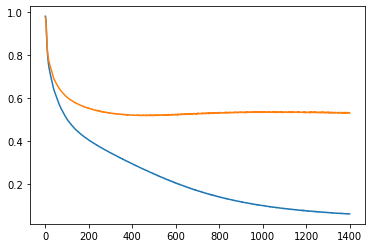

In [13]:
with open('results/autoencoder_nol1.pkl', 'rb') as f:
    print(type(f))
    loss = pickle.load(f)

plt.plot(loss)
plt.show()